In [1]:
import mlflow
import mlflow.tensorflow
mlflow.tensorflow.autolog()
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("tensorflow_experiment")

2025-06-03 14:26:54.248365: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Experiment: artifact_location='mlflow-artifacts:/160580637434278120', creation_time=1748963934592, experiment_id='160580637434278120', last_update_time=1748963934592, lifecycle_stage='active', name='tensorflow_experiment', tags={}>

In [2]:
# all used imoorts
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
#configure TensorFlow to limit VRAM usage

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)]  # MB
        )
        print("VRAM limited to 100 MB.")
    except RuntimeError as e:
        print("Memory configuration must be set at program start:", e)

VRAM limited to 100 MB.


2025-06-03 14:26:56.432733: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-03 14:26:58.820857: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-03 14:26:58.820932: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# Used Functions

#used to load and clean the csv files
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    
    # Drop last 6 rows
    df = df.iloc[:-6]
    
    # Convert date column to datetime
    df['#date+time'] = pd.to_datetime(df['#date+time'], errors='coerce')
    df = df.rename(columns={'#date+time': 'date_time'})
    
    # Convert all other columns to numeric
    for col in df.columns:
        if col != 'date_time':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df
# Function to convert wind speed and direction to U/V components

def wind_to_uv(speed, direction_deg):
    # Convert to radians
    direction_rad = np.deg2rad(direction_deg)

    # U = -speed * sin(direction), V = -speed * cos(direction)

    u = -speed * np.sin(direction_rad)
    v = -speed * np.cos(direction_rad)
    return u, v

# Function to prepare the DataFrame for model input
def prepare_dataframe(df):
    # Rename columns to a consistent format
    df = df.rename(columns={
        df.columns[0]: 'date_time',
        df.columns[1]: 'pwl',
        df.columns[2]: 'wsd',
        df.columns[3]: 'wdr'
    })
    
    # Convert wind to U/V components
    u, v = wind_to_uv(df['wsd'], df['wdr'])
    df[['u', 'v']] = np.column_stack((u, v))
    
    # Drop raw wind columns
    df.drop(columns=['wsd', 'wdr'], inplace=True)
    
    return df
# Function to create input and output arrays for the model
def input_output_arrays(pl_df, po_df, wl_window, wind_window):

    wl_window = wl_window * 10
    wind_window = wind_window * 10

    pl_df = pl_df.reset_index(drop=True)
    po_df = po_df.reset_index(drop=True)

    pl_pwl = pl_df['pwl'].to_numpy()
    pl_u   = pl_df['u'].to_numpy()
    pl_v   = pl_df['v'].to_numpy()
    po_pwl = po_df['pwl'].to_numpy()

    X, y, indices = [], [], []

    for t in range(max(wl_window, wind_window), len(pl_df) - wl_window):
        # Water level window: centered at t
        wl_slice = slice(t - wl_window, t + wl_window + 1)

        # Wind window: past `wind_window` values ending at t
        wind_slice = slice(t - wind_window + 1, t + 1)

        pwl_input = pl_pwl[wl_slice]
        u_input = pl_u[wind_slice]
        v_input = pl_v[wind_slice]
        target = po_pwl[t]

        if (
            np.isnan(pwl_input).any() or
            np.isnan(u_input).any() or
            np.isnan(v_input).any() or
            np.isnan(target)
        ):
            continue

        features = np.concatenate([pwl_input, u_input, v_input])
        X.append(features)
        y.append(target)
        indices.append(t)

    return np.array(X), np.array(y), np.array(indices)

file_paths = {
    'po11': '/home/ryan/Downloads/po_2011-2012.csv',
    'pl11': '/home/ryan/Downloads/pl_2011-2012.csv',
    'po13': '/home/ryan/Downloads/po_2013-2014.csv',
    'pl13': '/home/ryan/Downloads/pl_2013-2014.csv',
    'po15': '/home/ryan/Downloads/po_2015-2016.csv',
    'pl15': '/home/ryan/Downloads/pl_2015-2016.csv',
}
# Function to calculate the percentage of predictions with a central frequency (CF)
def calculate_central_frequency_percentage(testing_label_array, predictions, cm):
  """Find the percentage of predictions with a central frequency (CF) of less than
  or equal to a given number of centimeters (cm)

	Args:
        testing_label_array (array): Testing labels

        predictions (array): Model predictions

        cm (int): Number of centimeters

	Returns:
		(float): central frequency (CF) percentage
	"""
  less_than_cm_counter = 0

  # Convert cm to m
  cm_to_m = cm / 100

  for index, prediction in enumerate(predictions):
    if abs(testing_label_array[index] - prediction) <= cm_to_m:
      less_than_cm_counter += 1

  cf_percentage = (less_than_cm_counter / len(predictions)) * 100

  return cf_percentage

# Function to evaluate the model on the testing data
def evaluate_model(model, testing_input_array, testing_label_array):
  """Calculates loss, makes predictions, and calculates Central Frequency (CF),
  Mean Squared Error (MSE), Root Mean Squared Error(RMSE), Mean Absolute Error (MAE),
  Median Absolute Error, and R-squared (R2)

	Args:
        model (tf.keras.model): The trained model

        testing_input_array (array): Testing inputs

        testing_label_array (array): Testing labels
	"""
  print("Calculating Loss:")
  test_loss = model.evaluate(testing_input_array, testing_label_array, batch_size = len(testing_input_array))

  print("Loss:", test_loss)


  print("\nGenerating output predictions with model:")
  predictions = model.predict(testing_input_array, batch_size = len(testing_input_array))

  # Calculate evaluation metrics
  cf_15cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 15)
  cf_5cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 5)
  cf_1cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 1)
  mse = mean_squared_error(testing_label_array, predictions)
  rmse = root_mean_squared_error(testing_label_array, predictions)
  mae = mean_absolute_error(testing_label_array, predictions)
  medae = median_absolute_error(testing_label_array, predictions)
  r2 = r2_score(testing_label_array, predictions)

  print("\nCentral Frequency Percentage 15cm:", cf_15cm_percentage)
  print("\nCentral Frequency Percentage 5cm:", cf_5cm_percentage)
  print("\nCentral Frequency Percentage 1cm:", cf_1cm_percentage)
  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)
  print("Mean Absolute Error:", mae)
  print("Median Absolute Error:", medae)
  print("R-squared:", r2)

datasets = {key: load_and_clean_csv(path) for key, path in file_paths.items()}

for name, df in datasets.items():
    datasets[name] = prepare_dataframe(df)


/tmp/ipykernel_629054/823489.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_629054/823489.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [5]:
X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=2, wind_window=2)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=2, wind_window=2)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=2, wind_window=2)


In [8]:
import mlflow.tensorflow


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.001),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer='normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

model_file_name = 'plpo.keras'
checkpoint = ModelCheckpoint(
    model_file_name,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
)

callbacks = [early_stopping, checkpoint]

# Start MLflow run
with mlflow.start_run():
    # Train the model
    model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=1000,
        batch_size=len(X_train),
        validation_batch_size=len(X_valid),
        callbacks=callbacks,
    )
    mlflow.tensorflow.log_model(
        model,
        artifact_path="model",
        keras_model_kwargs={"save_format": "keras"}
    )


Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 13.1437 - mae: 3.6202
Epoch 1: val_loss improved from inf to 12.59250, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 13.1437 - mae: 3.6202 - val_loss: 12.5925 - val_mae: 3.5441
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 12.8721 - mae: 3.5821
Epoch 2: val_loss improved from 12.59250 to 12.31544, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 12.8721 - mae: 3.5821 - val_loss: 12.3154 - val_mae: 3.5044
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 12.5954 - mae: 3.5428
Epoch 3: val_loss improved from 12.31544 to 12.03396, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 12.5954 - mae: 3.5428 - val_loss: 12.0340 - val_mae: 3.4634
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 12.3133 - mae: 3.5021
Epoch 4: val_loss improved from 12.03396 to 11.74752, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 12.3133 - mae: 3.5021 - val_loss: 11.7475 - val_mae: 3.4211
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 12.0204 - mae: 3.4592
Epoch 5: val_loss improved from 11.74752 to 11.45458, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 12.0204 - mae: 3.4592 - val_loss: 11.4546 - val_mae: 3.3771
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 11.7208 - mae: 3.4146
Epoch 6: val_loss improved from 11.45458 to 11.15448, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 11.7208 - mae: 3.4146 - val_loss: 11.1545 - val_mae: 3.3313
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 11.4091 - mae: 3.3675
Epoch 7: val_loss improved from 11.15448 to 10.84739, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 11.4091 - mae: 3.3675 - val_loss: 10.8474 - val_mae: 3.2835
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 11.0902 - mae: 3.3183
Epoch 8: val_loss improved from 10.84739 to 10.53374, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 11.0902 - mae: 3.3183 - val_loss: 10.5337 - val_mae: 3.2336
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 10.7602 - mae: 3.2665
Epoch 9: val_loss improved from 10.53374 to 10.21232, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 10.7602 - mae: 3.2665 - val_loss: 10.2123 - val_mae: 3.1814
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 10.4224 - mae: 3.2122
Epoch 10: val_loss improved from 10.21232 to 9.88134, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 10.4224 - mae: 3.2122 - val_loss: 9.8813 - val_mae: 3.1263
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 10.0724 - mae: 3.1546
Epoch 11: val_loss improved from 9.88134 to 9.53975, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 10.0724 - mae: 3.1546 - val_loss: 9.5398 - val_mae: 3.0679
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 9.7097 - mae: 3.0933
Epoch 12: val_loss improved from 9.53975 to 9.18744, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 9.7097 - mae: 3.0933 - val_loss: 9.1874 - val_mae: 3.0059
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 9.3353 - mae: 3.0282
Epoch 13: val_loss improved from 9.18744 to 8.82465, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 9.3353 - mae: 3.0282 - val_loss: 8.8246 - val_mae: 2.9401
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 8.9495 - mae: 2.9591
Epoch 14: val_loss improved from 8.82465 to 8.45206, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 8.9495 - mae: 2.9591 - val_loss: 8.4521 - val_mae: 2.8701
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 8.5509 - mae: 2.8852
Epoch 15: val_loss improved from 8.45206 to 8.06990, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 8.5509 - mae: 2.8852 - val_loss: 8.0699 - val_mae: 2.7957
Epoch 16/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 8.1402 - mae: 2.8063
Epoch 16: val_loss improved from 8.06990 to 7.67853, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 8.1402 - mae: 2.8063 - val_loss: 7.6785 - val_mae: 2.7165
Epoch 17/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 7.7141 - mae: 2.7211
Epoch 17: val_loss improved from 7.67853 to 7.27867, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 7.7141 - mae: 2.7211 - val_loss: 7.2787 - val_mae: 2.6321
Epoch 18/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 7.2758 - mae: 2.6294
Epoch 18: val_loss improved from 7.27867 to 6.87178, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 7.2758 - mae: 2.6294 - val_loss: 6.8718 - val_mae: 2.5422
Epoch 19/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 6.8303 - mae: 2.5317
Epoch 19: val_loss improved from 6.87178 to 6.46009, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 6.8303 - mae: 2.5317 - val_loss: 6.4601 - val_mae: 2.4467
Epoch 20/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 6.3774 - mae: 2.4268
Epoch 20: val_loss improved from 6.46009 to 6.04602, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 6.3774 - mae: 2.4268 - val_loss: 6.0460 - val_mae: 2.3455
Epoch 21/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 5.9226 - mae: 2.3154
Epoch 21: val_loss improved from 6.04602 to 5.63242, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 5.9226 - mae: 2.3154 - val_loss: 5.6324 - val_mae: 2.2389
Epoch 22/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 5.4689 - mae: 2.1975
Epoch 22: val_loss improved from 5.63242 to 5.22317, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 5.4689 - mae: 2.1975 - val_loss: 5.2232 - val_mae: 2.1276
Epoch 23/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 5.0233 - mae: 2.0754
Epoch 23: val_loss improved from 5.22317 to 4.82311, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 5.0233 - mae: 2.0754 - val_loss: 4.8231 - val_mae: 2.0135
Epoch 24/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 4.5921 - mae: 1.9513
Epoch 24: val_loss improved from 4.82311 to 4.43769, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 4.5921 - mae: 1.9513 - val_loss: 4.4377 - val_mae: 1.9005
Epoch 25/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 4.1830 - mae: 1.8298
Epoch 25: val_loss improved from 4.43769 to 4.07314, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 4.1830 - mae: 1.8298 - val_loss: 4.0731 - val_mae: 1.7931
Epoch 26/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 3.7982 - mae: 1.7142
Epoch 26: val_loss improved from 4.07314 to 3.73632, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 3.7982 - mae: 1.7142 - val_loss: 3.7363 - val_mae: 1.6951
Epoch 27/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.4539 - mae: 1.6108
Epoch 27: val_loss improved from 3.73632 to 3.43380, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 3.4539 - mae: 1.6108 - val_loss: 3.4338 - val_mae: 1.6091
Epoch 28/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.1509 - mae: 1.5211
Epoch 28: val_loss improved from 3.43380 to 3.17130, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 3.1509 - mae: 1.5211 - val_loss: 3.1713 - val_mae: 1.5354
Epoch 29/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.8992 - mae: 1.4476
Epoch 29: val_loss improved from 3.17130 to 2.95290, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 2.8992 - mae: 1.4476 - val_loss: 2.9529 - val_mae: 1.4746
Epoch 30/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.7021 - mae: 1.3901
Epoch 30: val_loss improved from 2.95290 to 2.78033, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 2.7021 - mae: 1.3901 - val_loss: 2.7803 - val_mae: 1.4261
Epoch 31/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.5577 - mae: 1.3472
Epoch 31: val_loss improved from 2.78033 to 2.65231, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 2.5577 - mae: 1.3472 - val_loss: 2.6523 - val_mae: 1.3888
Epoch 32/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.4698 - mae: 1.3199
Epoch 32: val_loss improved from 2.65231 to 2.56413, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 2.4698 - mae: 1.3199 - val_loss: 2.5641 - val_mae: 1.3616
Epoch 33/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.4292 - mae: 1.3058
Epoch 33: val_loss improved from 2.56413 to 2.50751, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 2.4292 - mae: 1.3058 - val_loss: 2.5075 - val_mae: 1.3418
Epoch 34/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.4233 - mae: 1.3000
Epoch 34: val_loss improved from 2.50751 to 2.47165, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 2.4233 - mae: 1.3000 - val_loss: 2.4716 - val_mae: 1.3268
Epoch 35/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.4417 - mae: 1.3011
Epoch 35: val_loss improved from 2.47165 to 2.44472, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 2.4417 - mae: 1.3011 - val_loss: 2.4447 - val_mae: 1.3139
Epoch 36/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.4618 - mae: 1.3026
Epoch 36: val_loss improved from 2.44472 to 2.41623, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 2.4618 - mae: 1.3026 - val_loss: 2.4162 - val_mae: 1.3007
Epoch 37/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.4752 - mae: 1.3025
Epoch 37: val_loss improved from 2.41623 to 2.37853, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 2.4752 - mae: 1.3025 - val_loss: 2.3785 - val_mae: 1.2855
Epoch 38/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 2.4737 - mae: 1.3001
Epoch 38: val_loss improved from 2.37853 to 2.32755, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 2.4737 - mae: 1.3001 - val_loss: 2.3276 - val_mae: 1.2674
Epoch 39/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.4449 - mae: 1.2904
Epoch 39: val_loss improved from 2.32755 to 2.26280, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 2.4449 - mae: 1.2904 - val_loss: 2.2628 - val_mae: 1.2464
Epoch 40/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.3961 - mae: 1.2767
Epoch 40: val_loss improved from 2.26280 to 2.18641, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 2.3961 - mae: 1.2767 - val_loss: 2.1864 - val_mae: 1.2228
Epoch 41/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.3240 - mae: 1.2570
Epoch 41: val_loss improved from 2.18641 to 2.10230, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 2.3240 - mae: 1.2570 - val_loss: 2.1023 - val_mae: 1.1974
Epoch 42/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.2354 - mae: 1.2331
Epoch 42: val_loss improved from 2.10230 to 2.01506, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 2.2354 - mae: 1.2331 - val_loss: 2.0151 - val_mae: 1.1714
Epoch 43/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.1368 - mae: 1.2063
Epoch 43: val_loss improved from 2.01506 to 1.92910, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 2.1368 - mae: 1.2063 - val_loss: 1.9291 - val_mae: 1.1456
Epoch 44/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.0387 - mae: 1.1788
Epoch 44: val_loss improved from 1.92910 to 1.84801, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 2.0387 - mae: 1.1788 - val_loss: 1.8480 - val_mae: 1.1209
Epoch 45/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.9396 - mae: 1.1507
Epoch 45: val_loss improved from 1.84801 to 1.77432, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.9396 - mae: 1.1507 - val_loss: 1.7743 - val_mae: 1.0980
Epoch 46/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.8503 - mae: 1.1247
Epoch 46: val_loss improved from 1.77432 to 1.70936, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 1.8503 - mae: 1.1247 - val_loss: 1.7094 - val_mae: 1.0772
Epoch 47/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.7691 - mae: 1.1003
Epoch 47: val_loss improved from 1.70936 to 1.65328, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 1.7691 - mae: 1.1003 - val_loss: 1.6533 - val_mae: 1.0588
Epoch 48/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.7003 - mae: 1.0788
Epoch 48: val_loss improved from 1.65328 to 1.60535, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.7003 - mae: 1.0788 - val_loss: 1.6053 - val_mae: 1.0426
Epoch 49/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.6399 - mae: 1.0591
Epoch 49: val_loss improved from 1.60535 to 1.56420, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 1.6399 - mae: 1.0591 - val_loss: 1.5642 - val_mae: 1.0284
Epoch 50/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.5900 - mae: 1.0426
Epoch 50: val_loss improved from 1.56420 to 1.52815, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 1.5900 - mae: 1.0426 - val_loss: 1.5281 - val_mae: 1.0159
Epoch 51/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.5479 - mae: 1.0284
Epoch 51: val_loss improved from 1.52815 to 1.49542, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.5479 - mae: 1.0284 - val_loss: 1.4954 - val_mae: 1.0044
Epoch 52/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.5112 - mae: 1.0152
Epoch 52: val_loss improved from 1.49542 to 1.46444, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 1.5112 - mae: 1.0152 - val_loss: 1.4644 - val_mae: 0.9935
Epoch 53/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.4792 - mae: 1.0030
Epoch 53: val_loss improved from 1.46444 to 1.43389, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 1.4792 - mae: 1.0030 - val_loss: 1.4339 - val_mae: 0.9827
Epoch 54/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.4462 - mae: 0.9911
Epoch 54: val_loss improved from 1.43389 to 1.40289, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 1.4462 - mae: 0.9911 - val_loss: 1.4029 - val_mae: 0.9717
Epoch 55/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.4145 - mae: 0.9789
Epoch 55: val_loss improved from 1.40289 to 1.37097, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.4145 - mae: 0.9789 - val_loss: 1.3710 - val_mae: 0.9602
Epoch 56/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.3840 - mae: 0.9675
Epoch 56: val_loss improved from 1.37097 to 1.33804, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.3840 - mae: 0.9675 - val_loss: 1.3380 - val_mae: 0.9484
Epoch 57/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.3501 - mae: 0.9544
Epoch 57: val_loss improved from 1.33804 to 1.30443, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.3501 - mae: 0.9544 - val_loss: 1.3044 - val_mae: 0.9363
Epoch 58/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.3172 - mae: 0.9419
Epoch 58: val_loss improved from 1.30443 to 1.27070, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.3172 - mae: 0.9419 - val_loss: 1.2707 - val_mae: 0.9240
Epoch 59/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.2817 - mae: 0.9280
Epoch 59: val_loss improved from 1.27070 to 1.23753, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 1.2817 - mae: 0.9280 - val_loss: 1.2375 - val_mae: 0.9119
Epoch 60/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.2464 - mae: 0.9140
Epoch 60: val_loss improved from 1.23753 to 1.20560, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 1.2464 - mae: 0.9140 - val_loss: 1.2056 - val_mae: 0.9003
Epoch 61/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 1.2098 - mae: 0.8994
Epoch 61: val_loss improved from 1.20560 to 1.17545, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 1.2098 - mae: 0.8994 - val_loss: 1.1754 - val_mae: 0.8892
Epoch 62/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.1758 - mae: 0.8853
Epoch 62: val_loss improved from 1.17545 to 1.14734, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.1758 - mae: 0.8853 - val_loss: 1.1473 - val_mae: 0.8787
Epoch 63/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.1434 - mae: 0.8725
Epoch 63: val_loss improved from 1.14734 to 1.12119, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.1434 - mae: 0.8725 - val_loss: 1.1212 - val_mae: 0.8686
Epoch 64/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.1124 - mae: 0.8596
Epoch 64: val_loss improved from 1.12119 to 1.09651, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 1.1124 - mae: 0.8596 - val_loss: 1.0965 - val_mae: 0.8588
Epoch 65/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 1.0819 - mae: 0.8463
Epoch 65: val_loss improved from 1.09651 to 1.07251, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 1.0819 - mae: 0.8463 - val_loss: 1.0725 - val_mae: 0.8488
Epoch 66/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.0537 - mae: 0.8338
Epoch 66: val_loss improved from 1.07251 to 1.04856, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 1.0537 - mae: 0.8338 - val_loss: 1.0486 - val_mae: 0.8384
Epoch 67/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.0255 - mae: 0.8215
Epoch 67: val_loss improved from 1.04856 to 1.02426, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 1.0255 - mae: 0.8215 - val_loss: 1.0243 - val_mae: 0.8276
Epoch 68/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.9962 - mae: 0.8077
Epoch 68: val_loss improved from 1.02426 to 0.99918, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.9962 - mae: 0.8077 - val_loss: 0.9992 - val_mae: 0.8162
Epoch 69/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.9674 - mae: 0.7949
Epoch 69: val_loss improved from 0.99918 to 0.97250, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.9674 - mae: 0.7949 - val_loss: 0.9725 - val_mae: 0.8041
Epoch 70/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.9391 - mae: 0.7818
Epoch 70: val_loss improved from 0.97250 to 0.94357, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.9391 - mae: 0.7818 - val_loss: 0.9436 - val_mae: 0.7910
Epoch 71/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.9092 - mae: 0.7682
Epoch 71: val_loss improved from 0.94357 to 0.91227, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.9092 - mae: 0.7682 - val_loss: 0.9123 - val_mae: 0.7768
Epoch 72/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.8764 - mae: 0.7537
Epoch 72: val_loss improved from 0.91227 to 0.87905, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.8764 - mae: 0.7537 - val_loss: 0.8790 - val_mae: 0.7617
Epoch 73/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8450 - mae: 0.7392
Epoch 73: val_loss improved from 0.87905 to 0.84463, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.8450 - mae: 0.7392 - val_loss: 0.8446 - val_mae: 0.7460
Epoch 74/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8144 - mae: 0.7257
Epoch 74: val_loss improved from 0.84463 to 0.80996, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.8144 - mae: 0.7257 - val_loss: 0.8100 - val_mae: 0.7301
Epoch 75/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.7828 - mae: 0.7114
Epoch 75: val_loss improved from 0.80996 to 0.77589, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.7828 - mae: 0.7114 - val_loss: 0.7759 - val_mae: 0.7142
Epoch 76/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.7515 - mae: 0.6973
Epoch 76: val_loss improved from 0.77589 to 0.74317, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.7515 - mae: 0.6973 - val_loss: 0.7432 - val_mae: 0.6987
Epoch 77/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.7239 - mae: 0.6845
Epoch 77: val_loss improved from 0.74317 to 0.71236, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.7239 - mae: 0.6845 - val_loss: 0.7124 - val_mae: 0.6839
Epoch 78/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.6957 - mae: 0.6712
Epoch 78: val_loss improved from 0.71236 to 0.68368, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.6957 - mae: 0.6712 - val_loss: 0.6837 - val_mae: 0.6699
Epoch 79/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6714 - mae: 0.6598
Epoch 79: val_loss improved from 0.68368 to 0.65709, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.6714 - mae: 0.6598 - val_loss: 0.6571 - val_mae: 0.6566
Epoch 80/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.6465 - mae: 0.6475
Epoch 80: val_loss improved from 0.65709 to 0.63230, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.6465 - mae: 0.6475 - val_loss: 0.6323 - val_mae: 0.6441
Epoch 81/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.6236 - mae: 0.6363
Epoch 81: val_loss improved from 0.63230 to 0.60891, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.6236 - mae: 0.6363 - val_loss: 0.6089 - val_mae: 0.6320
Epoch 82/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.6023 - mae: 0.6251
Epoch 82: val_loss improved from 0.60891 to 0.58651, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.6023 - mae: 0.6251 - val_loss: 0.5865 - val_mae: 0.6202
Epoch 83/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.5821 - mae: 0.6146
Epoch 83: val_loss improved from 0.58651 to 0.56480, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.5821 - mae: 0.6146 - val_loss: 0.5648 - val_mae: 0.6085
Epoch 84/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.5624 - mae: 0.6036
Epoch 84: val_loss improved from 0.56480 to 0.54359, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.5624 - mae: 0.6036 - val_loss: 0.5436 - val_mae: 0.5966
Epoch 85/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5409 - mae: 0.5915
Epoch 85: val_loss improved from 0.54359 to 0.52288, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.5409 - mae: 0.5915 - val_loss: 0.5229 - val_mae: 0.5846
Epoch 86/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.5206 - mae: 0.5790
Epoch 86: val_loss improved from 0.52288 to 0.50282, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.5206 - mae: 0.5790 - val_loss: 0.5028 - val_mae: 0.5724
Epoch 87/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.4999 - mae: 0.5662
Epoch 87: val_loss improved from 0.50282 to 0.48359, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.4999 - mae: 0.5662 - val_loss: 0.4836 - val_mae: 0.5602
Epoch 88/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.4807 - mae: 0.5538
Epoch 88: val_loss improved from 0.48359 to 0.46542, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.4807 - mae: 0.5538 - val_loss: 0.4654 - val_mae: 0.5482
Epoch 89/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.4637 - mae: 0.5418
Epoch 89: val_loss improved from 0.46542 to 0.44846, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.4637 - mae: 0.5418 - val_loss: 0.4485 - val_mae: 0.5364
Epoch 90/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.4451 - mae: 0.5293
Epoch 90: val_loss improved from 0.44846 to 0.43279, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.4451 - mae: 0.5293 - val_loss: 0.4328 - val_mae: 0.5251
Epoch 91/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.4288 - mae: 0.5177
Epoch 91: val_loss improved from 0.43279 to 0.41838, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.4288 - mae: 0.5177 - val_loss: 0.4184 - val_mae: 0.5144
Epoch 92/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.4147 - mae: 0.5074
Epoch 92: val_loss improved from 0.41838 to 0.40517, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.4147 - mae: 0.5074 - val_loss: 0.4052 - val_mae: 0.5042
Epoch 93/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3994 - mae: 0.4963
Epoch 93: val_loss improved from 0.40517 to 0.39304, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.3994 - mae: 0.4963 - val_loss: 0.3930 - val_mae: 0.4947
Epoch 94/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3882 - mae: 0.4872
Epoch 94: val_loss improved from 0.39304 to 0.38188, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.3882 - mae: 0.4872 - val_loss: 0.3819 - val_mae: 0.4859
Epoch 95/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3754 - mae: 0.4781
Epoch 95: val_loss improved from 0.38188 to 0.37164, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.3754 - mae: 0.4781 - val_loss: 0.3716 - val_mae: 0.4778
Epoch 96/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3624 - mae: 0.4688
Epoch 96: val_loss improved from 0.37164 to 0.36227, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.3624 - mae: 0.4688 - val_loss: 0.3623 - val_mae: 0.4704
Epoch 97/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3516 - mae: 0.4608
Epoch 97: val_loss improved from 0.36227 to 0.35366, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.3516 - mae: 0.4608 - val_loss: 0.3537 - val_mae: 0.4637
Epoch 98/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3417 - mae: 0.4535
Epoch 98: val_loss improved from 0.35366 to 0.34565, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.3417 - mae: 0.4535 - val_loss: 0.3456 - val_mae: 0.4576
Epoch 99/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.3341 - mae: 0.4475
Epoch 99: val_loss improved from 0.34565 to 0.33799, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.3341 - mae: 0.4475 - val_loss: 0.3380 - val_mae: 0.4518
Epoch 100/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3267 - mae: 0.4420
Epoch 100: val_loss improved from 0.33799 to 0.33046, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.3267 - mae: 0.4420 - val_loss: 0.3305 - val_mae: 0.4462
Epoch 101/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.3167 - mae: 0.4355
Epoch 101: val_loss improved from 0.33046 to 0.32291, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.3167 - mae: 0.4355 - val_loss: 0.3229 - val_mae: 0.4406
Epoch 102/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3109 - mae: 0.4310
Epoch 102: val_loss improved from 0.32291 to 0.31522, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.3109 - mae: 0.4310 - val_loss: 0.3152 - val_mae: 0.4351
Epoch 103/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3032 - mae: 0.4257
Epoch 103: val_loss improved from 0.31522 to 0.30739, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.3032 - mae: 0.4257 - val_loss: 0.3074 - val_mae: 0.4295
Epoch 104/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2965 - mae: 0.4207
Epoch 104: val_loss improved from 0.30739 to 0.29949, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.2965 - mae: 0.4207 - val_loss: 0.2995 - val_mae: 0.4239
Epoch 105/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2903 - mae: 0.4163
Epoch 105: val_loss improved from 0.29949 to 0.29161, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.2903 - mae: 0.4163 - val_loss: 0.2916 - val_mae: 0.4183
Epoch 106/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2862 - mae: 0.4131
Epoch 106: val_loss improved from 0.29161 to 0.28388, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.2862 - mae: 0.4131 - val_loss: 0.2839 - val_mae: 0.4130
Epoch 107/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2820 - mae: 0.4098
Epoch 107: val_loss improved from 0.28388 to 0.27640, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.2820 - mae: 0.4098 - val_loss: 0.2764 - val_mae: 0.4080
Epoch 108/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2754 - mae: 0.4052
Epoch 108: val_loss improved from 0.27640 to 0.26930, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.2754 - mae: 0.4052 - val_loss: 0.2693 - val_mae: 0.4033
Epoch 109/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2703 - mae: 0.4015
Epoch 109: val_loss improved from 0.26930 to 0.26266, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2703 - mae: 0.4015 - val_loss: 0.2627 - val_mae: 0.3990
Epoch 110/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2675 - mae: 0.3995
Epoch 110: val_loss improved from 0.26266 to 0.25653, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.2675 - mae: 0.3995 - val_loss: 0.2565 - val_mae: 0.3951
Epoch 111/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2643 - mae: 0.3970
Epoch 111: val_loss improved from 0.25653 to 0.25094, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2643 - mae: 0.3970 - val_loss: 0.2509 - val_mae: 0.3917
Epoch 112/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2587 - mae: 0.3931
Epoch 112: val_loss improved from 0.25094 to 0.24588, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.2587 - mae: 0.3931 - val_loss: 0.2459 - val_mae: 0.3885
Epoch 113/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2564 - mae: 0.3911
Epoch 113: val_loss improved from 0.24588 to 0.24130, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2564 - mae: 0.3911 - val_loss: 0.2413 - val_mae: 0.3856
Epoch 114/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2544 - mae: 0.3895
Epoch 114: val_loss improved from 0.24130 to 0.23713, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2544 - mae: 0.3895 - val_loss: 0.2371 - val_mae: 0.3828
Epoch 115/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2507 - mae: 0.3869
Epoch 115: val_loss improved from 0.23713 to 0.23329, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.2507 - mae: 0.3869 - val_loss: 0.2333 - val_mae: 0.3802
Epoch 116/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2484 - mae: 0.3854
Epoch 116: val_loss improved from 0.23329 to 0.22969, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2484 - mae: 0.3854 - val_loss: 0.2297 - val_mae: 0.3776
Epoch 117/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2450 - mae: 0.3824
Epoch 117: val_loss improved from 0.22969 to 0.22626, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.2450 - mae: 0.3824 - val_loss: 0.2263 - val_mae: 0.3749
Epoch 118/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2419 - mae: 0.3808
Epoch 118: val_loss improved from 0.22626 to 0.22294, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.2419 - mae: 0.3808 - val_loss: 0.2229 - val_mae: 0.3721
Epoch 119/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2413 - mae: 0.3796
Epoch 119: val_loss improved from 0.22294 to 0.21974, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.2413 - mae: 0.3796 - val_loss: 0.2197 - val_mae: 0.3693
Epoch 120/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2381 - mae: 0.3771
Epoch 120: val_loss improved from 0.21974 to 0.21666, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.2381 - mae: 0.3771 - val_loss: 0.2167 - val_mae: 0.3665
Epoch 121/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2358 - mae: 0.3753
Epoch 121: val_loss improved from 0.21666 to 0.21370, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.2358 - mae: 0.3753 - val_loss: 0.2137 - val_mae: 0.3637
Epoch 122/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2336 - mae: 0.3731
Epoch 122: val_loss improved from 0.21370 to 0.21088, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2336 - mae: 0.3731 - val_loss: 0.2109 - val_mae: 0.3611
Epoch 123/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2329 - mae: 0.3720
Epoch 123: val_loss improved from 0.21088 to 0.20821, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2329 - mae: 0.3720 - val_loss: 0.2082 - val_mae: 0.3585
Epoch 124/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2300 - mae: 0.3699
Epoch 124: val_loss improved from 0.20821 to 0.20569, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.2300 - mae: 0.3699 - val_loss: 0.2057 - val_mae: 0.3561
Epoch 125/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2279 - mae: 0.3678
Epoch 125: val_loss improved from 0.20569 to 0.20335, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2279 - mae: 0.3678 - val_loss: 0.2033 - val_mae: 0.3539
Epoch 126/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2269 - mae: 0.3667
Epoch 126: val_loss improved from 0.20335 to 0.20117, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.2269 - mae: 0.3667 - val_loss: 0.2012 - val_mae: 0.3519
Epoch 127/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2246 - mae: 0.3650
Epoch 127: val_loss improved from 0.20117 to 0.19913, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2246 - mae: 0.3650 - val_loss: 0.1991 - val_mae: 0.3500
Epoch 128/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2226 - mae: 0.3631
Epoch 128: val_loss improved from 0.19913 to 0.19720, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2226 - mae: 0.3631 - val_loss: 0.1972 - val_mae: 0.3482
Epoch 129/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2216 - mae: 0.3620
Epoch 129: val_loss improved from 0.19720 to 0.19536, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2216 - mae: 0.3620 - val_loss: 0.1954 - val_mae: 0.3466
Epoch 130/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2205 - mae: 0.3605
Epoch 130: val_loss improved from 0.19536 to 0.19357, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.2205 - mae: 0.3605 - val_loss: 0.1936 - val_mae: 0.3449
Epoch 131/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2170 - mae: 0.3581
Epoch 131: val_loss improved from 0.19357 to 0.19183, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: 0.2170 - mae: 0.3581 - val_loss: 0.1918 - val_mae: 0.3434
Epoch 132/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2153 - mae: 0.3569
Epoch 132: val_loss improved from 0.19183 to 0.19012, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.2153 - mae: 0.3569 - val_loss: 0.1901 - val_mae: 0.3418
Epoch 133/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2152 - mae: 0.3562
Epoch 133: val_loss improved from 0.19012 to 0.18845, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.2152 - mae: 0.3562 - val_loss: 0.1885 - val_mae: 0.3403
Epoch 134/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2149 - mae: 0.3555
Epoch 134: val_loss improved from 0.18845 to 0.18682, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.2149 - mae: 0.3555 - val_loss: 0.1868 - val_mae: 0.3389
Epoch 135/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2125 - mae: 0.3539
Epoch 135: val_loss improved from 0.18682 to 0.18523, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2125 - mae: 0.3539 - val_loss: 0.1852 - val_mae: 0.3374
Epoch 136/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2115 - mae: 0.3530
Epoch 136: val_loss improved from 0.18523 to 0.18371, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2115 - mae: 0.3530 - val_loss: 0.1837 - val_mae: 0.3361
Epoch 137/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2108 - mae: 0.3520
Epoch 137: val_loss improved from 0.18371 to 0.18226, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.2108 - mae: 0.3520 - val_loss: 0.1823 - val_mae: 0.3348
Epoch 138/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2093 - mae: 0.3506
Epoch 138: val_loss improved from 0.18226 to 0.18091, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2093 - mae: 0.3506 - val_loss: 0.1809 - val_mae: 0.3335
Epoch 139/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2093 - mae: 0.3503
Epoch 139: val_loss improved from 0.18091 to 0.17968, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2093 - mae: 0.3503 - val_loss: 0.1797 - val_mae: 0.3324
Epoch 140/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2071 - mae: 0.3488
Epoch 140: val_loss improved from 0.17968 to 0.17858, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.2071 - mae: 0.3488 - val_loss: 0.1786 - val_mae: 0.3314
Epoch 141/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2068 - mae: 0.3481
Epoch 141: val_loss improved from 0.17858 to 0.17759, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.2068 - mae: 0.3481 - val_loss: 0.1776 - val_mae: 0.3305
Epoch 142/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2053 - mae: 0.3468
Epoch 142: val_loss improved from 0.17759 to 0.17671, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.2053 - mae: 0.3468 - val_loss: 0.1767 - val_mae: 0.3296
Epoch 143/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2039 - mae: 0.3460
Epoch 143: val_loss improved from 0.17671 to 0.17591, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2039 - mae: 0.3460 - val_loss: 0.1759 - val_mae: 0.3288
Epoch 144/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2046 - mae: 0.3461
Epoch 144: val_loss improved from 0.17591 to 0.17520, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2046 - mae: 0.3461 - val_loss: 0.1752 - val_mae: 0.3281
Epoch 145/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2025 - mae: 0.3447
Epoch 145: val_loss improved from 0.17520 to 0.17454, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2025 - mae: 0.3447 - val_loss: 0.1745 - val_mae: 0.3273
Epoch 146/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2019 - mae: 0.3441
Epoch 146: val_loss improved from 0.17454 to 0.17393, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.2019 - mae: 0.3441 - val_loss: 0.1739 - val_mae: 0.3266
Epoch 147/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2011 - mae: 0.3433
Epoch 147: val_loss improved from 0.17393 to 0.17334, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2011 - mae: 0.3433 - val_loss: 0.1733 - val_mae: 0.3259
Epoch 148/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2005 - mae: 0.3425
Epoch 148: val_loss improved from 0.17334 to 0.17276, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.2005 - mae: 0.3425 - val_loss: 0.1728 - val_mae: 0.3251
Epoch 149/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2000 - mae: 0.3423
Epoch 149: val_loss improved from 0.17276 to 0.17217, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2000 - mae: 0.3423 - val_loss: 0.1722 - val_mae: 0.3244
Epoch 150/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1995 - mae: 0.3416
Epoch 150: val_loss improved from 0.17217 to 0.17160, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1995 - mae: 0.3416 - val_loss: 0.1716 - val_mae: 0.3237
Epoch 151/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1991 - mae: 0.3412
Epoch 151: val_loss improved from 0.17160 to 0.17104, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1991 - mae: 0.3412 - val_loss: 0.1710 - val_mae: 0.3231
Epoch 152/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1980 - mae: 0.3404
Epoch 152: val_loss improved from 0.17104 to 0.17049, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1980 - mae: 0.3404 - val_loss: 0.1705 - val_mae: 0.3225
Epoch 153/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1963 - mae: 0.3390
Epoch 153: val_loss improved from 0.17049 to 0.16998, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1963 - mae: 0.3390 - val_loss: 0.1700 - val_mae: 0.3219
Epoch 154/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1958 - mae: 0.3385
Epoch 154: val_loss improved from 0.16998 to 0.16948, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1958 - mae: 0.3385 - val_loss: 0.1695 - val_mae: 0.3214
Epoch 155/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1950 - mae: 0.3378
Epoch 155: val_loss improved from 0.16948 to 0.16900, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.1950 - mae: 0.3378 - val_loss: 0.1690 - val_mae: 0.3209
Epoch 156/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1939 - mae: 0.3371
Epoch 156: val_loss improved from 0.16900 to 0.16854, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - loss: 0.1939 - mae: 0.3371 - val_loss: 0.1685 - val_mae: 0.3204
Epoch 157/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1939 - mae: 0.3367
Epoch 157: val_loss improved from 0.16854 to 0.16807, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1939 - mae: 0.3367 - val_loss: 0.1681 - val_mae: 0.3199
Epoch 158/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1936 - mae: 0.3365
Epoch 158: val_loss improved from 0.16807 to 0.16759, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1936 - mae: 0.3365 - val_loss: 0.1676 - val_mae: 0.3193
Epoch 159/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1922 - mae: 0.3357
Epoch 159: val_loss improved from 0.16759 to 0.16709, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1922 - mae: 0.3357 - val_loss: 0.1671 - val_mae: 0.3188
Epoch 160/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1917 - mae: 0.3351
Epoch 160: val_loss improved from 0.16709 to 0.16656, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1917 - mae: 0.3351 - val_loss: 0.1666 - val_mae: 0.3182
Epoch 161/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1910 - mae: 0.3347
Epoch 161: val_loss improved from 0.16656 to 0.16603, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1910 - mae: 0.3347 - val_loss: 0.1660 - val_mae: 0.3177
Epoch 162/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1912 - mae: 0.3346
Epoch 162: val_loss improved from 0.16603 to 0.16550, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1912 - mae: 0.3346 - val_loss: 0.1655 - val_mae: 0.3172
Epoch 163/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1883 - mae: 0.3325
Epoch 163: val_loss improved from 0.16550 to 0.16500, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1883 - mae: 0.3325 - val_loss: 0.1650 - val_mae: 0.3167
Epoch 164/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1900 - mae: 0.3338
Epoch 164: val_loss improved from 0.16500 to 0.16452, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1900 - mae: 0.3338 - val_loss: 0.1645 - val_mae: 0.3163
Epoch 165/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1881 - mae: 0.3324
Epoch 165: val_loss improved from 0.16452 to 0.16407, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1881 - mae: 0.3324 - val_loss: 0.1641 - val_mae: 0.3158
Epoch 166/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1872 - mae: 0.3317
Epoch 166: val_loss improved from 0.16407 to 0.16366, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1872 - mae: 0.3317 - val_loss: 0.1637 - val_mae: 0.3154
Epoch 167/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1869 - mae: 0.3316
Epoch 167: val_loss improved from 0.16366 to 0.16327, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.1869 - mae: 0.3316 - val_loss: 0.1633 - val_mae: 0.3150
Epoch 168/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1867 - mae: 0.3310
Epoch 168: val_loss improved from 0.16327 to 0.16291, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1867 - mae: 0.3310 - val_loss: 0.1629 - val_mae: 0.3147
Epoch 169/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1855 - mae: 0.3302
Epoch 169: val_loss improved from 0.16291 to 0.16258, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1855 - mae: 0.3302 - val_loss: 0.1626 - val_mae: 0.3143
Epoch 170/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1854 - mae: 0.3299
Epoch 170: val_loss improved from 0.16258 to 0.16228, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1854 - mae: 0.3299 - val_loss: 0.1623 - val_mae: 0.3140
Epoch 171/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1855 - mae: 0.3299
Epoch 171: val_loss improved from 0.16228 to 0.16199, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1855 - mae: 0.3299 - val_loss: 0.1620 - val_mae: 0.3137
Epoch 172/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1847 - mae: 0.3294
Epoch 172: val_loss improved from 0.16199 to 0.16170, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1847 - mae: 0.3294 - val_loss: 0.1617 - val_mae: 0.3134
Epoch 173/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1849 - mae: 0.3296
Epoch 173: val_loss improved from 0.16170 to 0.16141, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1849 - mae: 0.3296 - val_loss: 0.1614 - val_mae: 0.3131
Epoch 174/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1832 - mae: 0.3284
Epoch 174: val_loss improved from 0.16141 to 0.16110, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1832 - mae: 0.3284 - val_loss: 0.1611 - val_mae: 0.3127
Epoch 175/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1821 - mae: 0.3275
Epoch 175: val_loss improved from 0.16110 to 0.16081, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1821 - mae: 0.3275 - val_loss: 0.1608 - val_mae: 0.3124
Epoch 176/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1827 - mae: 0.3278
Epoch 176: val_loss improved from 0.16081 to 0.16051, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1827 - mae: 0.3278 - val_loss: 0.1605 - val_mae: 0.3120
Epoch 177/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1815 - mae: 0.3269
Epoch 177: val_loss improved from 0.16051 to 0.16024, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.1815 - mae: 0.3269 - val_loss: 0.1602 - val_mae: 0.3117
Epoch 178/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1806 - mae: 0.3263
Epoch 178: val_loss improved from 0.16024 to 0.15997, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1806 - mae: 0.3263 - val_loss: 0.1600 - val_mae: 0.3114
Epoch 179/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1804 - mae: 0.3259
Epoch 179: val_loss improved from 0.15997 to 0.15972, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1804 - mae: 0.3259 - val_loss: 0.1597 - val_mae: 0.3111
Epoch 180/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1806 - mae: 0.3262
Epoch 180: val_loss improved from 0.15972 to 0.15947, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1806 - mae: 0.3262 - val_loss: 0.1595 - val_mae: 0.3109
Epoch 181/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1804 - mae: 0.3260
Epoch 181: val_loss improved from 0.15947 to 0.15922, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1804 - mae: 0.3260 - val_loss: 0.1592 - val_mae: 0.3107
Epoch 182/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1798 - mae: 0.3255
Epoch 182: val_loss improved from 0.15922 to 0.15895, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1798 - mae: 0.3255 - val_loss: 0.1589 - val_mae: 0.3104
Epoch 183/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1787 - mae: 0.3246
Epoch 183: val_loss improved from 0.15895 to 0.15867, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1787 - mae: 0.3246 - val_loss: 0.1587 - val_mae: 0.3102
Epoch 184/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1785 - mae: 0.3244
Epoch 184: val_loss improved from 0.15867 to 0.15837, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1785 - mae: 0.3244 - val_loss: 0.1584 - val_mae: 0.3099
Epoch 185/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1789 - mae: 0.3248
Epoch 185: val_loss improved from 0.15837 to 0.15805, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1789 - mae: 0.3248 - val_loss: 0.1580 - val_mae: 0.3095
Epoch 186/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1782 - mae: 0.3240
Epoch 186: val_loss improved from 0.15805 to 0.15772, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1782 - mae: 0.3240 - val_loss: 0.1577 - val_mae: 0.3092
Epoch 187/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1773 - mae: 0.3235
Epoch 187: val_loss improved from 0.15772 to 0.15742, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1773 - mae: 0.3235 - val_loss: 0.1574 - val_mae: 0.3089
Epoch 188/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1767 - mae: 0.3231
Epoch 188: val_loss improved from 0.15742 to 0.15712, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1767 - mae: 0.3231 - val_loss: 0.1571 - val_mae: 0.3086
Epoch 189/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1768 - mae: 0.3230
Epoch 189: val_loss improved from 0.15712 to 0.15682, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1768 - mae: 0.3230 - val_loss: 0.1568 - val_mae: 0.3083
Epoch 190/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1768 - mae: 0.3229
Epoch 190: val_loss improved from 0.15682 to 0.15652, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1768 - mae: 0.3229 - val_loss: 0.1565 - val_mae: 0.3081
Epoch 191/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1768 - mae: 0.3228
Epoch 191: val_loss improved from 0.15652 to 0.15621, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1768 - mae: 0.3228 - val_loss: 0.1562 - val_mae: 0.3078
Epoch 192/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1750 - mae: 0.3217
Epoch 192: val_loss improved from 0.15621 to 0.15590, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.1750 - mae: 0.3217 - val_loss: 0.1559 - val_mae: 0.3075
Epoch 193/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1747 - mae: 0.3210
Epoch 193: val_loss improved from 0.15590 to 0.15557, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1747 - mae: 0.3210 - val_loss: 0.1556 - val_mae: 0.3072
Epoch 194/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1743 - mae: 0.3210
Epoch 194: val_loss improved from 0.15557 to 0.15526, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1743 - mae: 0.3210 - val_loss: 0.1553 - val_mae: 0.3069
Epoch 195/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1738 - mae: 0.3206
Epoch 195: val_loss improved from 0.15526 to 0.15495, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1738 - mae: 0.3206 - val_loss: 0.1550 - val_mae: 0.3066
Epoch 196/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1726 - mae: 0.3198
Epoch 196: val_loss improved from 0.15495 to 0.15463, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1726 - mae: 0.3198 - val_loss: 0.1546 - val_mae: 0.3064
Epoch 197/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1732 - mae: 0.3198
Epoch 197: val_loss improved from 0.15463 to 0.15430, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1732 - mae: 0.3198 - val_loss: 0.1543 - val_mae: 0.3061
Epoch 198/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1728 - mae: 0.3196
Epoch 198: val_loss improved from 0.15430 to 0.15396, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1728 - mae: 0.3196 - val_loss: 0.1540 - val_mae: 0.3058
Epoch 199/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1723 - mae: 0.3193
Epoch 199: val_loss improved from 0.15396 to 0.15361, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - loss: 0.1723 - mae: 0.3193 - val_loss: 0.1536 - val_mae: 0.3054
Epoch 200/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1722 - mae: 0.3190
Epoch 200: val_loss improved from 0.15361 to 0.15324, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1722 - mae: 0.3190 - val_loss: 0.1532 - val_mae: 0.3051
Epoch 201/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1713 - mae: 0.3185
Epoch 201: val_loss improved from 0.15324 to 0.15288, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1713 - mae: 0.3185 - val_loss: 0.1529 - val_mae: 0.3048
Epoch 202/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1716 - mae: 0.3187
Epoch 202: val_loss improved from 0.15288 to 0.15253, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1716 - mae: 0.3187 - val_loss: 0.1525 - val_mae: 0.3045
Epoch 203/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1715 - mae: 0.3184
Epoch 203: val_loss improved from 0.15253 to 0.15217, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.1715 - mae: 0.3184 - val_loss: 0.1522 - val_mae: 0.3042
Epoch 204/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1701 - mae: 0.3174
Epoch 204: val_loss improved from 0.15217 to 0.15179, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1701 - mae: 0.3174 - val_loss: 0.1518 - val_mae: 0.3039
Epoch 205/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1705 - mae: 0.3178
Epoch 205: val_loss improved from 0.15179 to 0.15143, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1705 - mae: 0.3178 - val_loss: 0.1514 - val_mae: 0.3036
Epoch 206/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1692 - mae: 0.3167
Epoch 206: val_loss improved from 0.15143 to 0.15108, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1692 - mae: 0.3167 - val_loss: 0.1511 - val_mae: 0.3033
Epoch 207/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1696 - mae: 0.3169
Epoch 207: val_loss improved from 0.15108 to 0.15073, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1696 - mae: 0.3169 - val_loss: 0.1507 - val_mae: 0.3030
Epoch 208/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1683 - mae: 0.3160
Epoch 208: val_loss improved from 0.15073 to 0.15038, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1683 - mae: 0.3160 - val_loss: 0.1504 - val_mae: 0.3027
Epoch 209/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1695 - mae: 0.3167
Epoch 209: val_loss improved from 0.15038 to 0.15001, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1695 - mae: 0.3167 - val_loss: 0.1500 - val_mae: 0.3024
Epoch 210/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1683 - mae: 0.3160
Epoch 210: val_loss improved from 0.15001 to 0.14963, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1683 - mae: 0.3160 - val_loss: 0.1496 - val_mae: 0.3021
Epoch 211/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1688 - mae: 0.3160
Epoch 211: val_loss improved from 0.14963 to 0.14923, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1688 - mae: 0.3160 - val_loss: 0.1492 - val_mae: 0.3018
Epoch 212/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1672 - mae: 0.3151
Epoch 212: val_loss improved from 0.14923 to 0.14884, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1672 - mae: 0.3151 - val_loss: 0.1488 - val_mae: 0.3015
Epoch 213/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1678 - mae: 0.3153
Epoch 213: val_loss improved from 0.14884 to 0.14845, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1678 - mae: 0.3153 - val_loss: 0.1484 - val_mae: 0.3012
Epoch 214/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1672 - mae: 0.3149
Epoch 214: val_loss improved from 0.14845 to 0.14806, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1672 - mae: 0.3149 - val_loss: 0.1481 - val_mae: 0.3009
Epoch 215/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1669 - mae: 0.3146
Epoch 215: val_loss improved from 0.14806 to 0.14767, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1669 - mae: 0.3146 - val_loss: 0.1477 - val_mae: 0.3006
Epoch 216/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1664 - mae: 0.3142
Epoch 216: val_loss improved from 0.14767 to 0.14727, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1664 - mae: 0.3142 - val_loss: 0.1473 - val_mae: 0.3003
Epoch 217/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1652 - mae: 0.3133
Epoch 217: val_loss improved from 0.14727 to 0.14689, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1652 - mae: 0.3133 - val_loss: 0.1469 - val_mae: 0.3000
Epoch 218/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1659 - mae: 0.3139
Epoch 218: val_loss improved from 0.14689 to 0.14649, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1659 - mae: 0.3139 - val_loss: 0.1465 - val_mae: 0.2997
Epoch 219/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1654 - mae: 0.3132
Epoch 219: val_loss improved from 0.14649 to 0.14612, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1654 - mae: 0.3132 - val_loss: 0.1461 - val_mae: 0.2994
Epoch 220/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1653 - mae: 0.3132
Epoch 220: val_loss improved from 0.14612 to 0.14575, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1653 - mae: 0.3132 - val_loss: 0.1457 - val_mae: 0.2992
Epoch 221/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1650 - mae: 0.3129
Epoch 221: val_loss improved from 0.14575 to 0.14539, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1650 - mae: 0.3129 - val_loss: 0.1454 - val_mae: 0.2989
Epoch 222/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1637 - mae: 0.3121
Epoch 222: val_loss improved from 0.14539 to 0.14504, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1637 - mae: 0.3121 - val_loss: 0.1450 - val_mae: 0.2986
Epoch 223/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1650 - mae: 0.3128
Epoch 223: val_loss improved from 0.14504 to 0.14470, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1650 - mae: 0.3128 - val_loss: 0.1447 - val_mae: 0.2984
Epoch 224/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1636 - mae: 0.3118
Epoch 224: val_loss improved from 0.14470 to 0.14437, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.1636 - mae: 0.3118 - val_loss: 0.1444 - val_mae: 0.2981
Epoch 225/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1633 - mae: 0.3113
Epoch 225: val_loss improved from 0.14437 to 0.14404, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1633 - mae: 0.3113 - val_loss: 0.1440 - val_mae: 0.2978
Epoch 226/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1630 - mae: 0.3112
Epoch 226: val_loss improved from 0.14404 to 0.14373, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1630 - mae: 0.3112 - val_loss: 0.1437 - val_mae: 0.2976
Epoch 227/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1630 - mae: 0.3113
Epoch 227: val_loss improved from 0.14373 to 0.14341, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.1630 - mae: 0.3113 - val_loss: 0.1434 - val_mae: 0.2974
Epoch 228/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1619 - mae: 0.3103
Epoch 228: val_loss improved from 0.14341 to 0.14311, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1619 - mae: 0.3103 - val_loss: 0.1431 - val_mae: 0.2972
Epoch 229/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1626 - mae: 0.3109
Epoch 229: val_loss improved from 0.14311 to 0.14283, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1626 - mae: 0.3109 - val_loss: 0.1428 - val_mae: 0.2969
Epoch 230/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1615 - mae: 0.3100
Epoch 230: val_loss improved from 0.14283 to 0.14254, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1615 - mae: 0.3100 - val_loss: 0.1425 - val_mae: 0.2967
Epoch 231/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1616 - mae: 0.3103
Epoch 231: val_loss improved from 0.14254 to 0.14226, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1616 - mae: 0.3103 - val_loss: 0.1423 - val_mae: 0.2964
Epoch 232/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1605 - mae: 0.3092
Epoch 232: val_loss improved from 0.14226 to 0.14201, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1605 - mae: 0.3092 - val_loss: 0.1420 - val_mae: 0.2962
Epoch 233/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1613 - mae: 0.3098
Epoch 233: val_loss improved from 0.14201 to 0.14178, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1613 - mae: 0.3098 - val_loss: 0.1418 - val_mae: 0.2960
Epoch 234/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1603 - mae: 0.3092
Epoch 234: val_loss improved from 0.14178 to 0.14157, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1603 - mae: 0.3092 - val_loss: 0.1416 - val_mae: 0.2958
Epoch 235/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1604 - mae: 0.3091
Epoch 235: val_loss improved from 0.14157 to 0.14134, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1604 - mae: 0.3091 - val_loss: 0.1413 - val_mae: 0.2956
Epoch 236/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1597 - mae: 0.3085
Epoch 236: val_loss improved from 0.14134 to 0.14113, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1597 - mae: 0.3085 - val_loss: 0.1411 - val_mae: 0.2955
Epoch 237/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1596 - mae: 0.3084
Epoch 237: val_loss improved from 0.14113 to 0.14090, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1596 - mae: 0.3084 - val_loss: 0.1409 - val_mae: 0.2953
Epoch 238/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1587 - mae: 0.3077
Epoch 238: val_loss improved from 0.14090 to 0.14065, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1587 - mae: 0.3077 - val_loss: 0.1407 - val_mae: 0.2951
Epoch 239/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1583 - mae: 0.3073
Epoch 239: val_loss improved from 0.14065 to 0.14040, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1583 - mae: 0.3073 - val_loss: 0.1404 - val_mae: 0.2949
Epoch 240/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1584 - mae: 0.3075
Epoch 240: val_loss improved from 0.14040 to 0.14014, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1584 - mae: 0.3075 - val_loss: 0.1401 - val_mae: 0.2946
Epoch 241/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1588 - mae: 0.3077
Epoch 241: val_loss improved from 0.14014 to 0.13986, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1588 - mae: 0.3077 - val_loss: 0.1399 - val_mae: 0.2944
Epoch 242/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1572 - mae: 0.3065
Epoch 242: val_loss improved from 0.13986 to 0.13959, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1572 - mae: 0.3065 - val_loss: 0.1396 - val_mae: 0.2942
Epoch 243/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1573 - mae: 0.3067
Epoch 243: val_loss improved from 0.13959 to 0.13931, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1573 - mae: 0.3067 - val_loss: 0.1393 - val_mae: 0.2939
Epoch 244/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1571 - mae: 0.3063
Epoch 244: val_loss improved from 0.13931 to 0.13903, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1571 - mae: 0.3063 - val_loss: 0.1390 - val_mae: 0.2937
Epoch 245/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1561 - mae: 0.3055
Epoch 245: val_loss improved from 0.13903 to 0.13877, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1561 - mae: 0.3055 - val_loss: 0.1388 - val_mae: 0.2935
Epoch 246/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1572 - mae: 0.3064
Epoch 246: val_loss improved from 0.13877 to 0.13854, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1572 - mae: 0.3064 - val_loss: 0.1385 - val_mae: 0.2933
Epoch 247/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1555 - mae: 0.3053
Epoch 247: val_loss improved from 0.13854 to 0.13832, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1555 - mae: 0.3053 - val_loss: 0.1383 - val_mae: 0.2930
Epoch 248/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1558 - mae: 0.3051
Epoch 248: val_loss improved from 0.13832 to 0.13813, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1558 - mae: 0.3051 - val_loss: 0.1381 - val_mae: 0.2928
Epoch 249/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1560 - mae: 0.3051
Epoch 249: val_loss improved from 0.13813 to 0.13796, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1560 - mae: 0.3051 - val_loss: 0.1380 - val_mae: 0.2926
Epoch 250/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1548 - mae: 0.3043
Epoch 250: val_loss improved from 0.13796 to 0.13782, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1548 - mae: 0.3043 - val_loss: 0.1378 - val_mae: 0.2924
Epoch 251/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1544 - mae: 0.3041
Epoch 251: val_loss improved from 0.13782 to 0.13769, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1544 - mae: 0.3041 - val_loss: 0.1377 - val_mae: 0.2923
Epoch 252/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1543 - mae: 0.3040
Epoch 252: val_loss improved from 0.13769 to 0.13756, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1543 - mae: 0.3040 - val_loss: 0.1376 - val_mae: 0.2922
Epoch 253/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1535 - mae: 0.3033
Epoch 253: val_loss improved from 0.13756 to 0.13742, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1535 - mae: 0.3033 - val_loss: 0.1374 - val_mae: 0.2920
Epoch 254/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1537 - mae: 0.3034
Epoch 254: val_loss improved from 0.13742 to 0.13727, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1537 - mae: 0.3034 - val_loss: 0.1373 - val_mae: 0.2918
Epoch 255/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1533 - mae: 0.3029
Epoch 255: val_loss improved from 0.13727 to 0.13711, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1533 - mae: 0.3029 - val_loss: 0.1371 - val_mae: 0.2916
Epoch 256/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1529 - mae: 0.3028
Epoch 256: val_loss improved from 0.13711 to 0.13693, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1529 - mae: 0.3028 - val_loss: 0.1369 - val_mae: 0.2914
Epoch 257/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1529 - mae: 0.3026
Epoch 257: val_loss improved from 0.13693 to 0.13673, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1529 - mae: 0.3026 - val_loss: 0.1367 - val_mae: 0.2912
Epoch 258/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1525 - mae: 0.3023
Epoch 258: val_loss improved from 0.13673 to 0.13652, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.1525 - mae: 0.3023 - val_loss: 0.1365 - val_mae: 0.2910
Epoch 259/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1523 - mae: 0.3021
Epoch 259: val_loss improved from 0.13652 to 0.13628, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1523 - mae: 0.3021 - val_loss: 0.1363 - val_mae: 0.2907
Epoch 260/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1513 - mae: 0.3016
Epoch 260: val_loss improved from 0.13628 to 0.13604, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1513 - mae: 0.3016 - val_loss: 0.1360 - val_mae: 0.2905
Epoch 261/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1511 - mae: 0.3011
Epoch 261: val_loss improved from 0.13604 to 0.13581, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1511 - mae: 0.3011 - val_loss: 0.1358 - val_mae: 0.2903
Epoch 262/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1503 - mae: 0.3005
Epoch 262: val_loss improved from 0.13581 to 0.13558, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1503 - mae: 0.3005 - val_loss: 0.1356 - val_mae: 0.2901
Epoch 263/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1507 - mae: 0.3008
Epoch 263: val_loss improved from 0.13558 to 0.13536, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1507 - mae: 0.3008 - val_loss: 0.1354 - val_mae: 0.2899
Epoch 264/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1498 - mae: 0.3001
Epoch 264: val_loss improved from 0.13536 to 0.13515, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.1498 - mae: 0.3001 - val_loss: 0.1351 - val_mae: 0.2897
Epoch 265/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1505 - mae: 0.3003
Epoch 265: val_loss improved from 0.13515 to 0.13494, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1505 - mae: 0.3003 - val_loss: 0.1349 - val_mae: 0.2895
Epoch 266/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1499 - mae: 0.3001
Epoch 266: val_loss improved from 0.13494 to 0.13471, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1499 - mae: 0.3001 - val_loss: 0.1347 - val_mae: 0.2892
Epoch 267/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1494 - mae: 0.2996
Epoch 267: val_loss improved from 0.13471 to 0.13450, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1494 - mae: 0.2996 - val_loss: 0.1345 - val_mae: 0.2890
Epoch 268/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1490 - mae: 0.2992
Epoch 268: val_loss improved from 0.13450 to 0.13432, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1490 - mae: 0.2992 - val_loss: 0.1343 - val_mae: 0.2888
Epoch 269/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1487 - mae: 0.2989
Epoch 269: val_loss improved from 0.13432 to 0.13417, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1487 - mae: 0.2989 - val_loss: 0.1342 - val_mae: 0.2887
Epoch 270/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1488 - mae: 0.2989
Epoch 270: val_loss improved from 0.13417 to 0.13401, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1488 - mae: 0.2989 - val_loss: 0.1340 - val_mae: 0.2885
Epoch 271/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1483 - mae: 0.2983
Epoch 271: val_loss improved from 0.13401 to 0.13384, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1483 - mae: 0.2983 - val_loss: 0.1338 - val_mae: 0.2884
Epoch 272/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1480 - mae: 0.2982
Epoch 272: val_loss improved from 0.13384 to 0.13363, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1480 - mae: 0.2982 - val_loss: 0.1336 - val_mae: 0.2882
Epoch 273/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1474 - mae: 0.2976
Epoch 273: val_loss improved from 0.13363 to 0.13341, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1474 - mae: 0.2976 - val_loss: 0.1334 - val_mae: 0.2879
Epoch 274/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1465 - mae: 0.2970
Epoch 274: val_loss improved from 0.13341 to 0.13319, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1465 - mae: 0.2970 - val_loss: 0.1332 - val_mae: 0.2876
Epoch 275/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1470 - mae: 0.2974
Epoch 275: val_loss improved from 0.13319 to 0.13297, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1470 - mae: 0.2974 - val_loss: 0.1330 - val_mae: 0.2874
Epoch 276/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1468 - mae: 0.2971
Epoch 276: val_loss improved from 0.13297 to 0.13276, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1468 - mae: 0.2971 - val_loss: 0.1328 - val_mae: 0.2872
Epoch 277/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1466 - mae: 0.2967
Epoch 277: val_loss improved from 0.13276 to 0.13255, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1466 - mae: 0.2967 - val_loss: 0.1326 - val_mae: 0.2870
Epoch 278/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1461 - mae: 0.2964
Epoch 278: val_loss improved from 0.13255 to 0.13236, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1461 - mae: 0.2964 - val_loss: 0.1324 - val_mae: 0.2868
Epoch 279/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1452 - mae: 0.2957
Epoch 279: val_loss improved from 0.13236 to 0.13218, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1452 - mae: 0.2957 - val_loss: 0.1322 - val_mae: 0.2866
Epoch 280/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1454 - mae: 0.2958
Epoch 280: val_loss improved from 0.13218 to 0.13202, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1454 - mae: 0.2958 - val_loss: 0.1320 - val_mae: 0.2864
Epoch 281/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1448 - mae: 0.2953
Epoch 281: val_loss improved from 0.13202 to 0.13184, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1448 - mae: 0.2953 - val_loss: 0.1318 - val_mae: 0.2862
Epoch 282/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1440 - mae: 0.2943
Epoch 282: val_loss improved from 0.13184 to 0.13168, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1440 - mae: 0.2943 - val_loss: 0.1317 - val_mae: 0.2860
Epoch 283/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1437 - mae: 0.2944
Epoch 283: val_loss improved from 0.13168 to 0.13151, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1437 - mae: 0.2944 - val_loss: 0.1315 - val_mae: 0.2858
Epoch 284/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1443 - mae: 0.2946
Epoch 284: val_loss improved from 0.13151 to 0.13135, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1443 - mae: 0.2946 - val_loss: 0.1313 - val_mae: 0.2856
Epoch 285/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1437 - mae: 0.2942
Epoch 285: val_loss improved from 0.13135 to 0.13119, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1437 - mae: 0.2942 - val_loss: 0.1312 - val_mae: 0.2854
Epoch 286/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1434 - mae: 0.2939
Epoch 286: val_loss improved from 0.13119 to 0.13103, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1434 - mae: 0.2939 - val_loss: 0.1310 - val_mae: 0.2852
Epoch 287/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1428 - mae: 0.2934
Epoch 287: val_loss improved from 0.13103 to 0.13084, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1428 - mae: 0.2934 - val_loss: 0.1308 - val_mae: 0.2850
Epoch 288/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1422 - mae: 0.2927
Epoch 288: val_loss improved from 0.13084 to 0.13065, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1422 - mae: 0.2927 - val_loss: 0.1306 - val_mae: 0.2848
Epoch 289/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1429 - mae: 0.2933
Epoch 289: val_loss improved from 0.13065 to 0.13042, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1429 - mae: 0.2933 - val_loss: 0.1304 - val_mae: 0.2846
Epoch 290/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1421 - mae: 0.2927
Epoch 290: val_loss improved from 0.13042 to 0.13020, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1421 - mae: 0.2927 - val_loss: 0.1302 - val_mae: 0.2844
Epoch 291/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1417 - mae: 0.2923
Epoch 291: val_loss improved from 0.13020 to 0.12998, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1417 - mae: 0.2923 - val_loss: 0.1300 - val_mae: 0.2841
Epoch 292/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1419 - mae: 0.2923
Epoch 292: val_loss improved from 0.12998 to 0.12980, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1419 - mae: 0.2923 - val_loss: 0.1298 - val_mae: 0.2839
Epoch 293/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1409 - mae: 0.2916
Epoch 293: val_loss improved from 0.12980 to 0.12961, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1409 - mae: 0.2916 - val_loss: 0.1296 - val_mae: 0.2837
Epoch 294/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1412 - mae: 0.2917
Epoch 294: val_loss improved from 0.12961 to 0.12940, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1412 - mae: 0.2917 - val_loss: 0.1294 - val_mae: 0.2835
Epoch 295/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1406 - mae: 0.2912
Epoch 295: val_loss improved from 0.12940 to 0.12919, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.1406 - mae: 0.2912 - val_loss: 0.1292 - val_mae: 0.2832
Epoch 296/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1397 - mae: 0.2906
Epoch 296: val_loss improved from 0.12919 to 0.12896, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1397 - mae: 0.2906 - val_loss: 0.1290 - val_mae: 0.2830
Epoch 297/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1398 - mae: 0.2904
Epoch 297: val_loss improved from 0.12896 to 0.12875, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1398 - mae: 0.2904 - val_loss: 0.1288 - val_mae: 0.2827
Epoch 298/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1396 - mae: 0.2902
Epoch 298: val_loss improved from 0.12875 to 0.12858, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1396 - mae: 0.2902 - val_loss: 0.1286 - val_mae: 0.2826
Epoch 299/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1390 - mae: 0.2899
Epoch 299: val_loss improved from 0.12858 to 0.12844, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1390 - mae: 0.2899 - val_loss: 0.1284 - val_mae: 0.2824
Epoch 300/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1391 - mae: 0.2897
Epoch 300: val_loss improved from 0.12844 to 0.12825, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1391 - mae: 0.2897 - val_loss: 0.1283 - val_mae: 0.2822
Epoch 301/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1384 - mae: 0.2889
Epoch 301: val_loss improved from 0.12825 to 0.12804, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1384 - mae: 0.2889 - val_loss: 0.1280 - val_mae: 0.2819
Epoch 302/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1382 - mae: 0.2889
Epoch 302: val_loss improved from 0.12804 to 0.12782, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1382 - mae: 0.2889 - val_loss: 0.1278 - val_mae: 0.2817
Epoch 303/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1378 - mae: 0.2884
Epoch 303: val_loss improved from 0.12782 to 0.12759, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1378 - mae: 0.2884 - val_loss: 0.1276 - val_mae: 0.2814
Epoch 304/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1380 - mae: 0.2888
Epoch 304: val_loss improved from 0.12759 to 0.12737, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1380 - mae: 0.2888 - val_loss: 0.1274 - val_mae: 0.2812
Epoch 305/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1373 - mae: 0.2880
Epoch 305: val_loss improved from 0.12737 to 0.12721, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1373 - mae: 0.2880 - val_loss: 0.1272 - val_mae: 0.2811
Epoch 306/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1369 - mae: 0.2875
Epoch 306: val_loss improved from 0.12721 to 0.12704, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1369 - mae: 0.2875 - val_loss: 0.1270 - val_mae: 0.2809
Epoch 307/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1364 - mae: 0.2871
Epoch 307: val_loss improved from 0.12704 to 0.12683, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1364 - mae: 0.2871 - val_loss: 0.1268 - val_mae: 0.2806
Epoch 308/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1363 - mae: 0.2871
Epoch 308: val_loss improved from 0.12683 to 0.12655, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1363 - mae: 0.2871 - val_loss: 0.1266 - val_mae: 0.2802
Epoch 309/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1358 - mae: 0.2863
Epoch 309: val_loss improved from 0.12655 to 0.12631, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1358 - mae: 0.2863 - val_loss: 0.1263 - val_mae: 0.2799
Epoch 310/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1355 - mae: 0.2862
Epoch 310: val_loss improved from 0.12631 to 0.12619, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1355 - mae: 0.2862 - val_loss: 0.1262 - val_mae: 0.2798
Epoch 311/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1352 - mae: 0.2858
Epoch 311: val_loss improved from 0.12619 to 0.12607, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1352 - mae: 0.2858 - val_loss: 0.1261 - val_mae: 0.2798
Epoch 312/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1348 - mae: 0.2852
Epoch 312: val_loss improved from 0.12607 to 0.12584, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1348 - mae: 0.2852 - val_loss: 0.1258 - val_mae: 0.2795
Epoch 313/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1351 - mae: 0.2856
Epoch 313: val_loss improved from 0.12584 to 0.12555, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1351 - mae: 0.2856 - val_loss: 0.1256 - val_mae: 0.2791
Epoch 314/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1335 - mae: 0.2842
Epoch 314: val_loss improved from 0.12555 to 0.12533, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1335 - mae: 0.2842 - val_loss: 0.1253 - val_mae: 0.2788
Epoch 315/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1342 - mae: 0.2847
Epoch 315: val_loss improved from 0.12533 to 0.12519, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1342 - mae: 0.2847 - val_loss: 0.1252 - val_mae: 0.2786
Epoch 316/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1336 - mae: 0.2840
Epoch 316: val_loss improved from 0.12519 to 0.12503, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1336 - mae: 0.2840 - val_loss: 0.1250 - val_mae: 0.2784
Epoch 317/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1330 - mae: 0.2837
Epoch 317: val_loss improved from 0.12503 to 0.12474, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1330 - mae: 0.2837 - val_loss: 0.1247 - val_mae: 0.2781
Epoch 318/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1327 - mae: 0.2834
Epoch 318: val_loss improved from 0.12474 to 0.12439, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1327 - mae: 0.2834 - val_loss: 0.1244 - val_mae: 0.2777
Epoch 319/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1332 - mae: 0.2834
Epoch 319: val_loss improved from 0.12439 to 0.12407, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1332 - mae: 0.2834 - val_loss: 0.1241 - val_mae: 0.2773
Epoch 320/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1327 - mae: 0.2830
Epoch 320: val_loss improved from 0.12407 to 0.12376, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1327 - mae: 0.2830 - val_loss: 0.1238 - val_mae: 0.2770
Epoch 321/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1315 - mae: 0.2822
Epoch 321: val_loss improved from 0.12376 to 0.12345, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1315 - mae: 0.2822 - val_loss: 0.1235 - val_mae: 0.2767
Epoch 322/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1315 - mae: 0.2820
Epoch 322: val_loss improved from 0.12345 to 0.12312, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1315 - mae: 0.2820 - val_loss: 0.1231 - val_mae: 0.2764
Epoch 323/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1317 - mae: 0.2821
Epoch 323: val_loss improved from 0.12312 to 0.12274, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1317 - mae: 0.2821 - val_loss: 0.1227 - val_mae: 0.2760
Epoch 324/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1306 - mae: 0.2811
Epoch 324: val_loss improved from 0.12274 to 0.12237, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1306 - mae: 0.2811 - val_loss: 0.1224 - val_mae: 0.2756
Epoch 325/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1312 - mae: 0.2815
Epoch 325: val_loss improved from 0.12237 to 0.12208, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1312 - mae: 0.2815 - val_loss: 0.1221 - val_mae: 0.2753
Epoch 326/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1310 - mae: 0.2814
Epoch 326: val_loss improved from 0.12208 to 0.12182, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1310 - mae: 0.2814 - val_loss: 0.1218 - val_mae: 0.2750
Epoch 327/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1302 - mae: 0.2804
Epoch 327: val_loss improved from 0.12182 to 0.12154, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1302 - mae: 0.2804 - val_loss: 0.1215 - val_mae: 0.2747
Epoch 328/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1304 - mae: 0.2803
Epoch 328: val_loss improved from 0.12154 to 0.12122, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1304 - mae: 0.2803 - val_loss: 0.1212 - val_mae: 0.2743
Epoch 329/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1298 - mae: 0.2799
Epoch 329: val_loss improved from 0.12122 to 0.12095, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1298 - mae: 0.2799 - val_loss: 0.1209 - val_mae: 0.2740
Epoch 330/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1292 - mae: 0.2795
Epoch 330: val_loss improved from 0.12095 to 0.12072, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1292 - mae: 0.2795 - val_loss: 0.1207 - val_mae: 0.2737
Epoch 331/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1291 - mae: 0.2791
Epoch 331: val_loss improved from 0.12072 to 0.12046, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1291 - mae: 0.2791 - val_loss: 0.1205 - val_mae: 0.2734
Epoch 332/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1291 - mae: 0.2792
Epoch 332: val_loss improved from 0.12046 to 0.12014, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1291 - mae: 0.2792 - val_loss: 0.1201 - val_mae: 0.2731
Epoch 333/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1287 - mae: 0.2789
Epoch 333: val_loss improved from 0.12014 to 0.11979, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1287 - mae: 0.2789 - val_loss: 0.1198 - val_mae: 0.2727
Epoch 334/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1279 - mae: 0.2781
Epoch 334: val_loss improved from 0.11979 to 0.11947, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1279 - mae: 0.2781 - val_loss: 0.1195 - val_mae: 0.2723
Epoch 335/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1278 - mae: 0.2780
Epoch 335: val_loss improved from 0.11947 to 0.11921, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1278 - mae: 0.2780 - val_loss: 0.1192 - val_mae: 0.2721
Epoch 336/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1274 - mae: 0.2774
Epoch 336: val_loss improved from 0.11921 to 0.11895, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1274 - mae: 0.2774 - val_loss: 0.1189 - val_mae: 0.2718
Epoch 337/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1271 - mae: 0.2772
Epoch 337: val_loss improved from 0.11895 to 0.11862, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1271 - mae: 0.2772 - val_loss: 0.1186 - val_mae: 0.2714
Epoch 338/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1271 - mae: 0.2772
Epoch 338: val_loss improved from 0.11862 to 0.11825, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1271 - mae: 0.2772 - val_loss: 0.1183 - val_mae: 0.2709
Epoch 339/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1266 - mae: 0.2766
Epoch 339: val_loss improved from 0.11825 to 0.11796, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1266 - mae: 0.2766 - val_loss: 0.1180 - val_mae: 0.2706
Epoch 340/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1266 - mae: 0.2764
Epoch 340: val_loss improved from 0.11796 to 0.11774, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1266 - mae: 0.2764 - val_loss: 0.1177 - val_mae: 0.2704
Epoch 341/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1258 - mae: 0.2758
Epoch 341: val_loss improved from 0.11774 to 0.11750, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1258 - mae: 0.2758 - val_loss: 0.1175 - val_mae: 0.2702
Epoch 342/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1261 - mae: 0.2758
Epoch 342: val_loss improved from 0.11750 to 0.11717, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1261 - mae: 0.2758 - val_loss: 0.1172 - val_mae: 0.2698
Epoch 343/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1253 - mae: 0.2753
Epoch 343: val_loss improved from 0.11717 to 0.11679, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1253 - mae: 0.2753 - val_loss: 0.1168 - val_mae: 0.2693
Epoch 344/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1250 - mae: 0.2748
Epoch 344: val_loss improved from 0.11679 to 0.11649, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1250 - mae: 0.2748 - val_loss: 0.1165 - val_mae: 0.2690
Epoch 345/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1250 - mae: 0.2747
Epoch 345: val_loss improved from 0.11649 to 0.11620, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1250 - mae: 0.2747 - val_loss: 0.1162 - val_mae: 0.2687
Epoch 346/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1244 - mae: 0.2742
Epoch 346: val_loss improved from 0.11620 to 0.11586, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1244 - mae: 0.2742 - val_loss: 0.1159 - val_mae: 0.2683
Epoch 347/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1242 - mae: 0.2739
Epoch 347: val_loss improved from 0.11586 to 0.11553, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1242 - mae: 0.2739 - val_loss: 0.1155 - val_mae: 0.2680
Epoch 348/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1234 - mae: 0.2733
Epoch 348: val_loss improved from 0.11553 to 0.11523, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1234 - mae: 0.2733 - val_loss: 0.1152 - val_mae: 0.2677
Epoch 349/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1234 - mae: 0.2731
Epoch 349: val_loss improved from 0.11523 to 0.11491, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1234 - mae: 0.2731 - val_loss: 0.1149 - val_mae: 0.2672
Epoch 350/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1233 - mae: 0.2727
Epoch 350: val_loss improved from 0.11491 to 0.11463, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1233 - mae: 0.2727 - val_loss: 0.1146 - val_mae: 0.2669
Epoch 351/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1228 - mae: 0.2725
Epoch 351: val_loss improved from 0.11463 to 0.11433, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1228 - mae: 0.2725 - val_loss: 0.1143 - val_mae: 0.2665
Epoch 352/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1227 - mae: 0.2723
Epoch 352: val_loss improved from 0.11433 to 0.11399, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1227 - mae: 0.2723 - val_loss: 0.1140 - val_mae: 0.2662
Epoch 353/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1224 - mae: 0.2719
Epoch 353: val_loss improved from 0.11399 to 0.11377, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1224 - mae: 0.2719 - val_loss: 0.1138 - val_mae: 0.2660
Epoch 354/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1220 - mae: 0.2715
Epoch 354: val_loss improved from 0.11377 to 0.11350, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1220 - mae: 0.2715 - val_loss: 0.1135 - val_mae: 0.2657
Epoch 355/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1218 - mae: 0.2714
Epoch 355: val_loss improved from 0.11350 to 0.11315, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1218 - mae: 0.2714 - val_loss: 0.1132 - val_mae: 0.2652
Epoch 356/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1216 - mae: 0.2710
Epoch 356: val_loss improved from 0.11315 to 0.11282, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1216 - mae: 0.2710 - val_loss: 0.1128 - val_mae: 0.2648
Epoch 357/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1216 - mae: 0.2709
Epoch 357: val_loss improved from 0.11282 to 0.11255, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1216 - mae: 0.2709 - val_loss: 0.1125 - val_mae: 0.2645
Epoch 358/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1207 - mae: 0.2701
Epoch 358: val_loss improved from 0.11255 to 0.11228, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1207 - mae: 0.2701 - val_loss: 0.1123 - val_mae: 0.2643
Epoch 359/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1204 - mae: 0.2698
Epoch 359: val_loss improved from 0.11228 to 0.11200, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1204 - mae: 0.2698 - val_loss: 0.1120 - val_mae: 0.2639
Epoch 360/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1203 - mae: 0.2696
Epoch 360: val_loss improved from 0.11200 to 0.11172, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1203 - mae: 0.2696 - val_loss: 0.1117 - val_mae: 0.2636
Epoch 361/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1196 - mae: 0.2688
Epoch 361: val_loss improved from 0.11172 to 0.11154, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.1196 - mae: 0.2688 - val_loss: 0.1115 - val_mae: 0.2634
Epoch 362/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1193 - mae: 0.2686
Epoch 362: val_loss improved from 0.11154 to 0.11128, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1193 - mae: 0.2686 - val_loss: 0.1113 - val_mae: 0.2631
Epoch 363/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1192 - mae: 0.2683
Epoch 363: val_loss improved from 0.11128 to 0.11095, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1192 - mae: 0.2683 - val_loss: 0.1109 - val_mae: 0.2626
Epoch 364/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1192 - mae: 0.2683
Epoch 364: val_loss improved from 0.11095 to 0.11075, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1192 - mae: 0.2683 - val_loss: 0.1108 - val_mae: 0.2624
Epoch 365/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1188 - mae: 0.2678
Epoch 365: val_loss improved from 0.11075 to 0.11059, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1188 - mae: 0.2678 - val_loss: 0.1106 - val_mae: 0.2622
Epoch 366/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1184 - mae: 0.2674
Epoch 366: val_loss improved from 0.11059 to 0.11024, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1184 - mae: 0.2674 - val_loss: 0.1102 - val_mae: 0.2618
Epoch 367/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1183 - mae: 0.2673
Epoch 367: val_loss improved from 0.11024 to 0.10986, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1183 - mae: 0.2673 - val_loss: 0.1099 - val_mae: 0.2614
Epoch 368/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1180 - mae: 0.2669
Epoch 368: val_loss improved from 0.10986 to 0.10957, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1180 - mae: 0.2669 - val_loss: 0.1096 - val_mae: 0.2611
Epoch 369/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1177 - mae: 0.2665
Epoch 369: val_loss improved from 0.10957 to 0.10938, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1177 - mae: 0.2665 - val_loss: 0.1094 - val_mae: 0.2608
Epoch 370/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1173 - mae: 0.2662
Epoch 370: val_loss improved from 0.10938 to 0.10910, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1173 - mae: 0.2662 - val_loss: 0.1091 - val_mae: 0.2604
Epoch 371/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1167 - mae: 0.2656
Epoch 371: val_loss improved from 0.10910 to 0.10880, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1167 - mae: 0.2656 - val_loss: 0.1088 - val_mae: 0.2600
Epoch 372/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1161 - mae: 0.2651
Epoch 372: val_loss improved from 0.10880 to 0.10859, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1161 - mae: 0.2651 - val_loss: 0.1086 - val_mae: 0.2598
Epoch 373/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1161 - mae: 0.2648
Epoch 373: val_loss improved from 0.10859 to 0.10839, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.1161 - mae: 0.2648 - val_loss: 0.1084 - val_mae: 0.2596
Epoch 374/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1157 - mae: 0.2645
Epoch 374: val_loss improved from 0.10839 to 0.10812, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1157 - mae: 0.2645 - val_loss: 0.1081 - val_mae: 0.2592
Epoch 375/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1157 - mae: 0.2643
Epoch 375: val_loss improved from 0.10812 to 0.10782, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1157 - mae: 0.2643 - val_loss: 0.1078 - val_mae: 0.2588
Epoch 376/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1152 - mae: 0.2638
Epoch 376: val_loss improved from 0.10782 to 0.10754, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1152 - mae: 0.2638 - val_loss: 0.1075 - val_mae: 0.2584
Epoch 377/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1148 - mae: 0.2637
Epoch 377: val_loss improved from 0.10754 to 0.10726, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1148 - mae: 0.2637 - val_loss: 0.1073 - val_mae: 0.2582
Epoch 378/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1149 - mae: 0.2634
Epoch 378: val_loss improved from 0.10726 to 0.10696, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.1149 - mae: 0.2634 - val_loss: 0.1070 - val_mae: 0.2578
Epoch 379/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1150 - mae: 0.2635
Epoch 379: val_loss improved from 0.10696 to 0.10665, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1150 - mae: 0.2635 - val_loss: 0.1067 - val_mae: 0.2574
Epoch 380/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1142 - mae: 0.2628
Epoch 380: val_loss improved from 0.10665 to 0.10640, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1142 - mae: 0.2628 - val_loss: 0.1064 - val_mae: 0.2570
Epoch 381/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1138 - mae: 0.2623
Epoch 381: val_loss improved from 0.10640 to 0.10611, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1138 - mae: 0.2623 - val_loss: 0.1061 - val_mae: 0.2567
Epoch 382/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1135 - mae: 0.2618
Epoch 382: val_loss improved from 0.10611 to 0.10590, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.1135 - mae: 0.2618 - val_loss: 0.1059 - val_mae: 0.2565
Epoch 383/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1135 - mae: 0.2618
Epoch 383: val_loss improved from 0.10590 to 0.10569, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1135 - mae: 0.2618 - val_loss: 0.1057 - val_mae: 0.2562
Epoch 384/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1129 - mae: 0.2612
Epoch 384: val_loss improved from 0.10569 to 0.10533, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1129 - mae: 0.2612 - val_loss: 0.1053 - val_mae: 0.2557
Epoch 385/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1125 - mae: 0.2606
Epoch 385: val_loss improved from 0.10533 to 0.10505, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1125 - mae: 0.2606 - val_loss: 0.1051 - val_mae: 0.2553
Epoch 386/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1121 - mae: 0.2604
Epoch 386: val_loss improved from 0.10505 to 0.10483, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1121 - mae: 0.2604 - val_loss: 0.1048 - val_mae: 0.2550
Epoch 387/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1121 - mae: 0.2603
Epoch 387: val_loss improved from 0.10483 to 0.10455, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1121 - mae: 0.2603 - val_loss: 0.1045 - val_mae: 0.2547
Epoch 388/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1119 - mae: 0.2601
Epoch 388: val_loss improved from 0.10455 to 0.10422, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1119 - mae: 0.2601 - val_loss: 0.1042 - val_mae: 0.2543
Epoch 389/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1113 - mae: 0.2596
Epoch 389: val_loss improved from 0.10422 to 0.10402, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1113 - mae: 0.2596 - val_loss: 0.1040 - val_mae: 0.2540
Epoch 390/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1110 - mae: 0.2591
Epoch 390: val_loss improved from 0.10402 to 0.10381, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1110 - mae: 0.2591 - val_loss: 0.1038 - val_mae: 0.2537
Epoch 391/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1110 - mae: 0.2589
Epoch 391: val_loss improved from 0.10381 to 0.10348, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1110 - mae: 0.2589 - val_loss: 0.1035 - val_mae: 0.2532
Epoch 392/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1102 - mae: 0.2583
Epoch 392: val_loss improved from 0.10348 to 0.10324, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1102 - mae: 0.2583 - val_loss: 0.1032 - val_mae: 0.2530
Epoch 393/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1099 - mae: 0.2577
Epoch 393: val_loss improved from 0.10324 to 0.10307, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1099 - mae: 0.2577 - val_loss: 0.1031 - val_mae: 0.2528
Epoch 394/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1099 - mae: 0.2576
Epoch 394: val_loss improved from 0.10307 to 0.10272, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1099 - mae: 0.2576 - val_loss: 0.1027 - val_mae: 0.2523
Epoch 395/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1093 - mae: 0.2572
Epoch 395: val_loss improved from 0.10272 to 0.10249, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.1093 - mae: 0.2572 - val_loss: 0.1025 - val_mae: 0.2520
Epoch 396/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1093 - mae: 0.2569
Epoch 396: val_loss improved from 0.10249 to 0.10224, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1093 - mae: 0.2569 - val_loss: 0.1022 - val_mae: 0.2517
Epoch 397/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1089 - mae: 0.2565
Epoch 397: val_loss improved from 0.10224 to 0.10188, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1089 - mae: 0.2565 - val_loss: 0.1019 - val_mae: 0.2512
Epoch 398/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1085 - mae: 0.2560
Epoch 398: val_loss improved from 0.10188 to 0.10160, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1085 - mae: 0.2560 - val_loss: 0.1016 - val_mae: 0.2508
Epoch 399/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1082 - mae: 0.2558
Epoch 399: val_loss improved from 0.10160 to 0.10138, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1082 - mae: 0.2558 - val_loss: 0.1014 - val_mae: 0.2506
Epoch 400/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1075 - mae: 0.2550
Epoch 400: val_loss improved from 0.10138 to 0.10101, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1075 - mae: 0.2550 - val_loss: 0.1010 - val_mae: 0.2500
Epoch 401/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1077 - mae: 0.2551
Epoch 401: val_loss improved from 0.10101 to 0.10080, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.1077 - mae: 0.2551 - val_loss: 0.1008 - val_mae: 0.2497
Epoch 402/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1070 - mae: 0.2543
Epoch 402: val_loss improved from 0.10080 to 0.10062, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1070 - mae: 0.2543 - val_loss: 0.1006 - val_mae: 0.2495
Epoch 403/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1065 - mae: 0.2538
Epoch 403: val_loss improved from 0.10062 to 0.10025, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1065 - mae: 0.2538 - val_loss: 0.1002 - val_mae: 0.2490
Epoch 404/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1066 - mae: 0.2539
Epoch 404: val_loss improved from 0.10025 to 0.09997, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1066 - mae: 0.2539 - val_loss: 0.1000 - val_mae: 0.2486
Epoch 405/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1061 - mae: 0.2532
Epoch 405: val_loss improved from 0.09997 to 0.09974, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1061 - mae: 0.2532 - val_loss: 0.0997 - val_mae: 0.2483
Epoch 406/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1053 - mae: 0.2524
Epoch 406: val_loss improved from 0.09974 to 0.09940, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1053 - mae: 0.2524 - val_loss: 0.0994 - val_mae: 0.2479
Epoch 407/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1052 - mae: 0.2523
Epoch 407: val_loss improved from 0.09940 to 0.09909, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.1052 - mae: 0.2523 - val_loss: 0.0991 - val_mae: 0.2475
Epoch 408/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1049 - mae: 0.2517
Epoch 408: val_loss improved from 0.09909 to 0.09883, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1049 - mae: 0.2517 - val_loss: 0.0988 - val_mae: 0.2472
Epoch 409/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1048 - mae: 0.2516
Epoch 409: val_loss improved from 0.09883 to 0.09853, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1048 - mae: 0.2516 - val_loss: 0.0985 - val_mae: 0.2467
Epoch 410/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1043 - mae: 0.2511
Epoch 410: val_loss improved from 0.09853 to 0.09827, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1043 - mae: 0.2511 - val_loss: 0.0983 - val_mae: 0.2464
Epoch 411/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1039 - mae: 0.2506
Epoch 411: val_loss improved from 0.09827 to 0.09790, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.1039 - mae: 0.2506 - val_loss: 0.0979 - val_mae: 0.2459
Epoch 412/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1039 - mae: 0.2507
Epoch 412: val_loss improved from 0.09790 to 0.09758, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1039 - mae: 0.2507 - val_loss: 0.0976 - val_mae: 0.2455
Epoch 413/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1034 - mae: 0.2499
Epoch 413: val_loss improved from 0.09758 to 0.09743, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.1034 - mae: 0.2499 - val_loss: 0.0974 - val_mae: 0.2454
Epoch 414/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1033 - mae: 0.2497
Epoch 414: val_loss improved from 0.09743 to 0.09698, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.1033 - mae: 0.2497 - val_loss: 0.0970 - val_mae: 0.2446
Epoch 415/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1030 - mae: 0.2494
Epoch 415: val_loss improved from 0.09698 to 0.09674, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.1030 - mae: 0.2494 - val_loss: 0.0967 - val_mae: 0.2444
Epoch 416/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1024 - mae: 0.2487
Epoch 416: val_loss improved from 0.09674 to 0.09641, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1024 - mae: 0.2487 - val_loss: 0.0964 - val_mae: 0.2439
Epoch 417/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1021 - mae: 0.2485
Epoch 417: val_loss improved from 0.09641 to 0.09612, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1021 - mae: 0.2485 - val_loss: 0.0961 - val_mae: 0.2436
Epoch 418/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1016 - mae: 0.2478
Epoch 418: val_loss improved from 0.09612 to 0.09586, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1016 - mae: 0.2478 - val_loss: 0.0959 - val_mae: 0.2432
Epoch 419/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1014 - mae: 0.2475
Epoch 419: val_loss improved from 0.09586 to 0.09554, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.1014 - mae: 0.2475 - val_loss: 0.0955 - val_mae: 0.2427
Epoch 420/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1011 - mae: 0.2471
Epoch 420: val_loss improved from 0.09554 to 0.09530, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1011 - mae: 0.2471 - val_loss: 0.0953 - val_mae: 0.2424
Epoch 421/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1012 - mae: 0.2471
Epoch 421: val_loss improved from 0.09530 to 0.09499, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1012 - mae: 0.2471 - val_loss: 0.0950 - val_mae: 0.2420
Epoch 422/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1003 - mae: 0.2462
Epoch 422: val_loss improved from 0.09499 to 0.09468, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.1003 - mae: 0.2462 - val_loss: 0.0947 - val_mae: 0.2415
Epoch 423/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0999 - mae: 0.2459
Epoch 423: val_loss improved from 0.09468 to 0.09443, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0999 - mae: 0.2459 - val_loss: 0.0944 - val_mae: 0.2413
Epoch 424/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0995 - mae: 0.2454
Epoch 424: val_loss improved from 0.09443 to 0.09401, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0995 - mae: 0.2454 - val_loss: 0.0940 - val_mae: 0.2406
Epoch 425/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0996 - mae: 0.2453
Epoch 425: val_loss improved from 0.09401 to 0.09379, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0996 - mae: 0.2453 - val_loss: 0.0938 - val_mae: 0.2404
Epoch 426/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0990 - mae: 0.2445
Epoch 426: val_loss improved from 0.09379 to 0.09345, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0990 - mae: 0.2445 - val_loss: 0.0935 - val_mae: 0.2400
Epoch 427/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0990 - mae: 0.2445
Epoch 427: val_loss improved from 0.09345 to 0.09301, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0990 - mae: 0.2445 - val_loss: 0.0930 - val_mae: 0.2393
Epoch 428/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0983 - mae: 0.2438
Epoch 428: val_loss improved from 0.09301 to 0.09286, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0983 - mae: 0.2438 - val_loss: 0.0929 - val_mae: 0.2391
Epoch 429/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0977 - mae: 0.2429
Epoch 429: val_loss improved from 0.09286 to 0.09253, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0977 - mae: 0.2429 - val_loss: 0.0925 - val_mae: 0.2386
Epoch 430/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0974 - mae: 0.2426
Epoch 430: val_loss improved from 0.09253 to 0.09212, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0974 - mae: 0.2426 - val_loss: 0.0921 - val_mae: 0.2381
Epoch 431/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0969 - mae: 0.2420
Epoch 431: val_loss improved from 0.09212 to 0.09194, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0969 - mae: 0.2420 - val_loss: 0.0919 - val_mae: 0.2379
Epoch 432/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0965 - mae: 0.2416
Epoch 432: val_loss improved from 0.09194 to 0.09146, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0965 - mae: 0.2416 - val_loss: 0.0915 - val_mae: 0.2372
Epoch 433/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0965 - mae: 0.2414
Epoch 433: val_loss improved from 0.09146 to 0.09118, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0965 - mae: 0.2414 - val_loss: 0.0912 - val_mae: 0.2368
Epoch 434/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0963 - mae: 0.2409
Epoch 434: val_loss improved from 0.09118 to 0.09098, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0963 - mae: 0.2409 - val_loss: 0.0910 - val_mae: 0.2366
Epoch 435/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0957 - mae: 0.2406
Epoch 435: val_loss improved from 0.09098 to 0.09041, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0957 - mae: 0.2406 - val_loss: 0.0904 - val_mae: 0.2356
Epoch 436/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0952 - mae: 0.2399
Epoch 436: val_loss did not improve from 0.09041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0952 - mae: 0.2399 - val_loss: 0.0904 - val_mae: 0.2358
Epoch 437/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0948 - mae: 0.2395
Epoch 437: val_loss improved from 0.09041 to 0.09005, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0948 - mae: 0.2395 - val_loss: 0.0900 - val_mae: 0.2352
Epoch 438/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0944 - mae: 0.2390
Epoch 438: val_loss improved from 0.09005 to 0.08955, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0944 - mae: 0.2390 - val_loss: 0.0895 - val_mae: 0.2343
Epoch 439/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0944 - mae: 0.2390
Epoch 439: val_loss did not improve from 0.08955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0944 - mae: 0.2390 - val_loss: 0.0897 - val_mae: 0.2348
Epoch 440/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0944 - mae: 0.2384
Epoch 440: val_loss improved from 0.08955 to 0.08904, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0944 - mae: 0.2384 - val_loss: 0.0890 - val_mae: 0.2338
Epoch 441/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0935 - mae: 0.2376
Epoch 441: val_loss improved from 0.08904 to 0.08852, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0935 - mae: 0.2376 - val_loss: 0.0885 - val_mae: 0.2330
Epoch 442/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0928 - mae: 0.2371
Epoch 442: val_loss improved from 0.08852 to 0.08848, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0928 - mae: 0.2371 - val_loss: 0.0885 - val_mae: 0.2333
Epoch 443/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0928 - mae: 0.2368
Epoch 443: val_loss improved from 0.08848 to 0.08792, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 0.0928 - mae: 0.2368 - val_loss: 0.0879 - val_mae: 0.2322
Epoch 444/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0927 - mae: 0.2366
Epoch 444: val_loss improved from 0.08792 to 0.08755, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.0927 - mae: 0.2366 - val_loss: 0.0876 - val_mae: 0.2317
Epoch 445/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0920 - mae: 0.2360
Epoch 445: val_loss improved from 0.08755 to 0.08749, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0920 - mae: 0.2360 - val_loss: 0.0875 - val_mae: 0.2319
Epoch 446/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0915 - mae: 0.2349
Epoch 446: val_loss improved from 0.08749 to 0.08704, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0915 - mae: 0.2349 - val_loss: 0.0870 - val_mae: 0.2310
Epoch 447/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0912 - mae: 0.2347
Epoch 447: val_loss improved from 0.08704 to 0.08686, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0912 - mae: 0.2347 - val_loss: 0.0869 - val_mae: 0.2306
Epoch 448/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0911 - mae: 0.2345
Epoch 448: val_loss improved from 0.08686 to 0.08666, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0911 - mae: 0.2345 - val_loss: 0.0867 - val_mae: 0.2304
Epoch 449/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0901 - mae: 0.2334
Epoch 449: val_loss improved from 0.08666 to 0.08610, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0901 - mae: 0.2334 - val_loss: 0.0861 - val_mae: 0.2296
Epoch 450/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0901 - mae: 0.2332
Epoch 450: val_loss improved from 0.08610 to 0.08564, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0901 - mae: 0.2332 - val_loss: 0.0856 - val_mae: 0.2290
Epoch 451/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0901 - mae: 0.2331
Epoch 451: val_loss improved from 0.08564 to 0.08551, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0901 - mae: 0.2331 - val_loss: 0.0855 - val_mae: 0.2290
Epoch 452/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0891 - mae: 0.2320
Epoch 452: val_loss improved from 0.08551 to 0.08509, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0891 - mae: 0.2320 - val_loss: 0.0851 - val_mae: 0.2281
Epoch 453/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0891 - mae: 0.2319
Epoch 453: val_loss improved from 0.08509 to 0.08476, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0891 - mae: 0.2319 - val_loss: 0.0848 - val_mae: 0.2277
Epoch 454/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0884 - mae: 0.2310
Epoch 454: val_loss improved from 0.08476 to 0.08467, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0884 - mae: 0.2310 - val_loss: 0.0847 - val_mae: 0.2277
Epoch 455/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0883 - mae: 0.2308
Epoch 455: val_loss improved from 0.08467 to 0.08422, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0883 - mae: 0.2308 - val_loss: 0.0842 - val_mae: 0.2267
Epoch 456/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0877 - mae: 0.2303
Epoch 456: val_loss improved from 0.08422 to 0.08398, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0877 - mae: 0.2303 - val_loss: 0.0840 - val_mae: 0.2264
Epoch 457/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0870 - mae: 0.2292
Epoch 457: val_loss improved from 0.08398 to 0.08365, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0870 - mae: 0.2292 - val_loss: 0.0837 - val_mae: 0.2262
Epoch 458/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0870 - mae: 0.2290
Epoch 458: val_loss improved from 0.08365 to 0.08295, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0870 - mae: 0.2290 - val_loss: 0.0830 - val_mae: 0.2250
Epoch 459/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0866 - mae: 0.2286
Epoch 459: val_loss improved from 0.08295 to 0.08285, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0866 - mae: 0.2286 - val_loss: 0.0829 - val_mae: 0.2251
Epoch 460/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0862 - mae: 0.2280
Epoch 460: val_loss improved from 0.08285 to 0.08248, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.0862 - mae: 0.2280 - val_loss: 0.0825 - val_mae: 0.2244
Epoch 461/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0855 - mae: 0.2271
Epoch 461: val_loss improved from 0.08248 to 0.08203, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0855 - mae: 0.2271 - val_loss: 0.0820 - val_mae: 0.2237
Epoch 462/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0851 - mae: 0.2267
Epoch 462: val_loss improved from 0.08203 to 0.08184, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0851 - mae: 0.2267 - val_loss: 0.0818 - val_mae: 0.2237
Epoch 463/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0851 - mae: 0.2265
Epoch 463: val_loss improved from 0.08184 to 0.08130, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 0.0851 - mae: 0.2265 - val_loss: 0.0813 - val_mae: 0.2227
Epoch 464/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0847 - mae: 0.2259
Epoch 464: val_loss improved from 0.08130 to 0.08113, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0847 - mae: 0.2259 - val_loss: 0.0811 - val_mae: 0.2225
Epoch 465/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0841 - mae: 0.2252
Epoch 465: val_loss improved from 0.08113 to 0.08085, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0841 - mae: 0.2252 - val_loss: 0.0808 - val_mae: 0.2222
Epoch 466/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0837 - mae: 0.2247
Epoch 466: val_loss improved from 0.08085 to 0.08016, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0837 - mae: 0.2247 - val_loss: 0.0802 - val_mae: 0.2210
Epoch 467/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0834 - mae: 0.2242
Epoch 467: val_loss improved from 0.08016 to 0.08005, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0834 - mae: 0.2242 - val_loss: 0.0801 - val_mae: 0.2212
Epoch 468/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0832 - mae: 0.2237
Epoch 468: val_loss improved from 0.08005 to 0.07954, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0832 - mae: 0.2237 - val_loss: 0.0795 - val_mae: 0.2202
Epoch 469/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0828 - mae: 0.2234
Epoch 469: val_loss improved from 0.07954 to 0.07924, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0828 - mae: 0.2234 - val_loss: 0.0792 - val_mae: 0.2197
Epoch 470/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0826 - mae: 0.2230
Epoch 470: val_loss improved from 0.07924 to 0.07913, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0826 - mae: 0.2230 - val_loss: 0.0791 - val_mae: 0.2198
Epoch 471/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0821 - mae: 0.2223
Epoch 471: val_loss improved from 0.07913 to 0.07848, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0821 - mae: 0.2223 - val_loss: 0.0785 - val_mae: 0.2186
Epoch 472/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0815 - mae: 0.2218
Epoch 472: val_loss improved from 0.07848 to 0.07830, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0815 - mae: 0.2218 - val_loss: 0.0783 - val_mae: 0.2186
Epoch 473/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0810 - mae: 0.2208
Epoch 473: val_loss improved from 0.07830 to 0.07795, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0810 - mae: 0.2208 - val_loss: 0.0779 - val_mae: 0.2181
Epoch 474/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0807 - mae: 0.2205
Epoch 474: val_loss improved from 0.07795 to 0.07747, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0807 - mae: 0.2205 - val_loss: 0.0775 - val_mae: 0.2171
Epoch 475/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0804 - mae: 0.2202
Epoch 475: val_loss improved from 0.07747 to 0.07738, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - loss: 0.0804 - mae: 0.2202 - val_loss: 0.0774 - val_mae: 0.2173
Epoch 476/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0803 - mae: 0.2199
Epoch 476: val_loss improved from 0.07738 to 0.07686, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0803 - mae: 0.2199 - val_loss: 0.0769 - val_mae: 0.2163
Epoch 477/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0795 - mae: 0.2189
Epoch 477: val_loss improved from 0.07686 to 0.07654, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0795 - mae: 0.2189 - val_loss: 0.0765 - val_mae: 0.2159
Epoch 478/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0792 - mae: 0.2183
Epoch 478: val_loss improved from 0.07654 to 0.07621, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0792 - mae: 0.2183 - val_loss: 0.0762 - val_mae: 0.2156
Epoch 479/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0789 - mae: 0.2178
Epoch 479: val_loss improved from 0.07621 to 0.07564, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0789 - mae: 0.2178 - val_loss: 0.0756 - val_mae: 0.2146
Epoch 480/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0786 - mae: 0.2176
Epoch 480: val_loss improved from 0.07564 to 0.07550, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0786 - mae: 0.2176 - val_loss: 0.0755 - val_mae: 0.2146
Epoch 481/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0784 - mae: 0.2171
Epoch 481: val_loss improved from 0.07550 to 0.07509, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0784 - mae: 0.2171 - val_loss: 0.0751 - val_mae: 0.2138
Epoch 482/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0778 - mae: 0.2166
Epoch 482: val_loss improved from 0.07509 to 0.07473, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0778 - mae: 0.2166 - val_loss: 0.0747 - val_mae: 0.2133
Epoch 483/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0771 - mae: 0.2155
Epoch 483: val_loss improved from 0.07473 to 0.07441, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0771 - mae: 0.2155 - val_loss: 0.0744 - val_mae: 0.2129
Epoch 484/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0769 - mae: 0.2151
Epoch 484: val_loss improved from 0.07441 to 0.07398, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0769 - mae: 0.2151 - val_loss: 0.0740 - val_mae: 0.2122
Epoch 485/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0768 - mae: 0.2148
Epoch 485: val_loss improved from 0.07398 to 0.07372, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0768 - mae: 0.2148 - val_loss: 0.0737 - val_mae: 0.2118
Epoch 486/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0760 - mae: 0.2139
Epoch 486: val_loss improved from 0.07372 to 0.07337, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0760 - mae: 0.2139 - val_loss: 0.0734 - val_mae: 0.2112
Epoch 487/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0758 - mae: 0.2138
Epoch 487: val_loss improved from 0.07337 to 0.07309, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0758 - mae: 0.2138 - val_loss: 0.0731 - val_mae: 0.2109
Epoch 488/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0756 - mae: 0.2133
Epoch 488: val_loss improved from 0.07309 to 0.07268, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0756 - mae: 0.2133 - val_loss: 0.0727 - val_mae: 0.2101
Epoch 489/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0753 - mae: 0.2128
Epoch 489: val_loss improved from 0.07268 to 0.07248, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0753 - mae: 0.2128 - val_loss: 0.0725 - val_mae: 0.2099
Epoch 490/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0748 - mae: 0.2120
Epoch 490: val_loss improved from 0.07248 to 0.07204, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0748 - mae: 0.2120 - val_loss: 0.0720 - val_mae: 0.2091
Epoch 491/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0746 - mae: 0.2116
Epoch 491: val_loss improved from 0.07204 to 0.07169, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0746 - mae: 0.2116 - val_loss: 0.0717 - val_mae: 0.2087
Epoch 492/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0742 - mae: 0.2112
Epoch 492: val_loss improved from 0.07169 to 0.07132, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0742 - mae: 0.2112 - val_loss: 0.0713 - val_mae: 0.2083
Epoch 493/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0738 - mae: 0.2107
Epoch 493: val_loss improved from 0.07132 to 0.07081, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0738 - mae: 0.2107 - val_loss: 0.0708 - val_mae: 0.2073
Epoch 494/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0736 - mae: 0.2102
Epoch 494: val_loss improved from 0.07081 to 0.07075, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0736 - mae: 0.2102 - val_loss: 0.0707 - val_mae: 0.2075
Epoch 495/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0729 - mae: 0.2092
Epoch 495: val_loss improved from 0.07075 to 0.07014, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0729 - mae: 0.2092 - val_loss: 0.0701 - val_mae: 0.2062
Epoch 496/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0725 - mae: 0.2088
Epoch 496: val_loss improved from 0.07014 to 0.06997, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0725 - mae: 0.2088 - val_loss: 0.0700 - val_mae: 0.2063
Epoch 497/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0721 - mae: 0.2080
Epoch 497: val_loss improved from 0.06997 to 0.06947, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0721 - mae: 0.2080 - val_loss: 0.0695 - val_mae: 0.2053
Epoch 498/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0719 - mae: 0.2076
Epoch 498: val_loss improved from 0.06947 to 0.06907, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0719 - mae: 0.2076 - val_loss: 0.0691 - val_mae: 0.2049
Epoch 499/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0712 - mae: 0.2068
Epoch 499: val_loss improved from 0.06907 to 0.06874, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0712 - mae: 0.2068 - val_loss: 0.0687 - val_mae: 0.2045
Epoch 500/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0710 - mae: 0.2065
Epoch 500: val_loss improved from 0.06874 to 0.06826, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0710 - mae: 0.2065 - val_loss: 0.0683 - val_mae: 0.2035
Epoch 501/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0709 - mae: 0.2061
Epoch 501: val_loss improved from 0.06826 to 0.06814, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0709 - mae: 0.2061 - val_loss: 0.0681 - val_mae: 0.2036
Epoch 502/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0704 - mae: 0.2054
Epoch 502: val_loss improved from 0.06814 to 0.06755, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0704 - mae: 0.2054 - val_loss: 0.0675 - val_mae: 0.2024
Epoch 503/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0700 - mae: 0.2049
Epoch 503: val_loss improved from 0.06755 to 0.06737, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0700 - mae: 0.2049 - val_loss: 0.0674 - val_mae: 0.2023
Epoch 504/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0697 - mae: 0.2044
Epoch 504: val_loss improved from 0.06737 to 0.06697, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0697 - mae: 0.2044 - val_loss: 0.0670 - val_mae: 0.2015
Epoch 505/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0691 - mae: 0.2036
Epoch 505: val_loss improved from 0.06697 to 0.06662, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0691 - mae: 0.2036 - val_loss: 0.0666 - val_mae: 0.2011
Epoch 506/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0690 - mae: 0.2033
Epoch 506: val_loss improved from 0.06662 to 0.06625, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0690 - mae: 0.2033 - val_loss: 0.0662 - val_mae: 0.2004
Epoch 507/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0685 - mae: 0.2027
Epoch 507: val_loss improved from 0.06625 to 0.06597, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0685 - mae: 0.2027 - val_loss: 0.0660 - val_mae: 0.2000
Epoch 508/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0680 - mae: 0.2018
Epoch 508: val_loss improved from 0.06597 to 0.06560, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0680 - mae: 0.2018 - val_loss: 0.0656 - val_mae: 0.1995
Epoch 509/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0674 - mae: 0.2012
Epoch 509: val_loss improved from 0.06560 to 0.06516, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0674 - mae: 0.2012 - val_loss: 0.0652 - val_mae: 0.1987
Epoch 510/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0674 - mae: 0.2010
Epoch 510: val_loss improved from 0.06516 to 0.06495, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0674 - mae: 0.2010 - val_loss: 0.0649 - val_mae: 0.1985
Epoch 511/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0671 - mae: 0.2004
Epoch 511: val_loss improved from 0.06495 to 0.06448, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0671 - mae: 0.2004 - val_loss: 0.0645 - val_mae: 0.1975
Epoch 512/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0669 - mae: 0.2002
Epoch 512: val_loss improved from 0.06448 to 0.06420, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0669 - mae: 0.2002 - val_loss: 0.0642 - val_mae: 0.1973
Epoch 513/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0660 - mae: 0.1987
Epoch 513: val_loss improved from 0.06420 to 0.06368, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0660 - mae: 0.1987 - val_loss: 0.0637 - val_mae: 0.1964
Epoch 514/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0659 - mae: 0.1985
Epoch 514: val_loss improved from 0.06368 to 0.06334, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0659 - mae: 0.1985 - val_loss: 0.0633 - val_mae: 0.1960
Epoch 515/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0656 - mae: 0.1981
Epoch 515: val_loss improved from 0.06334 to 0.06301, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.0656 - mae: 0.1981 - val_loss: 0.0630 - val_mae: 0.1952
Epoch 516/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0650 - mae: 0.1973
Epoch 516: val_loss improved from 0.06301 to 0.06272, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0650 - mae: 0.1973 - val_loss: 0.0627 - val_mae: 0.1948
Epoch 517/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0649 - mae: 0.1969
Epoch 517: val_loss improved from 0.06272 to 0.06223, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0649 - mae: 0.1969 - val_loss: 0.0622 - val_mae: 0.1940
Epoch 518/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0642 - mae: 0.1961
Epoch 518: val_loss improved from 0.06223 to 0.06199, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0642 - mae: 0.1961 - val_loss: 0.0620 - val_mae: 0.1939
Epoch 519/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0638 - mae: 0.1953
Epoch 519: val_loss improved from 0.06199 to 0.06145, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0638 - mae: 0.1953 - val_loss: 0.0615 - val_mae: 0.1926
Epoch 520/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0636 - mae: 0.1952
Epoch 520: val_loss improved from 0.06145 to 0.06130, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0636 - mae: 0.1952 - val_loss: 0.0613 - val_mae: 0.1928
Epoch 521/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0632 - mae: 0.1943
Epoch 521: val_loss improved from 0.06130 to 0.06068, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0632 - mae: 0.1943 - val_loss: 0.0607 - val_mae: 0.1913
Epoch 522/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0629 - mae: 0.1940
Epoch 522: val_loss did not improve from 0.06068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0629 - mae: 0.1940 - val_loss: 0.0607 - val_mae: 0.1919
Epoch 523/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0623 - mae: 0.1931
Epoch 523: val_loss improved from 0.06068 to 0.05993, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0623 - mae: 0.1931 - val_loss: 0.0599 - val_mae: 0.1899
Epoch 524/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0623 - mae: 0.1930
Epoch 524: val_loss did not improve from 0.05993
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0623 - mae: 0.1930 - val_loss: 0.0601 - val_mae: 0.1910
Epoch 525/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0617 - mae: 0.1919
Epoch 525: val_loss improved from 0.05993 to 0.05913, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0617 - mae: 0.1919 - val_loss: 0.0591 - val_mae: 0.1886
Epoch 526/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0615 - mae: 0.1918
Epoch 526: val_loss did not improve from 0.05913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0615 - mae: 0.1918 - val_loss: 0.0591 - val_mae: 0.1893
Epoch 527/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0610 - mae: 0.1908
Epoch 527: val_loss improved from 0.05913 to 0.05853, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0610 - mae: 0.1908 - val_loss: 0.0585 - val_mae: 0.1880
Epoch 528/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0603 - mae: 0.1899
Epoch 528: val_loss improved from 0.05853 to 0.05807, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0603 - mae: 0.1899 - val_loss: 0.0581 - val_mae: 0.1870
Epoch 529/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0606 - mae: 0.1899
Epoch 529: val_loss improved from 0.05807 to 0.05797, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0606 - mae: 0.1899 - val_loss: 0.0580 - val_mae: 0.1875
Epoch 530/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0599 - mae: 0.1889
Epoch 530: val_loss improved from 0.05797 to 0.05718, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0599 - mae: 0.1889 - val_loss: 0.0572 - val_mae: 0.1856
Epoch 531/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0593 - mae: 0.1882
Epoch 531: val_loss improved from 0.05718 to 0.05692, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0593 - mae: 0.1882 - val_loss: 0.0569 - val_mae: 0.1856
Epoch 532/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0592 - mae: 0.1876
Epoch 532: val_loss improved from 0.05692 to 0.05658, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0592 - mae: 0.1876 - val_loss: 0.0566 - val_mae: 0.1850
Epoch 533/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0587 - mae: 0.1868
Epoch 533: val_loss improved from 0.05658 to 0.05596, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0587 - mae: 0.1868 - val_loss: 0.0560 - val_mae: 0.1836
Epoch 534/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0585 - mae: 0.1867
Epoch 534: val_loss improved from 0.05596 to 0.05574, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0585 - mae: 0.1867 - val_loss: 0.0557 - val_mae: 0.1838
Epoch 535/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0580 - mae: 0.1857
Epoch 535: val_loss improved from 0.05574 to 0.05512, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0580 - mae: 0.1857 - val_loss: 0.0551 - val_mae: 0.1823
Epoch 536/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0576 - mae: 0.1851
Epoch 536: val_loss improved from 0.05512 to 0.05487, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0576 - mae: 0.1851 - val_loss: 0.0549 - val_mae: 0.1821
Epoch 537/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0574 - mae: 0.1847
Epoch 537: val_loss improved from 0.05487 to 0.05450, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0574 - mae: 0.1847 - val_loss: 0.0545 - val_mae: 0.1814
Epoch 538/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0567 - mae: 0.1837
Epoch 538: val_loss improved from 0.05450 to 0.05401, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0567 - mae: 0.1837 - val_loss: 0.0540 - val_mae: 0.1804
Epoch 539/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0566 - mae: 0.1834
Epoch 539: val_loss improved from 0.05401 to 0.05373, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0566 - mae: 0.1834 - val_loss: 0.0537 - val_mae: 0.1802
Epoch 540/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0559 - mae: 0.1824
Epoch 540: val_loss improved from 0.05373 to 0.05318, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0559 - mae: 0.1824 - val_loss: 0.0532 - val_mae: 0.1790
Epoch 541/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0556 - mae: 0.1817
Epoch 541: val_loss improved from 0.05318 to 0.05283, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0556 - mae: 0.1817 - val_loss: 0.0528 - val_mae: 0.1786
Epoch 542/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0552 - mae: 0.1810
Epoch 542: val_loss improved from 0.05283 to 0.05237, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0552 - mae: 0.1810 - val_loss: 0.0524 - val_mae: 0.1777
Epoch 543/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0548 - mae: 0.1803
Epoch 543: val_loss improved from 0.05237 to 0.05197, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0548 - mae: 0.1803 - val_loss: 0.0520 - val_mae: 0.1770
Epoch 544/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0546 - mae: 0.1799
Epoch 544: val_loss improved from 0.05197 to 0.05158, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0546 - mae: 0.1799 - val_loss: 0.0516 - val_mae: 0.1764
Epoch 545/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0543 - mae: 0.1793
Epoch 545: val_loss improved from 0.05158 to 0.05114, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0543 - mae: 0.1793 - val_loss: 0.0511 - val_mae: 0.1755
Epoch 546/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0539 - mae: 0.1787
Epoch 546: val_loss improved from 0.05114 to 0.05091, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0539 - mae: 0.1787 - val_loss: 0.0509 - val_mae: 0.1752
Epoch 547/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0535 - mae: 0.1781
Epoch 547: val_loss improved from 0.05091 to 0.05046, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0535 - mae: 0.1781 - val_loss: 0.0505 - val_mae: 0.1741
Epoch 548/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0531 - mae: 0.1773
Epoch 548: val_loss improved from 0.05046 to 0.05020, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0531 - mae: 0.1773 - val_loss: 0.0502 - val_mae: 0.1739
Epoch 549/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0531 - mae: 0.1770
Epoch 549: val_loss improved from 0.05020 to 0.04970, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0531 - mae: 0.1770 - val_loss: 0.0497 - val_mae: 0.1728
Epoch 550/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0524 - mae: 0.1763
Epoch 550: val_loss improved from 0.04970 to 0.04950, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0524 - mae: 0.1763 - val_loss: 0.0495 - val_mae: 0.1726
Epoch 551/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0519 - mae: 0.1753
Epoch 551: val_loss improved from 0.04950 to 0.04901, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0519 - mae: 0.1753 - val_loss: 0.0490 - val_mae: 0.1714
Epoch 552/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0515 - mae: 0.1746
Epoch 552: val_loss improved from 0.04901 to 0.04888, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0515 - mae: 0.1746 - val_loss: 0.0489 - val_mae: 0.1715
Epoch 553/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0512 - mae: 0.1740
Epoch 553: val_loss improved from 0.04888 to 0.04829, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0512 - mae: 0.1740 - val_loss: 0.0483 - val_mae: 0.1699
Epoch 554/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0509 - mae: 0.1737
Epoch 554: val_loss improved from 0.04829 to 0.04819, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0509 - mae: 0.1737 - val_loss: 0.0482 - val_mae: 0.1703
Epoch 555/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0504 - mae: 0.1726
Epoch 555: val_loss improved from 0.04819 to 0.04743, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0504 - mae: 0.1726 - val_loss: 0.0474 - val_mae: 0.1684
Epoch 556/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0502 - mae: 0.1723
Epoch 556: val_loss improved from 0.04743 to 0.04724, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0502 - mae: 0.1723 - val_loss: 0.0472 - val_mae: 0.1686
Epoch 557/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0499 - mae: 0.1715
Epoch 557: val_loss improved from 0.04724 to 0.04669, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0499 - mae: 0.1715 - val_loss: 0.0467 - val_mae: 0.1672
Epoch 558/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0495 - mae: 0.1710
Epoch 558: val_loss improved from 0.04669 to 0.04643, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0495 - mae: 0.1710 - val_loss: 0.0464 - val_mae: 0.1669
Epoch 559/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0492 - mae: 0.1702
Epoch 559: val_loss improved from 0.04643 to 0.04600, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0492 - mae: 0.1702 - val_loss: 0.0460 - val_mae: 0.1661
Epoch 560/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0487 - mae: 0.1694
Epoch 560: val_loss improved from 0.04600 to 0.04554, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0487 - mae: 0.1694 - val_loss: 0.0455 - val_mae: 0.1651
Epoch 561/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0482 - mae: 0.1687
Epoch 561: val_loss improved from 0.04554 to 0.04523, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0482 - mae: 0.1687 - val_loss: 0.0452 - val_mae: 0.1648
Epoch 562/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0480 - mae: 0.1681
Epoch 562: val_loss improved from 0.04523 to 0.04474, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0480 - mae: 0.1681 - val_loss: 0.0447 - val_mae: 0.1633
Epoch 563/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0476 - mae: 0.1676
Epoch 563: val_loss did not improve from 0.04474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0476 - mae: 0.1676 - val_loss: 0.0448 - val_mae: 0.1643
Epoch 564/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0476 - mae: 0.1669
Epoch 564: val_loss improved from 0.04474 to 0.04404, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0476 - mae: 0.1669 - val_loss: 0.0440 - val_mae: 0.1615
Epoch 565/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0471 - mae: 0.1669
Epoch 565: val_loss did not improve from 0.04404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0471 - mae: 0.1669 - val_loss: 0.0444 - val_mae: 0.1639
Epoch 566/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0471 - mae: 0.1660
Epoch 566: val_loss improved from 0.04404 to 0.04337, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0471 - mae: 0.1660 - val_loss: 0.0434 - val_mae: 0.1603
Epoch 567/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0465 - mae: 0.1655
Epoch 567: val_loss improved from 0.04337 to 0.04310, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0465 - mae: 0.1655 - val_loss: 0.0431 - val_mae: 0.1604
Epoch 568/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0456 - mae: 0.1638
Epoch 568: val_loss improved from 0.04310 to 0.04305, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0456 - mae: 0.1638 - val_loss: 0.0430 - val_mae: 0.1608
Epoch 569/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0456 - mae: 0.1635
Epoch 569: val_loss improved from 0.04305 to 0.04230, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0456 - mae: 0.1635 - val_loss: 0.0423 - val_mae: 0.1581
Epoch 570/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0455 - mae: 0.1635
Epoch 570: val_loss did not improve from 0.04230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0455 - mae: 0.1635 - val_loss: 0.0423 - val_mae: 0.1591
Epoch 571/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0452 - mae: 0.1625
Epoch 571: val_loss improved from 0.04230 to 0.04181, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0452 - mae: 0.1625 - val_loss: 0.0418 - val_mae: 0.1579
Epoch 572/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0448 - mae: 0.1616
Epoch 572: val_loss improved from 0.04181 to 0.04130, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0448 - mae: 0.1616 - val_loss: 0.0413 - val_mae: 0.1564
Epoch 573/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0442 - mae: 0.1610
Epoch 573: val_loss improved from 0.04130 to 0.04129, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0442 - mae: 0.1610 - val_loss: 0.0413 - val_mae: 0.1571
Epoch 574/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0440 - mae: 0.1602
Epoch 574: val_loss improved from 0.04129 to 0.04071, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0440 - mae: 0.1602 - val_loss: 0.0407 - val_mae: 0.1554
Epoch 575/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0440 - mae: 0.1600
Epoch 575: val_loss improved from 0.04071 to 0.04032, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0440 - mae: 0.1600 - val_loss: 0.0403 - val_mae: 0.1544
Epoch 576/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0436 - mae: 0.1593
Epoch 576: val_loss improved from 0.04032 to 0.04031, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0436 - mae: 0.1593 - val_loss: 0.0403 - val_mae: 0.1552
Epoch 577/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0431 - mae: 0.1582
Epoch 577: val_loss improved from 0.04031 to 0.03966, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0431 - mae: 0.1582 - val_loss: 0.0397 - val_mae: 0.1531
Epoch 578/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0426 - mae: 0.1578
Epoch 578: val_loss improved from 0.03966 to 0.03940, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0426 - mae: 0.1578 - val_loss: 0.0394 - val_mae: 0.1528
Epoch 579/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0422 - mae: 0.1569
Epoch 579: val_loss improved from 0.03940 to 0.03915, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0422 - mae: 0.1569 - val_loss: 0.0391 - val_mae: 0.1525
Epoch 580/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0422 - mae: 0.1566
Epoch 580: val_loss improved from 0.03915 to 0.03858, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0422 - mae: 0.1566 - val_loss: 0.0386 - val_mae: 0.1509
Epoch 581/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0419 - mae: 0.1560
Epoch 581: val_loss improved from 0.03858 to 0.03844, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0419 - mae: 0.1560 - val_loss: 0.0384 - val_mae: 0.1510
Epoch 582/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0412 - mae: 0.1549
Epoch 582: val_loss improved from 0.03844 to 0.03814, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0412 - mae: 0.1549 - val_loss: 0.0381 - val_mae: 0.1502
Epoch 583/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0413 - mae: 0.1547
Epoch 583: val_loss improved from 0.03814 to 0.03772, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0413 - mae: 0.1547 - val_loss: 0.0377 - val_mae: 0.1490
Epoch 584/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0409 - mae: 0.1539
Epoch 584: val_loss improved from 0.03772 to 0.03755, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0409 - mae: 0.1539 - val_loss: 0.0376 - val_mae: 0.1493
Epoch 585/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0404 - mae: 0.1531
Epoch 585: val_loss improved from 0.03755 to 0.03704, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0404 - mae: 0.1531 - val_loss: 0.0370 - val_mae: 0.1477
Epoch 586/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0404 - mae: 0.1529
Epoch 586: val_loss improved from 0.03704 to 0.03673, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0404 - mae: 0.1529 - val_loss: 0.0367 - val_mae: 0.1471
Epoch 587/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0393 - mae: 0.1515
Epoch 587: val_loss improved from 0.03673 to 0.03656, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0393 - mae: 0.1515 - val_loss: 0.0366 - val_mae: 0.1471
Epoch 588/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0397 - mae: 0.1513
Epoch 588: val_loss improved from 0.03656 to 0.03612, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0397 - mae: 0.1513 - val_loss: 0.0361 - val_mae: 0.1457
Epoch 589/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0391 - mae: 0.1507
Epoch 589: val_loss improved from 0.03612 to 0.03593, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0391 - mae: 0.1507 - val_loss: 0.0359 - val_mae: 0.1455
Epoch 590/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0389 - mae: 0.1498
Epoch 590: val_loss improved from 0.03593 to 0.03561, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0389 - mae: 0.1498 - val_loss: 0.0356 - val_mae: 0.1448
Epoch 591/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0385 - mae: 0.1490
Epoch 591: val_loss improved from 0.03561 to 0.03516, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0385 - mae: 0.1490 - val_loss: 0.0352 - val_mae: 0.1437
Epoch 592/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0383 - mae: 0.1486
Epoch 592: val_loss improved from 0.03516 to 0.03484, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0383 - mae: 0.1486 - val_loss: 0.0348 - val_mae: 0.1433
Epoch 593/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0380 - mae: 0.1479
Epoch 593: val_loss improved from 0.03484 to 0.03449, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0380 - mae: 0.1479 - val_loss: 0.0345 - val_mae: 0.1423
Epoch 594/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0377 - mae: 0.1473
Epoch 594: val_loss improved from 0.03449 to 0.03429, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0377 - mae: 0.1473 - val_loss: 0.0343 - val_mae: 0.1418
Epoch 595/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0374 - mae: 0.1466
Epoch 595: val_loss improved from 0.03429 to 0.03397, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0374 - mae: 0.1466 - val_loss: 0.0340 - val_mae: 0.1412
Epoch 596/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0372 - mae: 0.1463
Epoch 596: val_loss improved from 0.03397 to 0.03366, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0372 - mae: 0.1463 - val_loss: 0.0337 - val_mae: 0.1405
Epoch 597/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0368 - mae: 0.1453
Epoch 597: val_loss improved from 0.03366 to 0.03326, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0368 - mae: 0.1453 - val_loss: 0.0333 - val_mae: 0.1396
Epoch 598/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0366 - mae: 0.1449
Epoch 598: val_loss improved from 0.03326 to 0.03291, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0366 - mae: 0.1449 - val_loss: 0.0329 - val_mae: 0.1389
Epoch 599/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0363 - mae: 0.1442
Epoch 599: val_loss improved from 0.03291 to 0.03262, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0363 - mae: 0.1442 - val_loss: 0.0326 - val_mae: 0.1382
Epoch 600/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0360 - mae: 0.1435
Epoch 600: val_loss improved from 0.03262 to 0.03236, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0360 - mae: 0.1435 - val_loss: 0.0324 - val_mae: 0.1375
Epoch 601/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0359 - mae: 0.1431
Epoch 601: val_loss improved from 0.03236 to 0.03220, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0359 - mae: 0.1431 - val_loss: 0.0322 - val_mae: 0.1373
Epoch 602/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0354 - mae: 0.1423
Epoch 602: val_loss improved from 0.03220 to 0.03184, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0354 - mae: 0.1423 - val_loss: 0.0318 - val_mae: 0.1362
Epoch 603/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0351 - mae: 0.1414
Epoch 603: val_loss improved from 0.03184 to 0.03156, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0351 - mae: 0.1414 - val_loss: 0.0316 - val_mae: 0.1358
Epoch 604/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0350 - mae: 0.1411
Epoch 604: val_loss improved from 0.03156 to 0.03120, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0350 - mae: 0.1411 - val_loss: 0.0312 - val_mae: 0.1349
Epoch 605/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0346 - mae: 0.1403
Epoch 605: val_loss improved from 0.03120 to 0.03086, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0346 - mae: 0.1403 - val_loss: 0.0309 - val_mae: 0.1340
Epoch 606/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0343 - mae: 0.1396
Epoch 606: val_loss improved from 0.03086 to 0.03065, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0343 - mae: 0.1396 - val_loss: 0.0306 - val_mae: 0.1338
Epoch 607/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0339 - mae: 0.1390
Epoch 607: val_loss improved from 0.03065 to 0.03033, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0339 - mae: 0.1390 - val_loss: 0.0303 - val_mae: 0.1328
Epoch 608/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0337 - mae: 0.1384
Epoch 608: val_loss improved from 0.03033 to 0.03020, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0337 - mae: 0.1384 - val_loss: 0.0302 - val_mae: 0.1327
Epoch 609/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0337 - mae: 0.1378
Epoch 609: val_loss improved from 0.03020 to 0.02986, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0337 - mae: 0.1378 - val_loss: 0.0299 - val_mae: 0.1313
Epoch 610/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0331 - mae: 0.1370
Epoch 610: val_loss improved from 0.02986 to 0.02962, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0331 - mae: 0.1370 - val_loss: 0.0296 - val_mae: 0.1315
Epoch 611/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0327 - mae: 0.1362
Epoch 611: val_loss improved from 0.02962 to 0.02914, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0327 - mae: 0.1362 - val_loss: 0.0291 - val_mae: 0.1299
Epoch 612/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0328 - mae: 0.1361
Epoch 612: val_loss improved from 0.02914 to 0.02908, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0328 - mae: 0.1361 - val_loss: 0.0291 - val_mae: 0.1303
Epoch 613/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0325 - mae: 0.1352
Epoch 613: val_loss improved from 0.02908 to 0.02871, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0325 - mae: 0.1352 - val_loss: 0.0287 - val_mae: 0.1285
Epoch 614/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0320 - mae: 0.1345
Epoch 614: val_loss improved from 0.02871 to 0.02858, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0320 - mae: 0.1345 - val_loss: 0.0286 - val_mae: 0.1290
Epoch 615/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0317 - mae: 0.1338
Epoch 615: val_loss improved from 0.02858 to 0.02817, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0317 - mae: 0.1338 - val_loss: 0.0282 - val_mae: 0.1273
Epoch 616/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0316 - mae: 0.1333
Epoch 616: val_loss improved from 0.02817 to 0.02803, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0316 - mae: 0.1333 - val_loss: 0.0280 - val_mae: 0.1277
Epoch 617/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0314 - mae: 0.1326
Epoch 617: val_loss improved from 0.02803 to 0.02757, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0314 - mae: 0.1326 - val_loss: 0.0276 - val_mae: 0.1259
Epoch 618/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0308 - mae: 0.1320
Epoch 618: val_loss improved from 0.02757 to 0.02742, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0308 - mae: 0.1320 - val_loss: 0.0274 - val_mae: 0.1261
Epoch 619/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0309 - mae: 0.1315
Epoch 619: val_loss improved from 0.02742 to 0.02711, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0309 - mae: 0.1315 - val_loss: 0.0271 - val_mae: 0.1249
Epoch 620/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0304 - mae: 0.1307
Epoch 620: val_loss improved from 0.02711 to 0.02690, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0304 - mae: 0.1307 - val_loss: 0.0269 - val_mae: 0.1245
Epoch 621/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0303 - mae: 0.1300
Epoch 621: val_loss improved from 0.02690 to 0.02671, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0303 - mae: 0.1300 - val_loss: 0.0267 - val_mae: 0.1240
Epoch 622/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0301 - mae: 0.1298
Epoch 622: val_loss improved from 0.02671 to 0.02639, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0301 - mae: 0.1298 - val_loss: 0.0264 - val_mae: 0.1230
Epoch 623/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0296 - mae: 0.1289
Epoch 623: val_loss improved from 0.02639 to 0.02618, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0296 - mae: 0.1289 - val_loss: 0.0262 - val_mae: 0.1229
Epoch 624/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0293 - mae: 0.1281
Epoch 624: val_loss improved from 0.02618 to 0.02583, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0293 - mae: 0.1281 - val_loss: 0.0258 - val_mae: 0.1214
Epoch 625/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0294 - mae: 0.1279
Epoch 625: val_loss improved from 0.02583 to 0.02575, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0294 - mae: 0.1279 - val_loss: 0.0257 - val_mae: 0.1219
Epoch 626/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0291 - mae: 0.1271
Epoch 626: val_loss improved from 0.02575 to 0.02545, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0291 - mae: 0.1271 - val_loss: 0.0254 - val_mae: 0.1202
Epoch 627/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0288 - mae: 0.1267
Epoch 627: val_loss improved from 0.02545 to 0.02542, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0288 - mae: 0.1267 - val_loss: 0.0254 - val_mae: 0.1211
Epoch 628/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0288 - mae: 0.1262
Epoch 628: val_loss improved from 0.02542 to 0.02495, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0288 - mae: 0.1262 - val_loss: 0.0249 - val_mae: 0.1189
Epoch 629/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0284 - mae: 0.1254
Epoch 629: val_loss improved from 0.02495 to 0.02479, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0284 - mae: 0.1254 - val_loss: 0.0248 - val_mae: 0.1195
Epoch 630/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0282 - mae: 0.1247
Epoch 630: val_loss improved from 0.02479 to 0.02441, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0282 - mae: 0.1247 - val_loss: 0.0244 - val_mae: 0.1176
Epoch 631/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0280 - mae: 0.1244
Epoch 631: val_loss improved from 0.02441 to 0.02424, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0280 - mae: 0.1244 - val_loss: 0.0242 - val_mae: 0.1178
Epoch 632/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0278 - mae: 0.1236
Epoch 632: val_loss improved from 0.02424 to 0.02402, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0278 - mae: 0.1236 - val_loss: 0.0240 - val_mae: 0.1168
Epoch 633/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0275 - mae: 0.1231
Epoch 633: val_loss improved from 0.02402 to 0.02381, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0275 - mae: 0.1231 - val_loss: 0.0238 - val_mae: 0.1161
Epoch 634/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0272 - mae: 0.1222
Epoch 634: val_loss improved from 0.02381 to 0.02362, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0272 - mae: 0.1222 - val_loss: 0.0236 - val_mae: 0.1163
Epoch 635/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0269 - mae: 0.1214
Epoch 635: val_loss improved from 0.02362 to 0.02325, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0269 - mae: 0.1214 - val_loss: 0.0232 - val_mae: 0.1145
Epoch 636/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0269 - mae: 0.1215
Epoch 636: val_loss improved from 0.02325 to 0.02319, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0269 - mae: 0.1215 - val_loss: 0.0232 - val_mae: 0.1154
Epoch 637/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0267 - mae: 0.1204
Epoch 637: val_loss improved from 0.02319 to 0.02290, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0267 - mae: 0.1204 - val_loss: 0.0229 - val_mae: 0.1133
Epoch 638/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0263 - mae: 0.1203
Epoch 638: val_loss improved from 0.02290 to 0.02277, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0263 - mae: 0.1203 - val_loss: 0.0228 - val_mae: 0.1140
Epoch 639/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0262 - mae: 0.1193
Epoch 639: val_loss improved from 0.02277 to 0.02245, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0262 - mae: 0.1193 - val_loss: 0.0225 - val_mae: 0.1124
Epoch 640/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0259 - mae: 0.1188
Epoch 640: val_loss improved from 0.02245 to 0.02224, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0259 - mae: 0.1188 - val_loss: 0.0222 - val_mae: 0.1121
Epoch 641/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0254 - mae: 0.1179
Epoch 641: val_loss improved from 0.02224 to 0.02202, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0254 - mae: 0.1179 - val_loss: 0.0220 - val_mae: 0.1116
Epoch 642/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0251 - mae: 0.1170
Epoch 642: val_loss improved from 0.02202 to 0.02176, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0251 - mae: 0.1170 - val_loss: 0.0218 - val_mae: 0.1104
Epoch 643/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0253 - mae: 0.1172
Epoch 643: val_loss improved from 0.02176 to 0.02172, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0253 - mae: 0.1172 - val_loss: 0.0217 - val_mae: 0.1114
Epoch 644/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0252 - mae: 0.1165
Epoch 644: val_loss improved from 0.02172 to 0.02149, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0252 - mae: 0.1165 - val_loss: 0.0215 - val_mae: 0.1092
Epoch 645/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0251 - mae: 0.1166
Epoch 645: val_loss improved from 0.02149 to 0.02144, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0251 - mae: 0.1166 - val_loss: 0.0214 - val_mae: 0.1106
Epoch 646/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0247 - mae: 0.1154
Epoch 646: val_loss improved from 0.02144 to 0.02102, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0247 - mae: 0.1154 - val_loss: 0.0210 - val_mae: 0.1081
Epoch 647/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0243 - mae: 0.1147
Epoch 647: val_loss improved from 0.02102 to 0.02075, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0243 - mae: 0.1147 - val_loss: 0.0207 - val_mae: 0.1082
Epoch 648/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0241 - mae: 0.1141
Epoch 648: val_loss improved from 0.02075 to 0.02056, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0241 - mae: 0.1141 - val_loss: 0.0206 - val_mae: 0.1077
Epoch 649/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0241 - mae: 0.1134
Epoch 649: val_loss improved from 0.02056 to 0.02041, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0241 - mae: 0.1134 - val_loss: 0.0204 - val_mae: 0.1063
Epoch 650/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0240 - mae: 0.1133
Epoch 650: val_loss improved from 0.02041 to 0.02036, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0240 - mae: 0.1133 - val_loss: 0.0204 - val_mae: 0.1074
Epoch 651/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0238 - mae: 0.1126
Epoch 651: val_loss improved from 0.02036 to 0.02009, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0238 - mae: 0.1126 - val_loss: 0.0201 - val_mae: 0.1054
Epoch 652/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0232 - mae: 0.1118
Epoch 652: val_loss improved from 0.02009 to 0.01989, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0232 - mae: 0.1118 - val_loss: 0.0199 - val_mae: 0.1055
Epoch 653/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0231 - mae: 0.1110
Epoch 653: val_loss improved from 0.01989 to 0.01967, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0231 - mae: 0.1110 - val_loss: 0.0197 - val_mae: 0.1048
Epoch 654/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0232 - mae: 0.1109
Epoch 654: val_loss improved from 0.01967 to 0.01945, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0232 - mae: 0.1109 - val_loss: 0.0194 - val_mae: 0.1035
Epoch 655/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0232 - mae: 0.1107
Epoch 655: val_loss improved from 0.01945 to 0.01938, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0232 - mae: 0.1107 - val_loss: 0.0194 - val_mae: 0.1045
Epoch 656/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0228 - mae: 0.1096
Epoch 656: val_loss improved from 0.01938 to 0.01912, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0228 - mae: 0.1096 - val_loss: 0.0191 - val_mae: 0.1025
Epoch 657/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0225 - mae: 0.1093
Epoch 657: val_loss improved from 0.01912 to 0.01893, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0225 - mae: 0.1093 - val_loss: 0.0189 - val_mae: 0.1026
Epoch 658/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0223 - mae: 0.1085
Epoch 658: val_loss improved from 0.01893 to 0.01874, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0223 - mae: 0.1085 - val_loss: 0.0187 - val_mae: 0.1021
Epoch 659/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0222 - mae: 0.1081
Epoch 659: val_loss improved from 0.01874 to 0.01857, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0222 - mae: 0.1081 - val_loss: 0.0186 - val_mae: 0.1008
Epoch 660/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0222 - mae: 0.1080
Epoch 660: val_loss improved from 0.01857 to 0.01845, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0222 - mae: 0.1080 - val_loss: 0.0185 - val_mae: 0.1017
Epoch 661/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0218 - mae: 0.1069
Epoch 661: val_loss improved from 0.01845 to 0.01819, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0218 - mae: 0.1069 - val_loss: 0.0182 - val_mae: 0.0998
Epoch 662/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0219 - mae: 0.1069
Epoch 662: val_loss improved from 0.01819 to 0.01803, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0219 - mae: 0.1069 - val_loss: 0.0180 - val_mae: 0.0999
Epoch 663/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0215 - mae: 0.1060
Epoch 663: val_loss improved from 0.01803 to 0.01790, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0215 - mae: 0.1060 - val_loss: 0.0179 - val_mae: 0.0994
Epoch 664/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0215 - mae: 0.1053
Epoch 664: val_loss improved from 0.01790 to 0.01775, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0215 - mae: 0.1053 - val_loss: 0.0177 - val_mae: 0.0983
Epoch 665/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0213 - mae: 0.1051
Epoch 665: val_loss improved from 0.01775 to 0.01764, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0213 - mae: 0.1051 - val_loss: 0.0176 - val_mae: 0.0990
Epoch 666/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0212 - mae: 0.1047
Epoch 666: val_loss improved from 0.01764 to 0.01746, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0212 - mae: 0.1047 - val_loss: 0.0175 - val_mae: 0.0973
Epoch 667/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0208 - mae: 0.1042
Epoch 667: val_loss improved from 0.01746 to 0.01730, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0208 - mae: 0.1042 - val_loss: 0.0173 - val_mae: 0.0976
Epoch 668/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0207 - mae: 0.1033
Epoch 668: val_loss improved from 0.01730 to 0.01711, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0207 - mae: 0.1033 - val_loss: 0.0171 - val_mae: 0.0966
Epoch 669/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0203 - mae: 0.1026
Epoch 669: val_loss improved from 0.01711 to 0.01699, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.0203 - mae: 0.1026 - val_loss: 0.0170 - val_mae: 0.0960
Epoch 670/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0204 - mae: 0.1023
Epoch 670: val_loss improved from 0.01699 to 0.01685, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0204 - mae: 0.1023 - val_loss: 0.0168 - val_mae: 0.0963
Epoch 671/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0203 - mae: 0.1020
Epoch 671: val_loss improved from 0.01685 to 0.01665, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0203 - mae: 0.1020 - val_loss: 0.0167 - val_mae: 0.0949
Epoch 672/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0199 - mae: 0.1014
Epoch 672: val_loss improved from 0.01665 to 0.01650, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0199 - mae: 0.1014 - val_loss: 0.0165 - val_mae: 0.0951
Epoch 673/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0199 - mae: 0.1009
Epoch 673: val_loss improved from 0.01650 to 0.01633, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0199 - mae: 0.1009 - val_loss: 0.0163 - val_mae: 0.0941
Epoch 674/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0195 - mae: 0.1003
Epoch 674: val_loss improved from 0.01633 to 0.01617, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0195 - mae: 0.1003 - val_loss: 0.0162 - val_mae: 0.0936
Epoch 675/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0196 - mae: 0.0999
Epoch 675: val_loss improved from 0.01617 to 0.01604, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0196 - mae: 0.0999 - val_loss: 0.0160 - val_mae: 0.0935
Epoch 676/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0194 - mae: 0.0995
Epoch 676: val_loss improved from 0.01604 to 0.01593, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0194 - mae: 0.0995 - val_loss: 0.0159 - val_mae: 0.0925
Epoch 677/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0192 - mae: 0.0989
Epoch 677: val_loss improved from 0.01593 to 0.01576, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0192 - mae: 0.0989 - val_loss: 0.0158 - val_mae: 0.0926
Epoch 678/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0191 - mae: 0.0984
Epoch 678: val_loss improved from 0.01576 to 0.01557, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0191 - mae: 0.0984 - val_loss: 0.0156 - val_mae: 0.0916
Epoch 679/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0191 - mae: 0.0981
Epoch 679: val_loss improved from 0.01557 to 0.01544, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0191 - mae: 0.0981 - val_loss: 0.0154 - val_mae: 0.0914
Epoch 680/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0189 - mae: 0.0976
Epoch 680: val_loss improved from 0.01544 to 0.01538, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0189 - mae: 0.0976 - val_loss: 0.0154 - val_mae: 0.0909
Epoch 681/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0190 - mae: 0.0972
Epoch 681: val_loss improved from 0.01538 to 0.01528, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0190 - mae: 0.0972 - val_loss: 0.0153 - val_mae: 0.0904
Epoch 682/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0188 - mae: 0.0967
Epoch 682: val_loss improved from 0.01528 to 0.01511, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0188 - mae: 0.0967 - val_loss: 0.0151 - val_mae: 0.0902
Epoch 683/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0183 - mae: 0.0960
Epoch 683: val_loss improved from 0.01511 to 0.01493, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0183 - mae: 0.0960 - val_loss: 0.0149 - val_mae: 0.0893
Epoch 684/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0182 - mae: 0.0955
Epoch 684: val_loss improved from 0.01493 to 0.01480, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0182 - mae: 0.0955 - val_loss: 0.0148 - val_mae: 0.0891
Epoch 685/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0182 - mae: 0.0951
Epoch 685: val_loss improved from 0.01480 to 0.01470, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0182 - mae: 0.0951 - val_loss: 0.0147 - val_mae: 0.0885
Epoch 686/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0179 - mae: 0.0945
Epoch 686: val_loss improved from 0.01470 to 0.01455, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0179 - mae: 0.0945 - val_loss: 0.0145 - val_mae: 0.0883
Epoch 687/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0179 - mae: 0.0944
Epoch 687: val_loss improved from 0.01455 to 0.01441, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0179 - mae: 0.0944 - val_loss: 0.0144 - val_mae: 0.0877
Epoch 688/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0179 - mae: 0.0940
Epoch 688: val_loss improved from 0.01441 to 0.01429, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0179 - mae: 0.0940 - val_loss: 0.0143 - val_mae: 0.0873
Epoch 689/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0178 - mae: 0.0934
Epoch 689: val_loss improved from 0.01429 to 0.01418, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0178 - mae: 0.0934 - val_loss: 0.0142 - val_mae: 0.0868
Epoch 690/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0174 - mae: 0.0928
Epoch 690: val_loss improved from 0.01418 to 0.01404, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0174 - mae: 0.0928 - val_loss: 0.0140 - val_mae: 0.0864
Epoch 691/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0175 - mae: 0.0925
Epoch 691: val_loss improved from 0.01404 to 0.01391, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0175 - mae: 0.0925 - val_loss: 0.0139 - val_mae: 0.0860
Epoch 692/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0174 - mae: 0.0922
Epoch 692: val_loss improved from 0.01391 to 0.01382, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0174 - mae: 0.0922 - val_loss: 0.0138 - val_mae: 0.0856
Epoch 693/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0173 - mae: 0.0918
Epoch 693: val_loss improved from 0.01382 to 0.01372, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0173 - mae: 0.0918 - val_loss: 0.0137 - val_mae: 0.0852
Epoch 694/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0172 - mae: 0.0912
Epoch 694: val_loss improved from 0.01372 to 0.01360, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0172 - mae: 0.0912 - val_loss: 0.0136 - val_mae: 0.0846
Epoch 695/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0167 - mae: 0.0907
Epoch 695: val_loss improved from 0.01360 to 0.01346, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0167 - mae: 0.0907 - val_loss: 0.0135 - val_mae: 0.0846
Epoch 696/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0168 - mae: 0.0901
Epoch 696: val_loss improved from 0.01346 to 0.01336, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0168 - mae: 0.0901 - val_loss: 0.0134 - val_mae: 0.0837
Epoch 697/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0167 - mae: 0.0900
Epoch 697: val_loss improved from 0.01336 to 0.01326, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0167 - mae: 0.0900 - val_loss: 0.0133 - val_mae: 0.0839
Epoch 698/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0166 - mae: 0.0895
Epoch 698: val_loss improved from 0.01326 to 0.01318, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0166 - mae: 0.0895 - val_loss: 0.0132 - val_mae: 0.0830
Epoch 699/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0163 - mae: 0.0889
Epoch 699: val_loss improved from 0.01318 to 0.01304, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0163 - mae: 0.0889 - val_loss: 0.0130 - val_mae: 0.0832
Epoch 700/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0163 - mae: 0.0887
Epoch 700: val_loss improved from 0.01304 to 0.01301, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0163 - mae: 0.0887 - val_loss: 0.0130 - val_mae: 0.0822
Epoch 701/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0162 - mae: 0.0885
Epoch 701: val_loss improved from 0.01301 to 0.01286, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0162 - mae: 0.0885 - val_loss: 0.0129 - val_mae: 0.0827
Epoch 702/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0162 - mae: 0.0882
Epoch 702: val_loss improved from 0.01286 to 0.01285, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0162 - mae: 0.0882 - val_loss: 0.0128 - val_mae: 0.0815
Epoch 703/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0163 - mae: 0.0880
Epoch 703: val_loss improved from 0.01285 to 0.01270, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0163 - mae: 0.0880 - val_loss: 0.0127 - val_mae: 0.0824
Epoch 704/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0162 - mae: 0.0876
Epoch 704: val_loss did not improve from 0.01270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0162 - mae: 0.0876 - val_loss: 0.0128 - val_mae: 0.0808
Epoch 705/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0159 - mae: 0.0873
Epoch 705: val_loss improved from 0.01270 to 0.01251, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0159 - mae: 0.0873 - val_loss: 0.0125 - val_mae: 0.0820
Epoch 706/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0159 - mae: 0.0868
Epoch 706: val_loss improved from 0.01251 to 0.01249, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0159 - mae: 0.0868 - val_loss: 0.0125 - val_mae: 0.0801
Epoch 707/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0157 - mae: 0.0865
Epoch 707: val_loss improved from 0.01249 to 0.01228, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0157 - mae: 0.0865 - val_loss: 0.0123 - val_mae: 0.0807
Epoch 708/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0153 - mae: 0.0854
Epoch 708: val_loss improved from 0.01228 to 0.01222, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0153 - mae: 0.0854 - val_loss: 0.0122 - val_mae: 0.0793
Epoch 709/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0157 - mae: 0.0855
Epoch 709: val_loss improved from 0.01222 to 0.01205, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0157 - mae: 0.0855 - val_loss: 0.0121 - val_mae: 0.0790
Epoch 710/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0155 - mae: 0.0849
Epoch 710: val_loss improved from 0.01205 to 0.01192, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0155 - mae: 0.0849 - val_loss: 0.0119 - val_mae: 0.0791
Epoch 711/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0155 - mae: 0.0845
Epoch 711: val_loss improved from 0.01192 to 0.01191, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0155 - mae: 0.0845 - val_loss: 0.0119 - val_mae: 0.0782
Epoch 712/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0152 - mae: 0.0843
Epoch 712: val_loss improved from 0.01191 to 0.01179, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0152 - mae: 0.0843 - val_loss: 0.0118 - val_mae: 0.0786
Epoch 713/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0151 - mae: 0.0837
Epoch 713: val_loss improved from 0.01179 to 0.01173, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0151 - mae: 0.0837 - val_loss: 0.0117 - val_mae: 0.0775
Epoch 714/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0149 - mae: 0.0834
Epoch 714: val_loss improved from 0.01173 to 0.01150, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0149 - mae: 0.0834 - val_loss: 0.0115 - val_mae: 0.0775
Epoch 715/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0152 - mae: 0.0833
Epoch 715: val_loss improved from 0.01150 to 0.01142, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0152 - mae: 0.0833 - val_loss: 0.0114 - val_mae: 0.0769
Epoch 716/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0148 - mae: 0.0827
Epoch 716: val_loss did not improve from 0.01142
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0148 - mae: 0.0827 - val_loss: 0.0114 - val_mae: 0.0765
Epoch 717/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0147 - mae: 0.0821
Epoch 717: val_loss improved from 0.01142 to 0.01133, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0147 - mae: 0.0821 - val_loss: 0.0113 - val_mae: 0.0767
Epoch 718/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0145 - mae: 0.0818
Epoch 718: val_loss improved from 0.01133 to 0.01132, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0145 - mae: 0.0818 - val_loss: 0.0113 - val_mae: 0.0759
Epoch 719/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0145 - mae: 0.0817
Epoch 719: val_loss improved from 0.01132 to 0.01113, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0145 - mae: 0.0817 - val_loss: 0.0111 - val_mae: 0.0764
Epoch 720/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0148 - mae: 0.0816
Epoch 720: val_loss did not improve from 0.01113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0148 - mae: 0.0816 - val_loss: 0.0112 - val_mae: 0.0753
Epoch 721/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0145 - mae: 0.0813
Epoch 721: val_loss improved from 0.01113 to 0.01103, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0145 - mae: 0.0813 - val_loss: 0.0110 - val_mae: 0.0755
Epoch 722/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0141 - mae: 0.0803
Epoch 722: val_loss improved from 0.01103 to 0.01094, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0141 - mae: 0.0803 - val_loss: 0.0109 - val_mae: 0.0747
Epoch 723/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0142 - mae: 0.0802
Epoch 723: val_loss improved from 0.01094 to 0.01079, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0142 - mae: 0.0802 - val_loss: 0.0108 - val_mae: 0.0744
Epoch 724/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0140 - mae: 0.0799
Epoch 724: val_loss improved from 0.01079 to 0.01073, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0140 - mae: 0.0799 - val_loss: 0.0107 - val_mae: 0.0743
Epoch 725/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0137 - mae: 0.0793
Epoch 725: val_loss did not improve from 0.01073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0137 - mae: 0.0793 - val_loss: 0.0107 - val_mae: 0.0738
Epoch 726/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0138 - mae: 0.0790
Epoch 726: val_loss improved from 0.01073 to 0.01059, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0138 - mae: 0.0790 - val_loss: 0.0106 - val_mae: 0.0737
Epoch 727/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0138 - mae: 0.0787
Epoch 727: val_loss improved from 0.01059 to 0.01049, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0138 - mae: 0.0787 - val_loss: 0.0105 - val_mae: 0.0732
Epoch 728/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0136 - mae: 0.0785
Epoch 728: val_loss improved from 0.01049 to 0.01040, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0136 - mae: 0.0785 - val_loss: 0.0104 - val_mae: 0.0729
Epoch 729/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0136 - mae: 0.0780
Epoch 729: val_loss improved from 0.01040 to 0.01037, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0136 - mae: 0.0780 - val_loss: 0.0104 - val_mae: 0.0727
Epoch 730/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0135 - mae: 0.0778
Epoch 730: val_loss did not improve from 0.01037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0135 - mae: 0.0778 - val_loss: 0.0104 - val_mae: 0.0724
Epoch 731/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0137 - mae: 0.0778
Epoch 731: val_loss improved from 0.01037 to 0.01019, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0137 - mae: 0.0778 - val_loss: 0.0102 - val_mae: 0.0725
Epoch 732/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0136 - mae: 0.0774
Epoch 732: val_loss improved from 0.01019 to 0.01019, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0136 - mae: 0.0774 - val_loss: 0.0102 - val_mae: 0.0717
Epoch 733/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0134 - mae: 0.0772
Epoch 733: val_loss improved from 0.01019 to 0.01005, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.0134 - mae: 0.0772 - val_loss: 0.0101 - val_mae: 0.0719
Epoch 734/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0133 - mae: 0.0767
Epoch 734: val_loss did not improve from 0.01005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0133 - mae: 0.0767 - val_loss: 0.0101 - val_mae: 0.0712
Epoch 735/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0130 - mae: 0.0763
Epoch 735: val_loss improved from 0.01005 to 0.00999, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0130 - mae: 0.0763 - val_loss: 0.0100 - val_mae: 0.0713
Epoch 736/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0133 - mae: 0.0761
Epoch 736: val_loss improved from 0.00999 to 0.00996, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0133 - mae: 0.0761 - val_loss: 0.0100 - val_mae: 0.0709
Epoch 737/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0131 - mae: 0.0760
Epoch 737: val_loss improved from 0.00996 to 0.00984, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0131 - mae: 0.0760 - val_loss: 0.0098 - val_mae: 0.0707
Epoch 738/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0131 - mae: 0.0756
Epoch 738: val_loss improved from 0.00984 to 0.00982, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0131 - mae: 0.0756 - val_loss: 0.0098 - val_mae: 0.0703
Epoch 739/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0132 - mae: 0.0755
Epoch 739: val_loss improved from 0.00982 to 0.00973, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0132 - mae: 0.0755 - val_loss: 0.0097 - val_mae: 0.0700
Epoch 740/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0129 - mae: 0.0749
Epoch 740: val_loss improved from 0.00973 to 0.00962, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0129 - mae: 0.0749 - val_loss: 0.0096 - val_mae: 0.0698
Epoch 741/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0129 - mae: 0.0747
Epoch 741: val_loss improved from 0.00962 to 0.00960, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.0129 - mae: 0.0747 - val_loss: 0.0096 - val_mae: 0.0695
Epoch 742/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0130 - mae: 0.0747
Epoch 742: val_loss improved from 0.00960 to 0.00955, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0130 - mae: 0.0747 - val_loss: 0.0095 - val_mae: 0.0695
Epoch 743/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0127 - mae: 0.0741
Epoch 743: val_loss improved from 0.00955 to 0.00954, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - loss: 0.0127 - mae: 0.0741 - val_loss: 0.0095 - val_mae: 0.0691
Epoch 744/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0126 - mae: 0.0739
Epoch 744: val_loss improved from 0.00954 to 0.00940, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0126 - mae: 0.0739 - val_loss: 0.0094 - val_mae: 0.0689
Epoch 745/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0126 - mae: 0.0738
Epoch 745: val_loss improved from 0.00940 to 0.00935, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0126 - mae: 0.0738 - val_loss: 0.0093 - val_mae: 0.0685
Epoch 746/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0127 - mae: 0.0734
Epoch 746: val_loss improved from 0.00935 to 0.00926, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0127 - mae: 0.0734 - val_loss: 0.0093 - val_mae: 0.0683
Epoch 747/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0125 - mae: 0.0732
Epoch 747: val_loss improved from 0.00926 to 0.00926, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0125 - mae: 0.0732 - val_loss: 0.0093 - val_mae: 0.0681
Epoch 748/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0123 - mae: 0.0731
Epoch 748: val_loss improved from 0.00926 to 0.00915, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0123 - mae: 0.0731 - val_loss: 0.0091 - val_mae: 0.0680
Epoch 749/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0122 - mae: 0.0725
Epoch 749: val_loss did not improve from 0.00915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0122 - mae: 0.0725 - val_loss: 0.0092 - val_mae: 0.0677
Epoch 750/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0123 - mae: 0.0727
Epoch 750: val_loss improved from 0.00915 to 0.00910, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0123 - mae: 0.0727 - val_loss: 0.0091 - val_mae: 0.0676
Epoch 751/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0123 - mae: 0.0722
Epoch 751: val_loss improved from 0.00910 to 0.00906, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0123 - mae: 0.0722 - val_loss: 0.0091 - val_mae: 0.0672
Epoch 752/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0119 - mae: 0.0717
Epoch 752: val_loss improved from 0.00906 to 0.00890, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0119 - mae: 0.0717 - val_loss: 0.0089 - val_mae: 0.0670
Epoch 753/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0123 - mae: 0.0719
Epoch 753: val_loss improved from 0.00890 to 0.00889, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0123 - mae: 0.0719 - val_loss: 0.0089 - val_mae: 0.0668
Epoch 754/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0120 - mae: 0.0714
Epoch 754: val_loss did not improve from 0.00889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0120 - mae: 0.0714 - val_loss: 0.0089 - val_mae: 0.0668
Epoch 755/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0122 - mae: 0.0712
Epoch 755: val_loss did not improve from 0.00889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0122 - mae: 0.0712 - val_loss: 0.0089 - val_mae: 0.0666
Epoch 756/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0119 - mae: 0.0709
Epoch 756: val_loss improved from 0.00889 to 0.00875, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0119 - mae: 0.0709 - val_loss: 0.0087 - val_mae: 0.0663
Epoch 757/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0119 - mae: 0.0709
Epoch 757: val_loss improved from 0.00875 to 0.00868, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0119 - mae: 0.0709 - val_loss: 0.0087 - val_mae: 0.0659
Epoch 758/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0118 - mae: 0.0705
Epoch 758: val_loss improved from 0.00868 to 0.00860, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0118 - mae: 0.0705 - val_loss: 0.0086 - val_mae: 0.0658
Epoch 759/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0119 - mae: 0.0705
Epoch 759: val_loss did not improve from 0.00860
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0119 - mae: 0.0705 - val_loss: 0.0087 - val_mae: 0.0656
Epoch 760/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0119 - mae: 0.0706
Epoch 760: val_loss improved from 0.00860 to 0.00854, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0119 - mae: 0.0706 - val_loss: 0.0085 - val_mae: 0.0656
Epoch 761/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0117 - mae: 0.0700
Epoch 761: val_loss did not improve from 0.00854
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0117 - mae: 0.0700 - val_loss: 0.0086 - val_mae: 0.0655
Epoch 762/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0118 - mae: 0.0703
Epoch 762: val_loss improved from 0.00854 to 0.00846, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0118 - mae: 0.0703 - val_loss: 0.0085 - val_mae: 0.0655
Epoch 763/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0114 - mae: 0.0696
Epoch 763: val_loss did not improve from 0.00846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0114 - mae: 0.0696 - val_loss: 0.0087 - val_mae: 0.0652
Epoch 764/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0116 - mae: 0.0698
Epoch 764: val_loss improved from 0.00846 to 0.00840, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0116 - mae: 0.0698 - val_loss: 0.0084 - val_mae: 0.0653
Epoch 765/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0114 - mae: 0.0692
Epoch 765: val_loss did not improve from 0.00840
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0114 - mae: 0.0692 - val_loss: 0.0085 - val_mae: 0.0648
Epoch 766/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0113 - mae: 0.0692
Epoch 766: val_loss improved from 0.00840 to 0.00829, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0113 - mae: 0.0692 - val_loss: 0.0083 - val_mae: 0.0649
Epoch 767/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0116 - mae: 0.0689
Epoch 767: val_loss did not improve from 0.00829
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0116 - mae: 0.0689 - val_loss: 0.0085 - val_mae: 0.0646
Epoch 768/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0113 - mae: 0.0690
Epoch 768: val_loss improved from 0.00829 to 0.00826, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0113 - mae: 0.0690 - val_loss: 0.0083 - val_mae: 0.0645
Epoch 769/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0113 - mae: 0.0685
Epoch 769: val_loss did not improve from 0.00826
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0113 - mae: 0.0685 - val_loss: 0.0084 - val_mae: 0.0641
Epoch 770/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0112 - mae: 0.0685
Epoch 770: val_loss improved from 0.00826 to 0.00811, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0112 - mae: 0.0685 - val_loss: 0.0081 - val_mae: 0.0639
Epoch 771/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0113 - mae: 0.0681
Epoch 771: val_loss did not improve from 0.00811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0113 - mae: 0.0681 - val_loss: 0.0082 - val_mae: 0.0636
Epoch 772/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0114 - mae: 0.0682
Epoch 772: val_loss did not improve from 0.00811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0114 - mae: 0.0682 - val_loss: 0.0081 - val_mae: 0.0635
Epoch 773/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0111 - mae: 0.0676
Epoch 773: val_loss did not improve from 0.00811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0111 - mae: 0.0676 - val_loss: 0.0081 - val_mae: 0.0634
Epoch 774/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0112 - mae: 0.0676
Epoch 774: val_loss improved from 0.00811 to 0.00804, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0112 - mae: 0.0676 - val_loss: 0.0080 - val_mae: 0.0633
Epoch 775/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0111 - mae: 0.0675
Epoch 775: val_loss improved from 0.00804 to 0.00799, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0111 - mae: 0.0675 - val_loss: 0.0080 - val_mae: 0.0631
Epoch 776/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0110 - mae: 0.0672
Epoch 776: val_loss did not improve from 0.00799
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0110 - mae: 0.0672 - val_loss: 0.0081 - val_mae: 0.0629
Epoch 777/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0109 - mae: 0.0670
Epoch 777: val_loss improved from 0.00799 to 0.00788, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0109 - mae: 0.0670 - val_loss: 0.0079 - val_mae: 0.0628
Epoch 778/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0108 - mae: 0.0667
Epoch 778: val_loss did not improve from 0.00788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0108 - mae: 0.0667 - val_loss: 0.0080 - val_mae: 0.0628
Epoch 779/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0109 - mae: 0.0670
Epoch 779: val_loss improved from 0.00788 to 0.00777, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0109 - mae: 0.0670 - val_loss: 0.0078 - val_mae: 0.0628
Epoch 780/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0109 - mae: 0.0667
Epoch 780: val_loss did not improve from 0.00777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0109 - mae: 0.0667 - val_loss: 0.0080 - val_mae: 0.0628
Epoch 781/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0107 - mae: 0.0667
Epoch 781: val_loss improved from 0.00777 to 0.00775, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0107 - mae: 0.0667 - val_loss: 0.0077 - val_mae: 0.0626
Epoch 782/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0109 - mae: 0.0664
Epoch 782: val_loss did not improve from 0.00775
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0109 - mae: 0.0664 - val_loss: 0.0080 - val_mae: 0.0625
Epoch 783/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0111 - mae: 0.0668
Epoch 783: val_loss improved from 0.00775 to 0.00765, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0111 - mae: 0.0668 - val_loss: 0.0077 - val_mae: 0.0620
Epoch 784/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0109 - mae: 0.0661
Epoch 784: val_loss did not improve from 0.00765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0109 - mae: 0.0661 - val_loss: 0.0077 - val_mae: 0.0618
Epoch 785/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0105 - mae: 0.0656
Epoch 785: val_loss did not improve from 0.00765
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0105 - mae: 0.0656 - val_loss: 0.0077 - val_mae: 0.0617
Epoch 786/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0107 - mae: 0.0656
Epoch 786: val_loss improved from 0.00765 to 0.00761, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0107 - mae: 0.0656 - val_loss: 0.0076 - val_mae: 0.0617
Epoch 787/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0107 - mae: 0.0653
Epoch 787: val_loss did not improve from 0.00761
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0107 - mae: 0.0653 - val_loss: 0.0078 - val_mae: 0.0618
Epoch 788/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0106 - mae: 0.0657
Epoch 788: val_loss improved from 0.00761 to 0.00752, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0106 - mae: 0.0657 - val_loss: 0.0075 - val_mae: 0.0617
Epoch 789/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0106 - mae: 0.0654
Epoch 789: val_loss did not improve from 0.00752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0106 - mae: 0.0654 - val_loss: 0.0078 - val_mae: 0.0617
Epoch 790/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0107 - mae: 0.0659
Epoch 790: val_loss improved from 0.00752 to 0.00745, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0107 - mae: 0.0659 - val_loss: 0.0074 - val_mae: 0.0613
Epoch 791/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0106 - mae: 0.0650
Epoch 791: val_loss did not improve from 0.00745
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0106 - mae: 0.0650 - val_loss: 0.0076 - val_mae: 0.0611
Epoch 792/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0104 - mae: 0.0650
Epoch 792: val_loss did not improve from 0.00745
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0104 - mae: 0.0650 - val_loss: 0.0075 - val_mae: 0.0609
Epoch 793/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0103 - mae: 0.0643
Epoch 793: val_loss did not improve from 0.00745
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0103 - mae: 0.0643 - val_loss: 0.0075 - val_mae: 0.0608
Epoch 794/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0105 - mae: 0.0643
Epoch 794: val_loss did not improve from 0.00745
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0105 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0102 - mae: 0.0643 - val_loss: 0.0074 - val_mae: 0.0607
Epoch 796/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0105 - mae: 0.0644
Epoch 796: val_loss did not improve from 0.00735
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0105 - mae: 0.0644 - val_loss: 0.0075 - val_mae: 0.0607
Epoch 797/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0103 - mae: 0.0645
Epoch 797: val_loss improved from 0.00735 to 0.00731, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0103 - mae: 0.0645 - val_loss: 0.0073 - val_mae: 0.0603
Epoch 798/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0103 - mae: 0.0639
Epoch 798: val_loss did not improve from 0.00731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0103 - mae: 0.0639 - val_loss: 0.0074 - val_mae: 0.0603
Epoch 799/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0102 - mae: 0.0638
Epoch 799: val_loss improved from 0.00731 to 0.00729, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0102 - mae: 0.0638 - val_loss: 0.0073 - val_mae: 0.0602
Epoch 800/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0103 - mae: 0.0636
Epoch 800: val_loss did not improve from 0.00729
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0103 - mae: 0.0636 - val_loss: 0.0073 - val_mae: 0.0601
Epoch 801/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0101 - mae: 0.0635
Epoch 801: val_loss did not improve from 0.00729
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0101 - mae: 0.0635 - val_loss: 0.0074 - val_mae: 0.0601
Epoch 802/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0103 - mae: 0.0636
Epoch 802: val_loss improved from 0.00729 to 0.00720, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0103 - mae: 0.0636 - val_loss: 0.0072 - val_mae: 0.0598
Epoch 803/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0099 - mae: 0.0630
Epoch 803: val_loss did not improve from 0.00720
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0099 - mae: 0.0630 - val_loss: 0.0072 - val_mae: 0.0598
Epoch 804/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0103 - mae: 0.0635
Epoch 804: val_loss improved from 0.00720 to 0.00712, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0103 - mae: 0.0635 - val_loss: 0.0071 - val_mae: 0.0596
Epoch 805/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0102 - mae: 0.0633
Epoch 805: val_loss did not improve from 0.00712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0102 - mae: 0.0633 - val_loss: 0.0072 - val_mae: 0.0596
Epoch 806/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0100 - mae: 0.0630
Epoch 806: val_loss did not improve from 0.00712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0100 - mae: 0.0630 - val_loss: 0.0072 - val_mae: 0.0596
Epoch 807/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0099 - mae: 0.0627
Epoch 807: val_loss did not improve from 0.00712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0099 - mae: 0.0627 - val_loss: 0.0071 - val_mae: 0.0595
Epoch 808/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0100 - mae: 0.0627
Epoch 808: val_loss did not improve from 0.00712
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0100 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0099 - mae: 0.0625 - val_loss: 0.0070 - val_mae: 0.0591
Epoch 810/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0098 - mae: 0.0623
Epoch 810: val_loss did not improve from 0.00701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0098 - mae: 0.0623 - val_loss: 0.0072 - val_mae: 0.0592
Epoch 811/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0098 - mae: 0.0622
Epoch 811: val_loss did not improve from 0.00701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0098 - mae: 0.0622 - val_loss: 0.0070 - val_mae: 0.0591
Epoch 812/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0099 - mae: 0.0622
Epoch 812: val_loss did not improve from 0.00701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0099 - mae: 0.0622 - val_loss: 0.0071 - val_mae: 0.0592
Epoch 813/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0099 - mae: 0.0623
Epoch 813: val_loss improved from 0.00701 to 0.00699, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0099 - mae: 0.0623 - val_loss: 0.0070 - val_mae: 0.0589
Epoch 814/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0097 - mae: 0.0619
Epoch 814: val_loss did not improve from 0.00699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0097 - mae: 0.0619 - val_loss: 0.0071 - val_mae: 0.0589
Epoch 815/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0098 - mae: 0.0621
Epoch 815: val_loss did not improve from 0.00699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0098 - mae: 0.0621 - val_loss: 0.0070 - val_mae: 0.0587
Epoch 816/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0098 - mae: 0.0619
Epoch 816: val_loss improved from 0.00699 to 0.00694, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0098 - mae: 0.0619 - val_loss: 0.0069 - val_mae: 0.0586
Epoch 817/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0096 - mae: 0.0615
Epoch 817: val_loss improved from 0.00694 to 0.00687, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0096 - mae: 0.0615 - val_loss: 0.0069 - val_mae: 0.0585
Epoch 818/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0097 - mae: 0.0616
Epoch 818: val_loss did not improve from 0.00687
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0097 - mae: 0.0616 - val_loss: 0.0069 - val_mae: 0.0585
Epoch 819/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0095 - mae: 0.0614
Epoch 819: val_loss did not improve from 0.00687
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0095 - mae: 0.0614 - val_loss: 0.0069 - val_mae: 0.0584
Epoch 820/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0097 - mae: 0.0614
Epoch 820: val_loss did not improve from 0.00687
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0097 - mae: 0.0614 - val_loss: 0.0069 - val_mae: 0.0584
Epoch 821/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0095 - mae: 0.0612
Epoch 821: val_loss improved from 0.00687 to 0.00683, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0095 - mae: 0.0612 - val_loss: 0.0068 - val_mae: 0.0582
Epoch 822/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0095 - mae: 0.0609
Epoch 822: val_loss improved from 0.00683 to 0.00680, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0095 - mae: 0.0609 - val_loss: 0.0068 - val_mae: 0.0581
Epoch 823/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0095 - mae: 0.0611
Epoch 823: val_loss improved from 0.00680 to 0.00679, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0095 - mae: 0.0611 - val_loss: 0.0068 - val_mae: 0.0580
Epoch 824/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0094 - mae: 0.0609
Epoch 824: val_loss did not improve from 0.00679
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0094 - mae: 0.0609 - val_loss: 0.0068 - val_mae: 0.0580
Epoch 825/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0096 - mae: 0.0611
Epoch 825: val_loss improved from 0.00679 to 0.00678, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0096 - mae: 0.0611 - val_loss: 0.0068 - val_mae: 0.0580
Epoch 826/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0096 - mae: 0.0609
Epoch 826: val_loss improved from 0.00678 to 0.00674, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0096 - mae: 0.0609 - val_loss: 0.0067 - val_mae: 0.0579
Epoch 827/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0096 - mae: 0.0610
Epoch 827: val_loss improved from 0.00674 to 0.00674, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0096 - mae: 0.0610 - val_loss: 0.0067 - val_mae: 0.0578
Epoch 828/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0095 - mae: 0.0607
Epoch 828: val_loss improved from 0.00674 to 0.00672, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0095 - mae: 0.0607 - val_loss: 0.0067 - val_mae: 0.0577
Epoch 829/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0094 - mae: 0.0604
Epoch 829: val_loss did not improve from 0.00672
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0094 - mae: 0.0604 - val_loss: 0.0068 - val_mae: 0.0577
Epoch 830/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0096 - mae: 0.0607
Epoch 830: val_loss improved from 0.00672 to 0.00665, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0096 - mae: 0.0607 - val_loss: 0.0067 - val_mae: 0.0576
Epoch 831/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0093 - mae: 0.0603
Epoch 831: val_loss did not improve from 0.00665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.0093 - mae: 0.0603 - val_loss: 0.0067 - val_mae: 0.0577
Epoch 832/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0095 - mae: 0.0605
Epoch 832: val_loss did not improve from 0.00665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0095 - mae: 0.0605 - val_loss: 0.0067 - val_mae: 0.0575
Epoch 833/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0095 - mae: 0.0602
Epoch 833: val_loss did not improve from 0.00665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0095 - mae: 0.0602 - val_loss: 0.0067 - val_mae: 0.0575
Epoch 834/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0094 - mae: 0.0602
Epoch 834: val_loss improved from 0.00665 to 0.00660, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0094 - mae: 0.0602 - val_loss: 0.0066 - val_mae: 0.0572
Epoch 835/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0092 - mae: 0.0598
Epoch 835: val_loss improved from 0.00660 to 0.00659, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0092 - mae: 0.0598 - val_loss: 0.0066 - val_mae: 0.0572
Epoch 836/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0095 - mae: 0.0602
Epoch 836: val_loss did not improve from 0.00659
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0095 - mae: 0.0602 - val_loss: 0.0067 - val_mae: 0.0573
Epoch 837/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0093 - mae: 0.0598
Epoch 837: val_loss improved from 0.00659 to 0.00655, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0093 - mae: 0.0598 - val_loss: 0.0065 - val_mae: 0.0571
Epoch 838/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0092 - mae: 0.0598
Epoch 838: val_loss did not improve from 0.00655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0092 - mae: 0.0598 - val_loss: 0.0066 - val_mae: 0.0573
Epoch 839/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0093 - mae: 0.0600
Epoch 839: val_loss improved from 0.00655 to 0.00646, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0093 - mae: 0.0600 - val_loss: 0.0065 - val_mae: 0.0569
Epoch 840/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0091 - mae: 0.0595
Epoch 840: val_loss did not improve from 0.00646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0091 - mae: 0.0595 - val_loss: 0.0067 - val_mae: 0.0573
Epoch 841/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0092 - mae: 0.0598
Epoch 841: val_loss did not improve from 0.00646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0092 - mae: 0.0598 - val_loss: 0.0065 - val_mae: 0.0568
Epoch 842/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0091 - mae: 0.0593
Epoch 842: val_loss did not improve from 0.00646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0091 - mae: 0.0593 - val_loss: 0.0066 - val_mae: 0.0570
Epoch 843/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0093 - mae: 0.0596
Epoch 843: val_loss improved from 0.00646 to 0.00644, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0093 - mae: 0.0596 - val_loss: 0.0064 - val_mae: 0.0567
Epoch 844/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0092 - mae: 0.0594
Epoch 844: val_loss did not improve from 0.00644
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0092 - mae: 0.0594 - val_loss: 0.0064 - val_mae: 0.0566
Epoch 845/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0092 - mae: 0.0595
Epoch 845: val_loss did not improve from 0.00644
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0092 - mae: 0.0595 - val_loss: 0.0065 - val_mae: 0.0566
Epoch 846/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0091 - mae: 0.0592
Epoch 846: val_loss improved from 0.00644 to 0.00643, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0091 - mae: 0.0592 - val_loss: 0.0064 - val_mae: 0.0565
Epoch 847/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0093 - mae: 0.0592
Epoch 847: val_loss did not improve from 0.00643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0093 - mae: 0.0592 - val_loss: 0.0065 - val_mae: 0.0566
Epoch 848/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0093 - mae: 0.0592
Epoch 848: val_loss improved from 0.00643 to 0.00636, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0093 - mae: 0.0592 - val_loss: 0.0064 - val_mae: 0.0564
Epoch 849/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0092 - mae: 0.0590
Epoch 849: val_loss did not improve from 0.00636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0092 - mae: 0.0590 - val_loss: 0.0065 - val_mae: 0.0566
Epoch 850/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0092 - mae: 0.0592
Epoch 850: val_loss improved from 0.00636 to 0.00634, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0092 - mae: 0.0592 - val_loss: 0.0063 - val_mae: 0.0562
Epoch 851/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0090 - mae: 0.0587
Epoch 851: val_loss did not improve from 0.00634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0090 - mae: 0.0587 - val_loss: 0.0064 - val_mae: 0.0564
Epoch 852/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0090 - mae: 0.0587
Epoch 852: val_loss improved from 0.00634 to 0.00633, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0090 - mae: 0.0587 - val_loss: 0.0063 - val_mae: 0.0561
Epoch 853/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0089 - mae: 0.0586
Epoch 853: val_loss did not improve from 0.00633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0089 - mae: 0.0586 - val_loss: 0.0064 - val_mae: 0.0563
Epoch 854/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0090 - mae: 0.0587
Epoch 854: val_loss improved from 0.00633 to 0.00632, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0090 - mae: 0.0587 - val_loss: 0.0063 - val_mae: 0.0561
Epoch 855/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0090 - mae: 0.0585
Epoch 855: val_loss did not improve from 0.00632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0090 - mae: 0.0585 - val_loss: 0.0064 - val_mae: 0.0564
Epoch 856/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0088 - mae: 0.0585
Epoch 856: val_loss improved from 0.00632 to 0.00627, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0088 - mae: 0.0585 - val_loss: 0.0063 - val_mae: 0.0560
Epoch 857/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0088 - mae: 0.0583
Epoch 857: val_loss did not improve from 0.00627
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0088 - mae: 0.0583 - val_loss: 0.0065 - val_mae: 0.0565
Epoch 858/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0089 - mae: 0.0588
Epoch 858: val_loss improved from 0.00627 to 0.00622, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0089 - mae: 0.0588 - val_loss: 0.0062 - val_mae: 0.0559
Epoch 859/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0093 - mae: 0.0586
Epoch 859: val_loss did not improve from 0.00622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0093 - mae: 0.0586 - val_loss: 0.0065 - val_mae: 0.0565
Epoch 860/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0088 - mae: 0.0586
Epoch 860: val_loss improved from 0.00622 to 0.00614, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0088 - mae: 0.0586 - val_loss: 0.0061 - val_mae: 0.0557
Epoch 861/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0088 - mae: 0.0582
Epoch 861: val_loss did not improve from 0.00614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0088 - mae: 0.0582 - val_loss: 0.0065 - val_mae: 0.0567
Epoch 862/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0091 - mae: 0.0591
Epoch 862: val_loss improved from 0.00614 to 0.00613, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0091 - mae: 0.0591 - val_loss: 0.0061 - val_mae: 0.0557
Epoch 863/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0089 - mae: 0.0583
Epoch 863: val_loss did not improve from 0.00613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0089 - mae: 0.0583 - val_loss: 0.0065 - val_mae: 0.0566
Epoch 864/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0090 - mae: 0.0588
Epoch 864: val_loss improved from 0.00613 to 0.00611, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0090 - mae: 0.0588 - val_loss: 0.0061 - val_mae: 0.0556
Epoch 865/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0088 - mae: 0.0581
Epoch 865: val_loss did not improve from 0.00611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0088 - mae: 0.0581 - val_loss: 0.0064 - val_mae: 0.0561
Epoch 866/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0089 - mae: 0.0583
Epoch 866: val_loss did not improve from 0.00611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0089 - mae: 0.0583 - val_loss: 0.0062 - val_mae: 0.0555
Epoch 867/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0087 - mae: 0.0576
Epoch 867: val_loss did not improve from 0.00611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0087 - mae: 0.0576 - val_loss: 0.0062 - val_mae: 0.0554
Epoch 868/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0089 - mae: 0.0579
Epoch 868: val_loss did not improve from 0.00611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0089 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0086 - mae: 0.0578 - val_loss: 0.0061 - val_mae: 0.0553
Epoch 870/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0086 - mae: 0.0576
Epoch 870: val_loss did not improve from 0.00607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0086 - mae: 0.0576 - val_loss: 0.0064 - val_mae: 0.0562
Epoch 871/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0089 - mae: 0.0583
Epoch 871: val_loss did not improve from 0.00607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0089 - mae: 0.0583 - val_loss: 0.0061 - val_mae: 0.0553
Epoch 872/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0084 - mae: 0.0573
Epoch 872: val_loss did not improve from 0.00607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0084 - mae: 0.0573 - val_loss: 0.0063 - val_mae: 0.0559
Epoch 873/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0086 - mae: 0.0578
Epoch 873: val_loss improved from 0.00607 to 0.00605, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0086 - mae: 0.0578 - val_loss: 0.0061 - val_mae: 0.0551
Epoch 874/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0088 - mae: 0.0575
Epoch 874: val_loss did not improve from 0.00605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0088 - mae: 0.0575 - val_loss: 0.0062 - val_mae: 0.0554
Epoch 875/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0088 - mae: 0.0575
Epoch 875: val_loss did not improve from 0.00605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0088 - mae: 0.0575 - val_loss: 0.0061 - val_mae: 0.0552
Epoch 876/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0086 - mae: 0.0574
Epoch 876: val_loss did not improve from 0.00605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0086 - mae: 0.0574 - val_loss: 0.0061 - val_mae: 0.0550
Epoch 877/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0084 - mae: 0.0569
Epoch 877: val_loss did not improve from 0.00605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0084 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0086 - mae: 0.0573 - val_loss: 0.0060 - val_mae: 0.0549
Epoch 879/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0088 - mae: 0.0573
Epoch 879: val_loss did not improve from 0.00600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0088 - mae: 0.0573 - val_loss: 0.0061 - val_mae: 0.0552
Epoch 880/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0085 - mae: 0.0571
Epoch 880: val_loss improved from 0.00600 to 0.00598, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0085 - mae: 0.0571 - val_loss: 0.0060 - val_mae: 0.0548
Epoch 881/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0084 - mae: 0.0568
Epoch 881: val_loss did not improve from 0.00598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0084 - mae: 0.0568 - val_loss: 0.0061 - val_mae: 0.0551
Epoch 882/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0087 - mae: 0.0571
Epoch 882: val_loss did not improve from 0.00598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0087 - mae: 0.0571 - val_loss: 0.0060 - val_mae: 0.0549
Epoch 883/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0086 - mae: 0.0571
Epoch 883: val_loss did not improve from 0.00598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0086 - mae: 0.0571 - val_loss: 0.0061 - val_mae: 0.0550
Epoch 884/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0084 - mae: 0.0568
Epoch 884: val_loss did not improve from 0.00598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0084 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0084 - mae: 0.0567 - val_loss: 0.0059 - val_mae: 0.0545
Epoch 888/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0085 - mae: 0.0567
Epoch 888: val_loss did not improve from 0.00593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0085 - mae: 0.0567 - val_loss: 0.0061 - val_mae: 0.0552
Epoch 889/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0086 - mae: 0.0570
Epoch 889: val_loss improved from 0.00593 to 0.00590, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0086 - mae: 0.0570 - val_loss: 0.0059 - val_mae: 0.0545
Epoch 890/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0085 - mae: 0.0566
Epoch 890: val_loss did not improve from 0.00590
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0085 - mae: 0.0566 - val_loss: 0.0061 - val_mae: 0.0550
Epoch 891/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0085 - mae: 0.0568
Epoch 891: val_loss improved from 0.00590 to 0.00589, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0085 - mae: 0.0568 - val_loss: 0.0059 - val_mae: 0.0544
Epoch 892/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0083 - mae: 0.0563
Epoch 892: val_loss did not improve from 0.00589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0083 - mae: 0.0563 - val_loss: 0.0060 - val_mae: 0.0546
Epoch 893/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0084 - mae: 0.0564
Epoch 893: val_loss did not improve from 0.00589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0084 - mae: 0.0564 - val_loss: 0.0059 - val_mae: 0.0544
Epoch 894/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0084 - mae: 0.0564
Epoch 894: val_loss improved from 0.00589 to 0.00588, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0084 - mae: 0.0564 - val_loss: 0.0059 - val_mae: 0.0543
Epoch 895/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0084 - mae: 0.0563
Epoch 895: val_loss did not improve from 0.00588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0084 - mae: 0.0563 - val_loss: 0.0060 - val_mae: 0.0546
Epoch 896/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0082 - mae: 0.0561
Epoch 896: val_loss improved from 0.00588 to 0.00583, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0082 - mae: 0.0561 - val_loss: 0.0058 - val_mae: 0.0541
Epoch 897/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0084 - mae: 0.0561
Epoch 897: val_loss did not improve from 0.00583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0084 - mae: 0.0561 - val_loss: 0.0060 - val_mae: 0.0548
Epoch 898/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0081 - mae: 0.0560
Epoch 898: val_loss improved from 0.00583 to 0.00580, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0081 - mae: 0.0560 - val_loss: 0.0058 - val_mae: 0.0541
Epoch 899/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0083 - mae: 0.0561
Epoch 899: val_loss did not improve from 0.00580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0083 - mae: 0.0561 - val_loss: 0.0060 - val_mae: 0.0547
Epoch 900/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0083 - mae: 0.0563
Epoch 900: val_loss did not improve from 0.00580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0083 - mae: 0.0563 - val_loss: 0.0058 - val_mae: 0.0541
Epoch 901/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0084 - mae: 0.0561
Epoch 901: val_loss did not improve from 0.00580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0084 - mae: 0.0561 - val_loss: 0.0060 - val_mae: 0.0546
Epoch 902/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0084 - mae: 0.0562
Epoch 902: val_loss did not improve from 0.00580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0084 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0084 - mae: 0.0559 - val_loss: 0.0058 - val_mae: 0.0539
Epoch 908/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0082 - mae: 0.0556
Epoch 908: val_loss did not improve from 0.00580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0082 - mae: 0.0556 - val_loss: 0.0059 - val_mae: 0.0541
Epoch 909/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0081 - mae: 0.0556
Epoch 909: val_loss did not improve from 0.00580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0081 - mae: 0.0556 - val_loss: 0.0058 - val_mae: 0.0539
Epoch 910/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0081 - mae: 0.0556
Epoch 910: val_loss did not improve from 0.00580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0081 - mae: 0.0556 - val_loss: 0.0058 - val_mae: 0.0540
Epoch 911/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0082 - mae: 0.0556
Epoch 911: val_loss did not improve from 0.00580
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0082 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0080 - mae: 0.0553 - val_loss: 0.0058 - val_mae: 0.0538
Epoch 914/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0082 - mae: 0.0556
Epoch 914: val_loss did not improve from 0.00578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0082 - mae: 0.0556 - val_loss: 0.0058 - val_mae: 0.0538
Epoch 915/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0080 - mae: 0.0552
Epoch 915: val_loss did not improve from 0.00578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0080 - mae: 0.0552 - val_loss: 0.0058 - val_mae: 0.0538
Epoch 916/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0080 - mae: 0.0553
Epoch 916: val_loss did not improve from 0.00578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0080 - mae: 0.0553 - val_loss: 0.0058 - val_mae: 0.0539
Epoch 917/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0080 - mae: 0.0553
Epoch 917: val_loss did not improve from 0.00578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0080 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0081 - mae: 0.0552 - val_loss: 0.0057 - val_mae: 0.0536
Epoch 920/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0081 - mae: 0.0552
Epoch 920: val_loss did not improve from 0.00574
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0081 - mae: 0.0552 - val_loss: 0.0058 - val_mae: 0.0538
Epoch 921/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0081 - mae: 0.0552
Epoch 921: val_loss improved from 0.00574 to 0.00567, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0081 - mae: 0.0552 - val_loss: 0.0057 - val_mae: 0.0534
Epoch 922/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0079 - mae: 0.0549
Epoch 922: val_loss did not improve from 0.00567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0079 - mae: 0.0549 - val_loss: 0.0058 - val_mae: 0.0537
Epoch 923/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0081 - mae: 0.0553
Epoch 923: val_loss did not improve from 0.00567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0081 - mae: 0.0553 - val_loss: 0.0057 - val_mae: 0.0534
Epoch 924/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0081 - mae: 0.0551
Epoch 924: val_loss did not improve from 0.00567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0081 - mae: 0.0551 - val_loss: 0.0058 - val_mae: 0.0536
Epoch 925/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0080 - mae: 0.0551
Epoch 925: val_loss did not improve from 0.00567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0080 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0082 - mae: 0.0552 - val_loss: 0.0057 - val_mae: 0.0533
Epoch 928/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0080 - mae: 0.0547
Epoch 928: val_loss did not improve from 0.00566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0080 - mae: 0.0547 - val_loss: 0.0058 - val_mae: 0.0536
Epoch 929/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0080 - mae: 0.0549
Epoch 929: val_loss improved from 0.00566 to 0.00563, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0080 - mae: 0.0549 - val_loss: 0.0056 - val_mae: 0.0532
Epoch 930/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0078 - mae: 0.0546
Epoch 930: val_loss did not improve from 0.00563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0078 - mae: 0.0546 - val_loss: 0.0058 - val_mae: 0.0536
Epoch 931/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0079 - mae: 0.0549
Epoch 931: val_loss did not improve from 0.00563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0079 - mae: 0.0549 - val_loss: 0.0056 - val_mae: 0.0532
Epoch 932/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0080 - mae: 0.0548
Epoch 932: val_loss did not improve from 0.00563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0080 - mae: 0.0548 - val_loss: 0.0057 - val_mae: 0.0534
Epoch 933/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0081 - mae: 0.0550
Epoch 933: val_loss did not improve from 0.00563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0081 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0078 - mae: 0.0547 - val_loss: 0.0056 - val_mae: 0.0530
Epoch 939/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0079 - mae: 0.0543
Epoch 939: val_loss did not improve from 0.00558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0079 - mae: 0.0543 - val_loss: 0.0057 - val_mae: 0.0534
Epoch 940/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0078 - mae: 0.0545
Epoch 940: val_loss did not improve from 0.00558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0078 - mae: 0.0545 - val_loss: 0.0056 - val_mae: 0.0530
Epoch 941/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0077 - mae: 0.0542
Epoch 941: val_loss did not improve from 0.00558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0077 - mae: 0.0542 - val_loss: 0.0057 - val_mae: 0.0534
Epoch 942/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0078 - mae: 0.0546
Epoch 942: val_loss improved from 0.00558 to 0.00549, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0078 - mae: 0.0546 - val_loss: 0.0055 - val_mae: 0.0527
Epoch 943/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0080 - mae: 0.0544
Epoch 943: val_loss did not improve from 0.00549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0080 - mae: 0.0544 - val_loss: 0.0057 - val_mae: 0.0535
Epoch 944/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0079 - mae: 0.0547
Epoch 944: val_loss improved from 0.00549 to 0.00549, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0079 - mae: 0.0547 - val_loss: 0.0055 - val_mae: 0.0527
Epoch 945/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0078 - mae: 0.0542
Epoch 945: val_loss did not improve from 0.00549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0078 - mae: 0.0542 - val_loss: 0.0057 - val_mae: 0.0535
Epoch 946/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0077 - mae: 0.0543
Epoch 946: val_loss did not improve from 0.00549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0077 - mae: 0.0543 - val_loss: 0.0055 - val_mae: 0.0528
Epoch 947/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0078 - mae: 0.0541
Epoch 947: val_loss did not improve from 0.00549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0078 - mae: 0.0541 - val_loss: 0.0056 - val_mae: 0.0531
Epoch 948/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0078 - mae: 0.0542
Epoch 948: val_loss did not improve from 0.00549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0078 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0079 - mae: 0.0542 - val_loss: 0.0055 - val_mae: 0.0525
Epoch 956/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0076 - mae: 0.0537
Epoch 956: val_loss did not improve from 0.00548
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0076 - mae: 0.0537 - val_loss: 0.0057 - val_mae: 0.0532
Epoch 957/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0076 - mae: 0.0540
Epoch 957: val_loss improved from 0.00548 to 0.00543, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0076 - mae: 0.0540 - val_loss: 0.0054 - val_mae: 0.0524
Epoch 958/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0077 - mae: 0.0539
Epoch 958: val_loss did not improve from 0.00543
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0077 - mae: 0.0539 - val_loss: 0.0057 - val_mae: 0.0534
Epoch 959/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0077 - mae: 0.0541
Epoch 959: val_loss did not improve from 0.00543
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0077 - mae: 0.0541 - val_loss: 0.0054 - val_mae: 0.0524
Epoch 960/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0077 - mae: 0.0540
Epoch 960: val_loss did not improve from 0.00543
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0077 - mae: 0.0540 - val_loss: 0.0057 - val_mae: 0.0535
Epoch 961/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0077 - mae: 0.0542
Epoch 961: val_loss improved from 0.00543 to 0.00539, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0077 - mae: 0.0542 - val_loss: 0.0054 - val_mae: 0.0522
Epoch 962/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0076 - mae: 0.0536
Epoch 962: val_loss did not improve from 0.00539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0076 - mae: 0.0536 - val_loss: 0.0056 - val_mae: 0.0530
Epoch 963/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0077 - mae: 0.0539
Epoch 963: val_loss did not improve from 0.00539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0077 - mae: 0.0539 - val_loss: 0.0055 - val_mae: 0.0524
Epoch 964/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0076 - mae: 0.0536
Epoch 964: val_loss did not improve from 0.00539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0076 - mae: 0.0536 - val_loss: 0.0055 - val_mae: 0.0525
Epoch 965/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0075 - mae: 0.0535
Epoch 965: val_loss did not improve from 0.00539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0075 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0077 - mae: 0.0540 - val_loss: 0.0053 - val_mae: 0.0521
Epoch 969/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0076 - mae: 0.0535
Epoch 969: val_loss did not improve from 0.00535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0076 - mae: 0.0535 - val_loss: 0.0057 - val_mae: 0.0532
Epoch 970/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0076 - mae: 0.0540
Epoch 970: val_loss did not improve from 0.00535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0076 - mae: 0.0540 - val_loss: 0.0054 - val_mae: 0.0521
Epoch 971/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0076 - mae: 0.0534
Epoch 971: val_loss did not improve from 0.00535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0076 - mae: 0.0534 - val_loss: 0.0056 - val_mae: 0.0530
Epoch 972/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0077 - mae: 0.0539
Epoch 972: val_loss did not improve from 0.00535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0077 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0074 - mae: 0.0531 - val_loss: 0.0053 - val_mae: 0.0518
Epoch 982/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0075 - mae: 0.0530
Epoch 982: val_loss did not improve from 0.00533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0075 - mae: 0.0530 - val_loss: 0.0055 - val_mae: 0.0524
Epoch 983/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0073 - mae: 0.0530
Epoch 983: val_loss did not improve from 0.00533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0073 - mae: 0.0530 - val_loss: 0.0054 - val_mae: 0.0520
Epoch 984/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0075 - mae: 0.0529
Epoch 984: val_loss did not improve from 0.00533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0075 - mae: 0.0529 - val_loss: 0.0055 - val_mae: 0.0524
Epoch 985/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0075 - mae: 0.0531
Epoch 985: val_loss did not improve from 0.00533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0075 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0072 - mae: 0.0528 - val_loss: 0.0053 - val_mae: 0.0518
Epoch 989/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0074 - mae: 0.0529
Epoch 989: val_loss did not improve from 0.00532
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0074 - mae: 0.0529 - val_loss: 0.0056 - val_mae: 0.0529
Epoch 990/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0074 - mae: 0.0533
Epoch 990: val_loss improved from 0.00532 to 0.00528, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0074 - mae: 0.0533 - val_loss: 0.0053 - val_mae: 0.0517
Epoch 991/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0075 - mae: 0.0530
Epoch 991: val_loss did not improve from 0.00528
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0075 - mae: 0.0530 - val_loss: 0.0056 - val_mae: 0.0530
Epoch 992/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0074 - mae: 0.0534
Epoch 992: val_loss improved from 0.00528 to 0.00527, saving model to plpo.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0074 - mae: 0.0534 - val_loss: 0.0053 - val_mae: 0.0516
Epoch 993/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0073 - mae: 0.0527
Epoch 993: val_loss did not improve from 0.00527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0073 - mae: 0.0527 - val_loss: 0.0055 - val_mae: 0.0525
Epoch 994/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0075 - mae: 0.0532
Epoch 994: val_loss did not improve from 0.00527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0075 - mae: 0.0532 - val_loss: 0.0053 - val_mae: 0.0516
Epoch 995/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0074 - mae: 0.0527
Epoch 995: val_loss did not improve from 0.00527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0074 - mae: 0.0527 - val_loss: 0.0054 - val_mae: 0.0522
Epoch 996/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0074 - mae: 0.0528
Epoch 996: val_loss did not improve from 0.00527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0074 - 

2025/06/03 14:35:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/06/03 14:35:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run amusing-goat-806 at: http://localhost:5000/#/experiments/160580637434278120/runs/de4136cb32fd4eabaa6cfd64aeaa3571
🧪 View experiment at: http://localhost:5000/#/experiments/160580637434278120


In [9]:
eval_data = pd.DataFrame(X_test, columns=[f"feature_{i}" for i in range(X_test.shape[1])])
eval_data["target"] = y_test

In [10]:
# Retrieve the model URI
model_uri = mlflow.get_artifact_uri("model")

# Evaluate the model
eval_results = mlflow.evaluate(
    model=model_uri,
    data=eval_data,
    targets="target",
    model_type="regressor",
    evaluators=["default"]
)

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


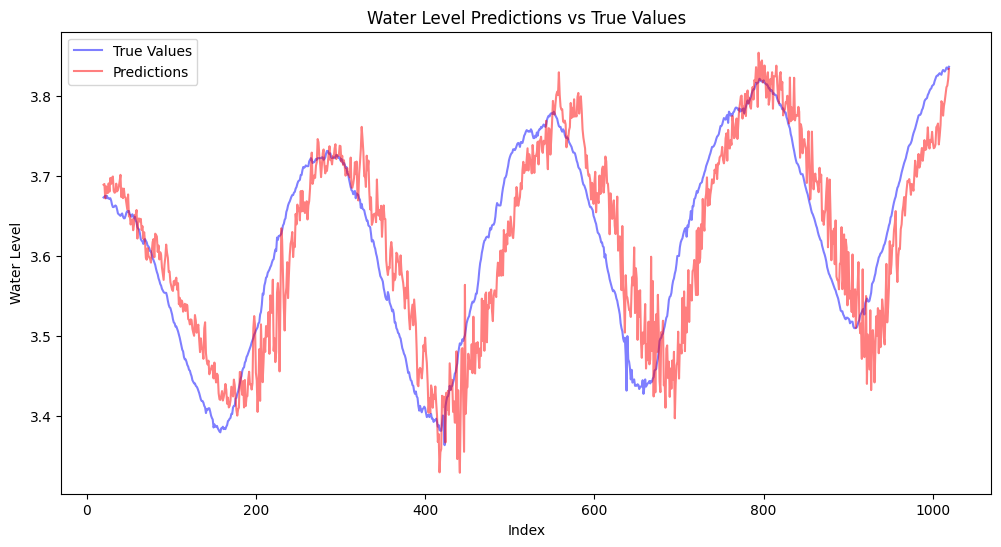

In [11]:
# plotting predictions vs true values
predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()